# 파이널 프로젝트 : 은행 이탈 고객 예측



- **분류**
- 회귀



- 데이터
    - URL : https://www.kaggle.com/competitions/playground-series-s4e1
    - train : 훈련 데이터 세트
    - test : 테스트 데이터 세트
    - sample_submission : 올바른 형식의 샘플 제출 파일

- 평가 지표
    - ROC Curve


- 변수
    - Features(X)
        - ID : 순번
        - Customer ID: 각 고객의 고유 식별번호
        - Surname: 고객의 성
        - Credit Score: 고객의 신용점수
        - Geography: 고객이 거주하는 국가
        - Gender: 고객의 성별
        - Age: 고객의 나이
        - Tenure: 고객이 은행을 이용한 기간
        - Balance: 고객의 계좌 잔액
        - NumOfProducts: 고객이 이용하는 은행 상품의 수(ex. 예금,적금)
        - HasCrCard: 신용카드 보유 여부
        - IsActiveMember: 활성 회원 여부
        - EstimatedSalary: 고객의 예상 연봉
    - Target(Y)
        - Exited: 고객 이탈 여부







## 1.전처리

### 먼저 설치 후 재시작해야하는 패키지

In [ ]:
!pip install pycaret
!pip install optuna
!pip install catboost

### *패키지

In [ ]:
# 기본 패키지
import pandas as pd
import numpy as np

# 설정
pd.set_option('display.max_columns', None)  # 최대 컬럼 설정

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 출력 관련(이미지 표시)
from IPython.display import Image

# 계층적 클러스터링
import scipy.cluster.hierarchy as sch  # 계층적 군집화 알고리즘

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder  # 레이블 인코딩
# pd.get_dummies로 OneHotEncoder 대체

# 데이터 분할
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# 다중공선성 확인(VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# PyCaret: AutoML (자동화된 머신러닝 워크플로우, 모델 선택)
from pycaret.classification import *

# Optuna: 하이퍼파라미터 최적화
import optuna
from optuna.samplers import TPESampler  # 샘플링 알고리즘 (TPE)

# 머신러닝 모델
## GBR
from sklearn.ensemble import GradientBoostingClassifier
## AdaBoost
from sklearn.ensemble import AdaBoostClassifier
## LightGBM
from lightgbm import LGBMClassifier
import lightgbm as lgb
## DecisionTree
from sklearn.tree import DecisionTreeClassifier
## XGBoost
from xgboost import XGBClassifier
import xgboost as xgb
## CatBoost
from catboost import CatBoostClassifier, Pool # pool : catboost에서 데이터 관리위한 특수 클래스(데이터 컨테이너), 범주 변수 자동 인식, 데이터 빠른 처리 등
from catboost.utils import eval_metric

# 성능 평가 지표
from sklearn.metrics import roc_auc_score  # ROC AUC 점수 계산

# 모델 앙상블
from sklearn.ensemble import VotingClassifier  # 앙상블 학습을 위한 VotingClassifier

# 조합 생성 함수
from itertools import combinations

# 변수 중요도
from sklearn.inspection import permutation_importance

### 피쳐요약표

- 타입
- 고유값수
- 타입
- 고유값수
- 결측치수
- 중복치수
- 최소값
- 최대값
- 예시1
- 예시2

In [ ]:
# 피쳐요약표
def feature_summary(df):
  df_temp = pd.DataFrame()
  df_temp['타입'] = df.dtypes
  df_temp['고유값수'] = df.nunique()
  df_temp['결측치수'] = df.isnull().sum()
  df_temp['중복치수'] = df.apply(lambda x: x.duplicated().sum())
  df_temp['최소값'] = df.min()
  df_temp['최대값'] = df.max()
  df_temp['예시1'] = df.iloc[0]
  df_temp['예시2'] = df.iloc[1]
  return df_temp

### 데이터 불러오기
- train
- test
- submission

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/파이널 프로젝트_이정수/분류/train.csv')
test = pd.read_csv('/content/drive/MyDrive/파이널 프로젝트_이정수/분류/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/파이널 프로젝트_이정수/분류/sample_submission.csv')

#### 데이터 파악

##### 데이터 크기

- train
    - 데이터 : 165034
    - 변수 : 14
- test
    - 데이터 : 110023
    - 변수 : 13
- submission
    - 데이터 : 110023
    - 변수 : 2

In [ ]:
for i in [train, test,submission] :
  print(i.shape)

(165034, 14)
(110023, 13)
(110023, 2)


##### 데이터 타입,결측
  - 결측치
      - 0개
  - 타입
      - Int64, float64 : 11개
      - object : 3개
          - Surname : 고객의 성
          - Geography : 고객이 거주하는 국가
          - Gender : 고객의 성별
- **test**
  - 결측치
      - 0개
  - 타입
      - train과 동일(Exited 제외)
- **submission**
  - 결측치
      - 0개
  - 타입
      - int64, float64

In [ ]:
# 피처요약표
feature_summary(train)
feature_summary(test)
feature_summary(submission)

,타입,고유값수,결측치수,중복치수,최소값,최대값,예시1,예시2
id,int64,110023,0,0,165034.0,275056.0,165034.0,165035.0
Exited,float64,1,0,110022,0.5,0.5,0.5,0.5


#### 시각화
- **Barplot**
    - Surname : 범주형 변수이지만 고유값 수가 2797개로 부적합
    - Geography
    - Gender
    - NumOfProducts
    - HasCrCard
    - IsActiveMember
    - Exited
- **Histplot, 밀도추정그래프, BoxPlot, ScatterPlot**
    - CreditScore
    - Age
    - Tenure
    - Balance
    - EstimatedSalary

- **상관관계 히트맵**

##### 시각화 함수 생성

In [ ]:
# 1. BarPlot
def custom_barplot(ax, count):
    for bar in ax.patches:                                                            # ax.patches : 그래프 그려지는 모든 도형 요소
        if bar.get_height() == 0: continue                                            # 막대의 높이가 0이면 건너뜀
        rate = bar.get_height() / count * 100                                         # 백분율 계산

        ax.text(x=bar.get_x() + bar.get_width() / 2,                                  # 막대의 중앙 위치 : bar.get_x(막대의 왼쪽 x좌표), bar.get_width(막대의 너비 = 가로 길이)
                y=bar.get_height() + count * 0.005,                                   # 막대 위쪽에 텍스트 위치 : bar.get_height(막대의 높이 = 세로 길이)
                s=f'{rate:1.1f}%', ha='center')                                       # 비율 텍스트 추가

    ax.set_ylabel('')                                                                 # y축 레이블 제거
    return ax                                                                         # 수정된 Axes 객체 반환

# 2. Histogram
def custom_histogram(ax, data):
    mean = data.mean()                                                                # 데이터 평균 계산
    ax.text(x=ax.get_xlim()[0] + 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0]),        # 왼쪽 여백
            y=max([bar.get_height() for bar in ax.patches]) * 0.85,                   # y 위치 조정
            s=f'Mean: {mean:.2f}', ha='left', color='red')                            # 평균값 표시

    ax.set_ylabel('')                                                                 # y축 레이블 제거
    return ax                                                                         # 수정된 Axes 객체 반환

# 3. Box Plot
def custom_boxplot(ax, data):
    y_median = np.median(data)                                                        # 중앙값 계산
    ax.text(x=1.02, y=y_median, s=f'Median: {y_median:.2f}', ha='left', color='red')  # 중앙값 표시


##### train 시각화


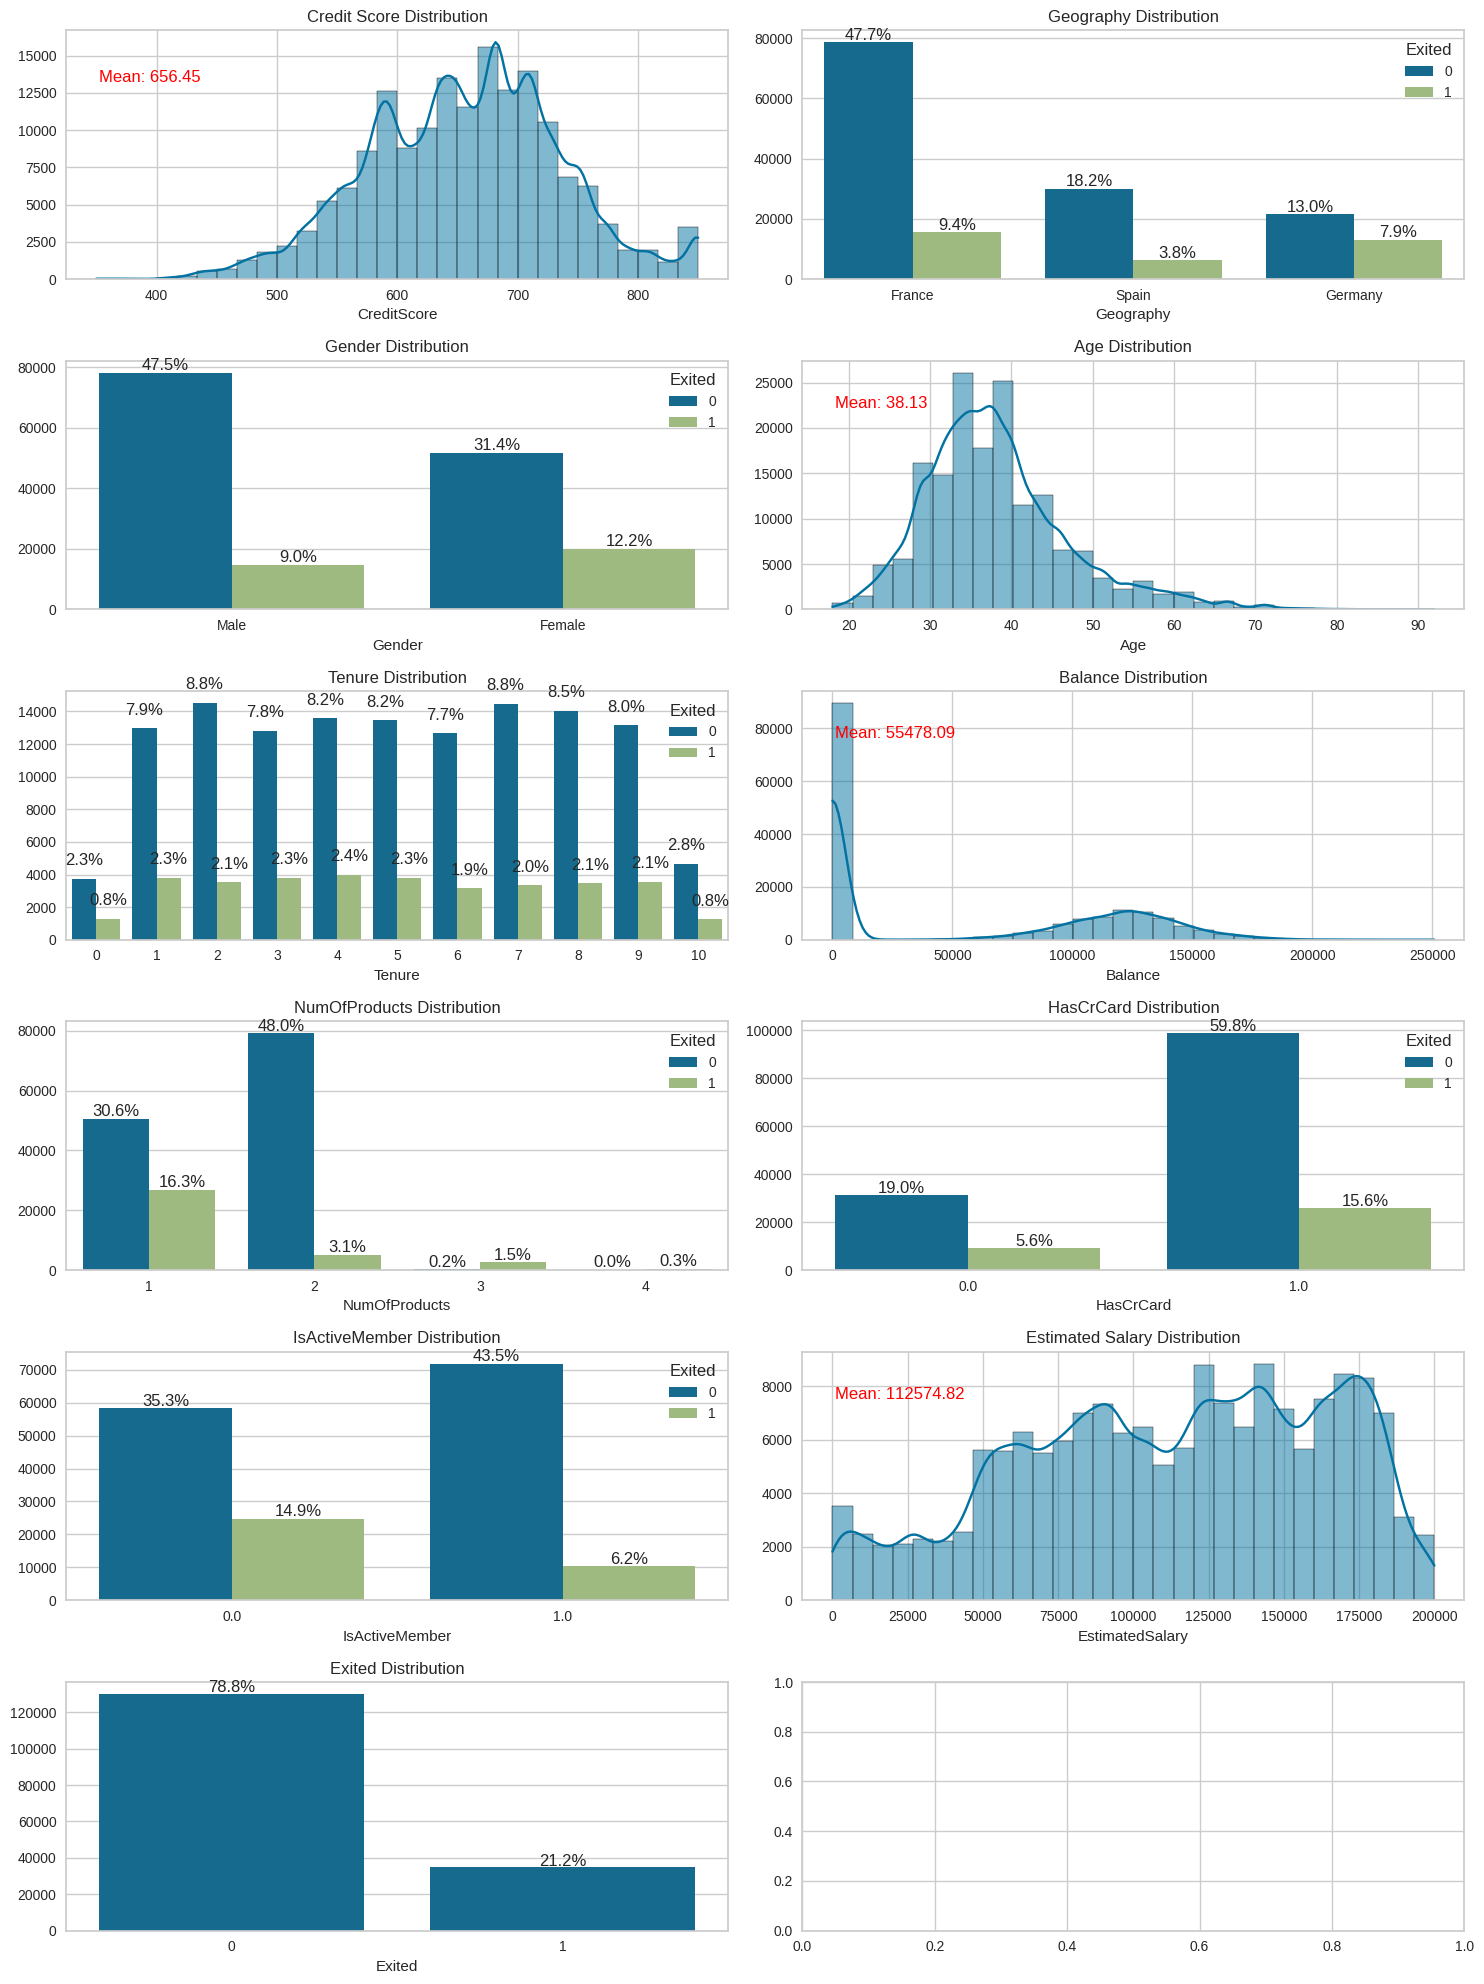

In [ ]:
fig, axes = plt.subplots(6, 2, figsize=(15, 20))

# Credit Score
sns.histplot(train['CreditScore'], bins=30, kde=True, ax=axes[0, 0])
custom_histogram(axes[0, 0], train['CreditScore'])
axes[0, 0].set_title('Credit Score Distribution')

# Geography
ax_geo = sns.countplot(data=train, x='Geography', hue='Exited', ax=axes[0, 1])
custom_barplot(ax_geo, train.shape[0])
axes[0, 1].set_title('Geography Distribution')

# Gender
ax_gender = sns.countplot(data=train, x='Gender', hue='Exited', ax=axes[1, 0])
custom_barplot(ax_gender, train.shape[0])
axes[1, 0].set_title('Gender Distribution')

# Age
sns.histplot(train['Age'], bins=30, kde=True, ax=axes[1, 1])
custom_histogram(axes[1, 1], train['Age'])
axes[1, 1].set_title('Age Distribution')

# Tenure
ax_tenure = sns.countplot(data=train, x='Tenure', hue='Exited', ax=axes[2, 0])
custom_barplot(ax_tenure, train.shape[0])
axes[2, 0].set_title('Tenure Distribution')

# Balance
sns.histplot(train['Balance'], bins=30, kde=True, ax=axes[2, 1])
custom_histogram(axes[2, 1], train['Balance'])
axes[2, 1].set_title('Balance Distribution')

# NumOfProducts
ax_num_products = sns.countplot(data=train, x='NumOfProducts', hue='Exited', ax=axes[3, 0])
custom_barplot(ax_num_products, train.shape[0])
axes[3, 0].set_title('NumOfProducts Distribution')

# HasCrCard
ax_has_crcard = sns.countplot(data=train, x='HasCrCard', hue='Exited', ax=axes[3, 1])
custom_barplot(ax_has_crcard, train.shape[0])
axes[3, 1].set_title('HasCrCard Distribution')

# IsActiveMember
ax_active_member = sns.countplot(data=train, x='IsActiveMember', hue='Exited', ax=axes[4, 0])
custom_barplot(ax_active_member, train.shape[0])
axes[4, 0].set_title('IsActiveMember Distribution')

# Estimated Salary
sns.histplot(train['EstimatedSalary'], bins=30, kde=True, ax=axes[4, 1])
custom_histogram(axes[4, 1], train['EstimatedSalary'])
axes[4, 1].set_title('Estimated Salary Distribution')

# Exited
ax_exited = sns.countplot(data=train, x='Exited', ax=axes[5, 0])
custom_barplot(ax_exited, train.shape[0])
axes[5, 0].set_title('Exited Distribution')

plt.tight_layout()
plt.show()

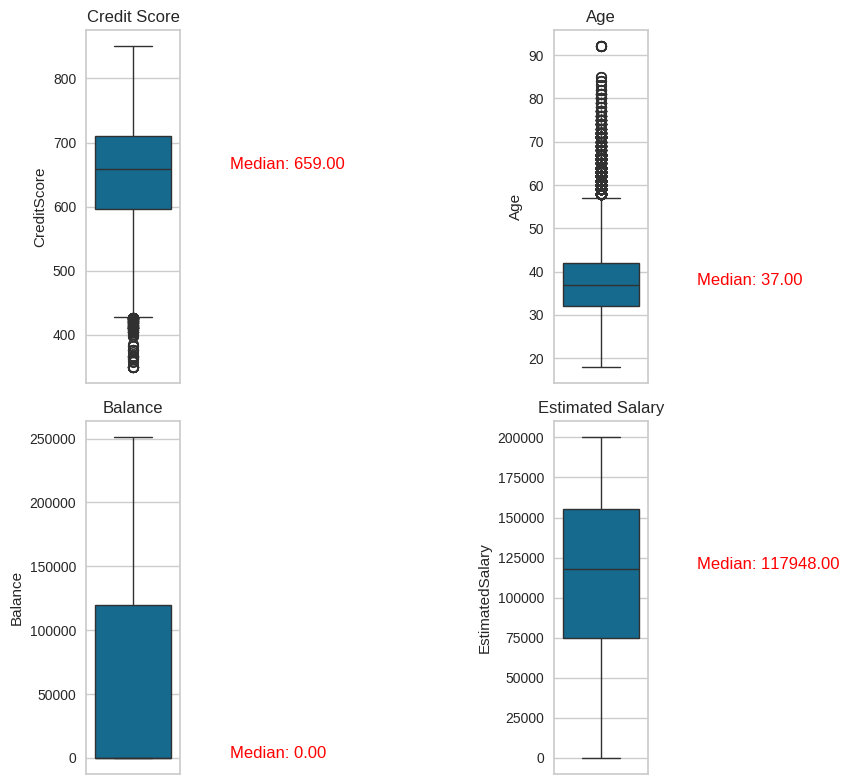

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Credit Score
sns.boxplot(y=train['CreditScore'], ax=axes[0, 0])
custom_boxplot(axes[0, 0], train['CreditScore'])
axes[0, 0].set_title('Credit Score')

# Age
sns.boxplot(y=train['Age'], ax=axes[0, 1])
custom_boxplot(axes[0, 1], train['Age'])
axes[0, 1].set_title('Age')

# Balance
sns.boxplot(y=train['Balance'], ax=axes[1, 0])
custom_boxplot(axes[1, 0], train['Balance'])
axes[1, 0].set_title('Balance')

# Estimated Salary
sns.boxplot(y=train['EstimatedSalary'], ax=axes[1, 1])
custom_boxplot(axes[1, 1], train['EstimatedSalary'])
axes[1, 1].set_title('Estimated Salary')

plt.tight_layout()
plt.show()

###### train 시각화 해석


- **BarPlot, HistPlot 해석**
    - **Credit Score(신용점수)**
        - 평균
            - 656.45
        - 분포
            - 대체로 정규분포 형태
            - 신용 점수 분포가 넓게 퍼져있어 다양한 점수 분포
            - 신용점수가 600-700 사이에 가장 많은 고객이 분포

    - **Geography(고객 거주 국가)**
        - 분포
            - France가 전체의 57.1%로 가장 많고, 그 다음 Spain 22%, Germany 20.9% 순서
        - 이탈
            - 세 국가 모두 이탈하지 않은 고객(0)이 이탈 고객(1)보다 많다
                - 프랑스는 이탈 비율이 낮고, 독일은 상대적으로 높은 이탈율을 보인다

    - **Gender(고객 성별)**
        - 분포
            - 남성이 약 56.5%, 여성이 43.6%로 대략 6:4 비율
        - 이탈
            - 남성, 여성 모두 이탈하지 않은 사람(0)이 이탈자(1)보다 많다
                - 남성보다 여성이 이탈 비율이 더 높다

    - **Age(고객 연령)**
        - 평균
            - 38.13
        - 분포
            - 대체로 정규분포 형태
            - 30,40대에 주 고객층이 모여있다
            - 나이가 많을 수록 고객 수가 급격히 감소하는 경향
                - 젊은 고객층(30-40대)에서 고객수가 집중

    - **Tenure(은행 이용 기간)**
        - 분포
            - 모든 기간에 고객수가 고르게 분포되어 있지만, 0년과 10년에 소폭 감소
        - 이탈
            - 이용 기간에 관계없이 이탈하지 않은 사람이(0)이 이탈자(1) 보다 많다

    - **Balance(계좌잔액)**
        - 평균
            - 55478.09
        - 분포
            - 0인 경우가 가장 많으며, 0을 제외한 나머지 값들은 정규분포에 가깝게 분포
            - 주로 50,000~200,000 구간에 집중

    - **NumOfProducts(고객 이용 은행 상품 수)**
        - 분포
            - 1개 또는 2개 상품을 보유한 고객이 대부분
                - 1개(46.9%), 2개(51.1%)
        - 이탈
            - 상품 개수가 1개인 고객의 이탈 비율이 상대적으로 높다

    - **HasCrCard(신용카드 보유 여부)**
        - 분포
            - 신용카드 보유 고객(1)이 75.4%, 비보유 고객(0)이 24.6%의 분포로 보유한 고객이 더 많다
        - 이탈
            - 신용카드 보유 여부와 관계없이 이탈하지 않은 고객이 더 많다.

    - **IsActiveMemebr(활성 회원 여부)**
        - 분포
          - 비활성회원이 50.2%, 활성회원이 49.7%로 차이가 매우 적었다.
        - 이탈
            - 비활성 회원의 이탈율이 더 높다.

    - **EstimatedSalary(추정 연봉)**
        - 평균
            - 112574.82
        - 분포
            - 급여가 0에서 200000까지 고르게 분포
                - 주요 구간 : 50000 - 175000

    - **Exited(이탈 여부)**
        - 분포
            - 전체 고객 중 이탈하지 않은 사람(0)이 78.8%, 이탈자(1)는 21.2%로 대략 8:2 비율

- BoxPlot
    - CreditScore
        - 이상치
            - O
            - 신용 점수 하단에 이상치 다수 존재
                - 특히 400이하 낮은 점수 고객, 점수가 낮은 일부 고객층 포함
        - 중앙값
            - 659
        - 분포
            - 약간 오른쪽으로 치우친 분포
                - 왼쪽꼬리

    - Age
        - 이상치
            - O
            - 60 이상의 나이에서 이상치 다수 존재
                - 특히 80세 이상 고객이 드물게 포함, 고령층 소수 포함
        - 중앙값
            - 37
        - 분포
            - 오른쪽 긴 꼬리
    - Balance
        - 이상치
            - X
        - 중앙값
            - 0
    - EstimatedSalary
        - 이상치
            - X
        - 중앙값
            - 117,948

##### test 시각화


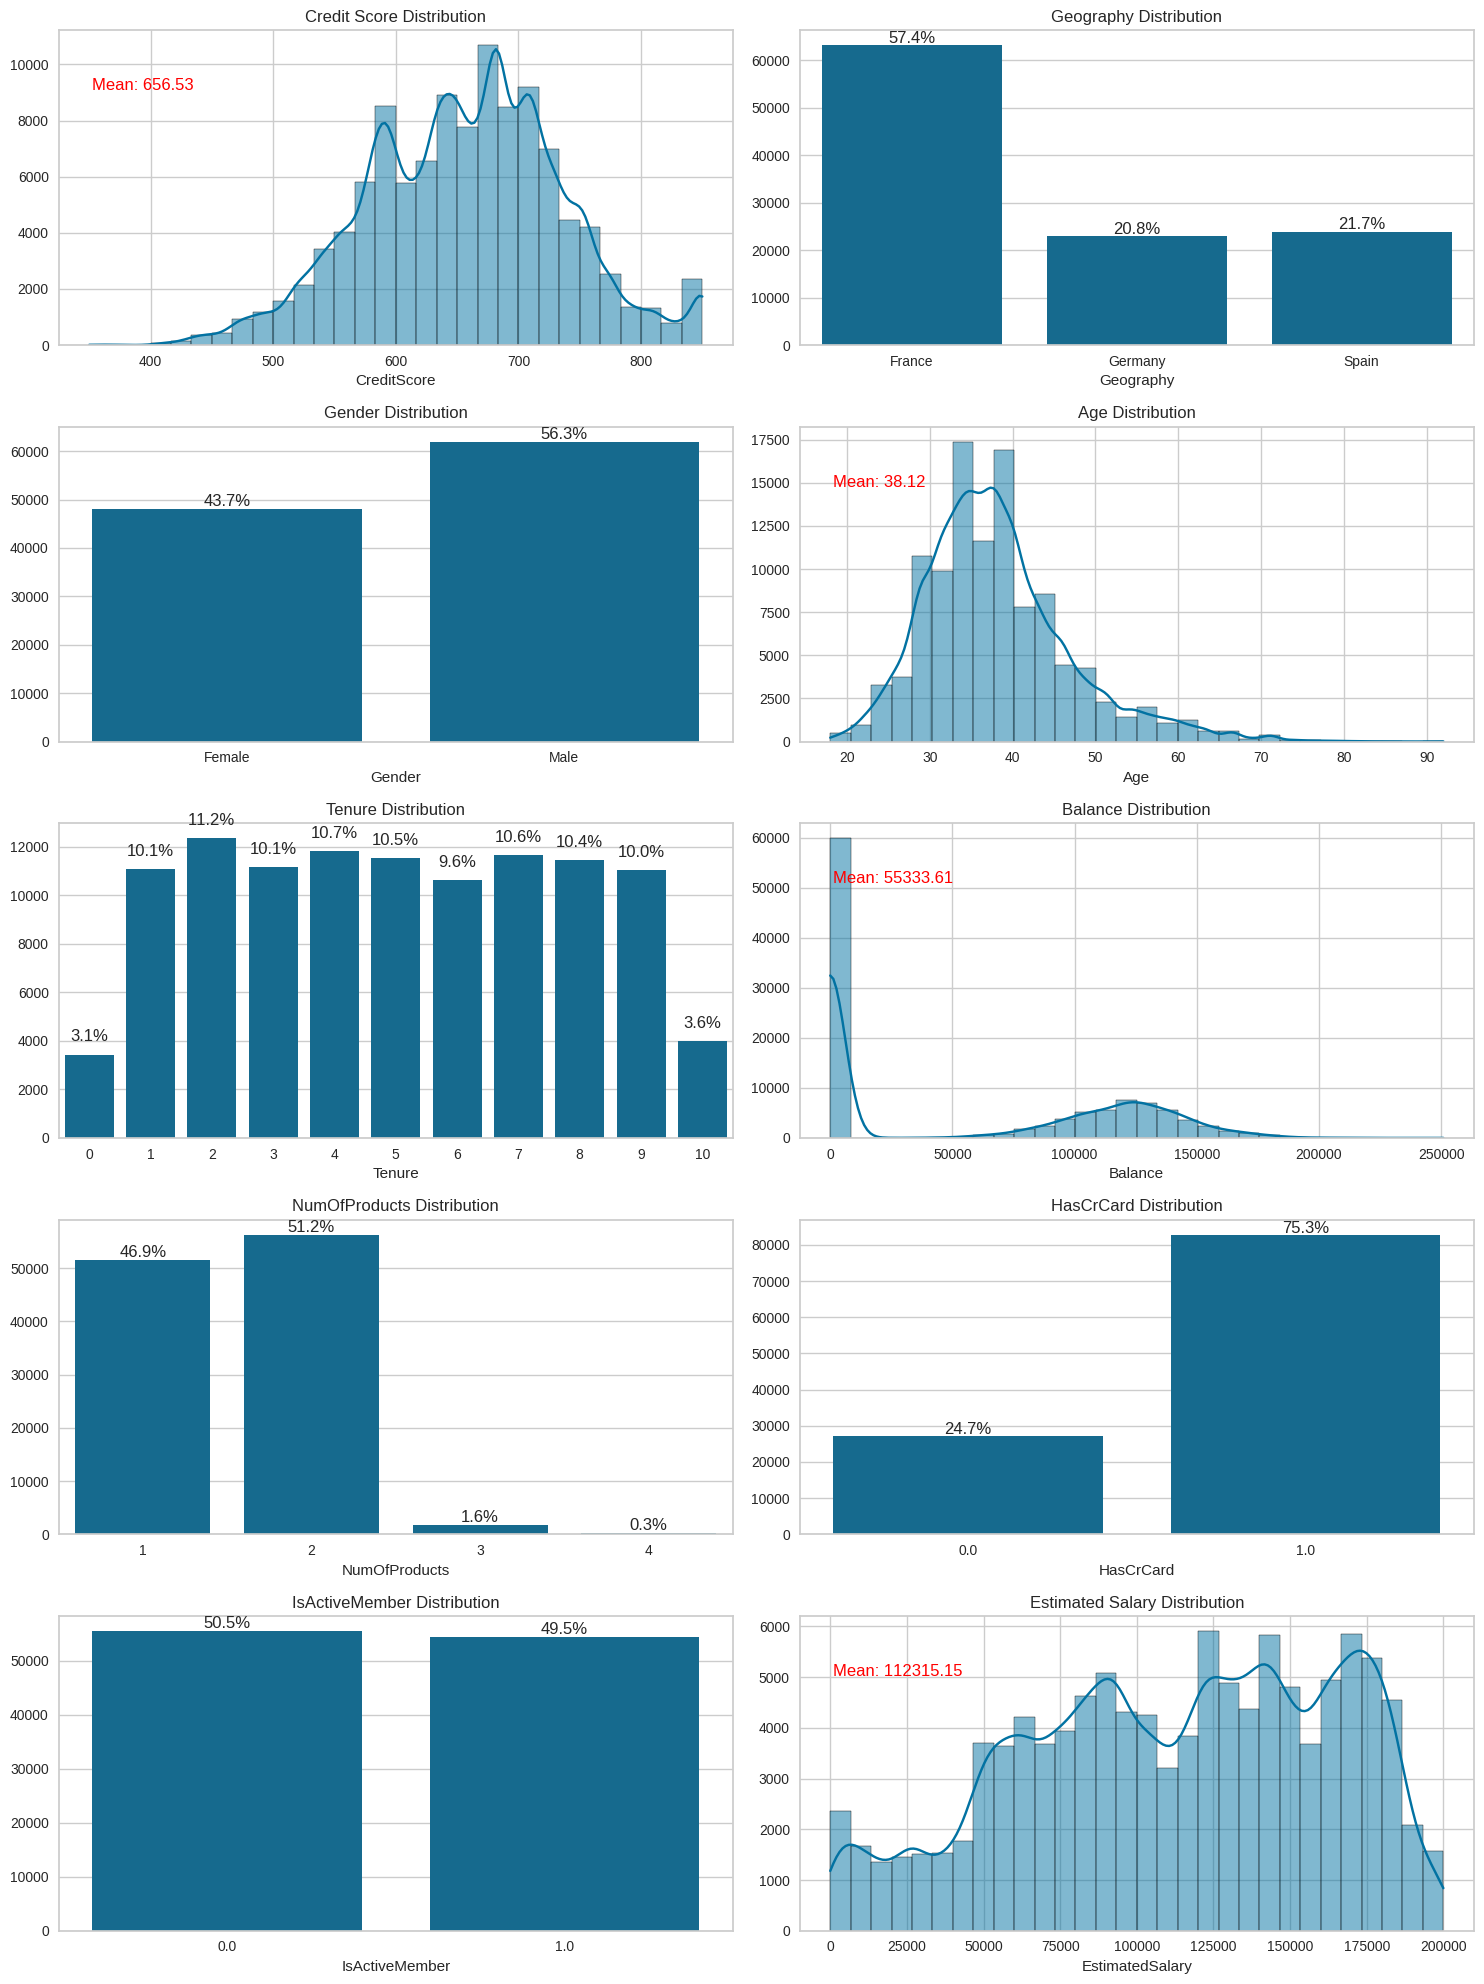

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

# Credit Score
sns.histplot(test['CreditScore'], bins=30, kde=True, ax=axes[0, 0])
custom_histogram(axes[0, 0], test['CreditScore'])
axes[0, 0].set_title('Credit Score Distribution')

# Geography
ax_geo = sns.countplot(data=test, x='Geography', ax=axes[0, 1])
custom_barplot(ax_geo, test.shape[0])
axes[0, 1].set_title('Geography Distribution')

# Gender
ax_gender = sns.countplot(data=test, x='Gender', ax=axes[1, 0])
custom_barplot(ax_gender, test.shape[0])
axes[1, 0].set_title('Gender Distribution')

# Age
sns.histplot(test['Age'], bins=30, kde=True, ax=axes[1, 1])
custom_histogram(axes[1, 1], test['Age'])
axes[1, 1].set_title('Age Distribution')

# Tenure
ax_tenure = sns.countplot(data=test, x='Tenure', ax=axes[2, 0])
custom_barplot(ax_tenure, test.shape[0])
axes[2, 0].set_title('Tenure Distribution')

# Balance
sns.histplot(test['Balance'], bins=30, kde=True, ax=axes[2, 1])
custom_histogram(axes[2, 1], test['Balance'])
axes[2, 1].set_title('Balance Distribution')

# NumOfProducts
ax_num_products = sns.countplot(data=test, x='NumOfProducts', ax=axes[3, 0])
custom_barplot(ax_num_products, test.shape[0])
axes[3, 0].set_title('NumOfProducts Distribution')

# HasCrCard
ax_has_crcard = sns.countplot(data=test, x='HasCrCard', ax=axes[3, 1])
custom_barplot(ax_has_crcard, test.shape[0])
axes[3, 1].set_title('HasCrCard Distribution')

# IsActiveMember
ax_active_member = sns.countplot(data=test, x='IsActiveMember', ax=axes[4, 0])
custom_barplot(ax_active_member, test.shape[0])
axes[4, 0].set_title('IsActiveMember Distribution')

# Estimated Salary
sns.histplot(test['EstimatedSalary'], bins=30, kde=True, ax=axes[4, 1])
custom_histogram(axes[4, 1], test['EstimatedSalary'])
axes[4, 1].set_title('Estimated Salary Distribution')

plt.tight_layout()
plt.show()

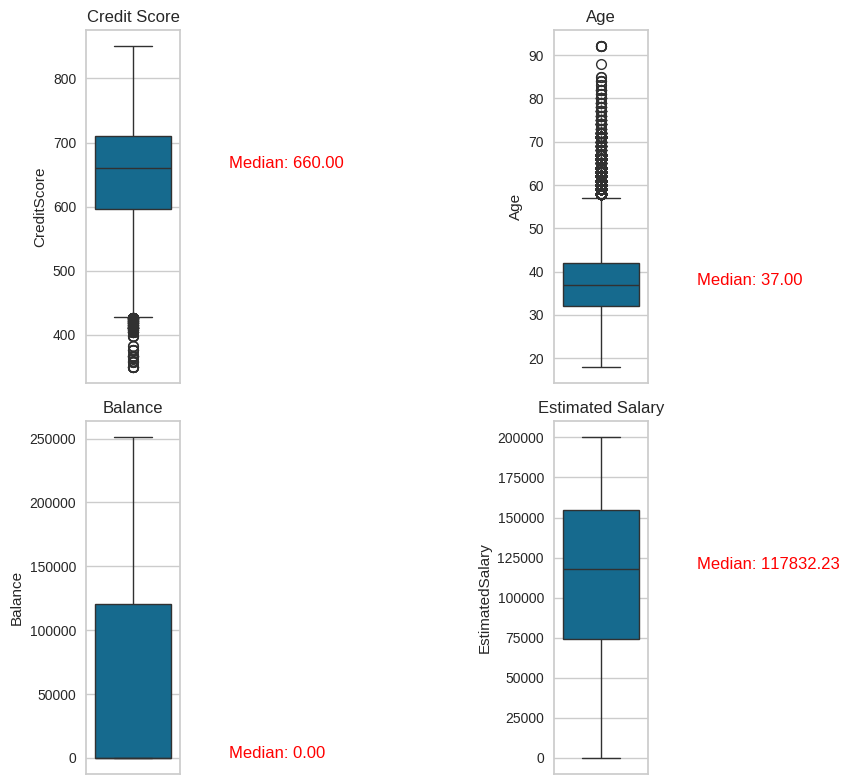

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Credit Score
sns.boxplot(y=test['CreditScore'], ax=axes[0, 0])
custom_boxplot(axes[0, 0], test['CreditScore'])
axes[0, 0].set_title('Credit Score')

# Age
sns.boxplot(y=test['Age'], ax=axes[0, 1])
custom_boxplot(axes[0, 1], test['Age'])
axes[0, 1].set_title('Age')

# Balance
sns.boxplot(y=test['Balance'], ax=axes[1, 0])
custom_boxplot(axes[1, 0], test['Balance'])
axes[1, 0].set_title('Balance')

# Estimated Salary
sns.boxplot(y=test['EstimatedSalary'], ax=axes[1, 1])
custom_boxplot(axes[1, 1], test['EstimatedSalary'])
axes[1, 1].set_title('Estimated Salary')

plt.tight_layout()
plt.show()

###### test 시각화 해석


- BarPlot, HistPlot 해석
    - **Credit Score(신용점수)**
        - 평균
            - 656.53
        - 분포
            - 대체로 정규분포 형태
            - 신용 점수 분포가 넓게 퍼져있어 다양한 점수 분포
            - 신용점수가 600-700 사이에 가장 많은 고객이 분포

    - **Geography(고객 거주 국가)**
        - 분포
            - France가 전체의 57.4%로 가장 많고, 그 다음 Spain 21.7%, Germany 20.8% 순서

    - **Gender(고객 성별)**
        - 분포
            - 남성이 약 56.3%, 여성이 43.7%

    - **Age(고객 연령)**
        - 평균
            - 38.12
        - 분포
            - 대체로 정규분포 형태
            - 30,40대에 주 고객층이 모여있다
            - 연령이 증가할수록 고객 수가 급격히 감소하는 경향
                - 젊은 고객층(30-40대)에서 고객수가 집중

    - **Tenure(은행 이용 기간)**
        - 분포
            - 모든 기간에 고객수가 고르게 분포되어 있지만, 0년과 10년에 소폭 감소

    - **Balance(계좌잔액)**
        - 평균
            - 55333.61
        - 분포
            - 0인 경우가 가장 많으며, 0을 제외한 나머지 값들은 정규분포에 가깝게 분포
            - 주로 50,000~200,000 구간에 집중

    - **NumOfProducts(고객 이용 은행 상품 수)**
        - 분포
            - 1개 또는 2개 상품을 보유한 고객이 대부분
                - 1개(46.9%), 2개(51.2%)

    - **HasCrCard(신용카드 보유 여부)**
        - 분포
            - 신용카드 보유 고객(1)이 73.3%, 비보유 고객(0)이 24.7%의 분포로 보유한 고객이 더 많다

    - **IsActiveMemebr(활성 회원 여부)**
        - 분포
          - 비활성회원이 50.5%, 활성회원이 49.5%로 차이가 매우 적었다.

    - **EstimatedSalary(추정 연봉)**
        - 평균
            - 112315.15
        - 분포
            - 급여가 0에서 200000까지 고르게 분포
                - 주요 구간 : 50000 - 175000

- BoxPlot
    - CreditScore
        - 이상치
            - O
            - 신용 점수 하단에 이상치 다수 존재
                - 특히 400이하 낮은 점수 고객, 점수가 낮은 일부 고객층 포함
        - 중앙값
            - 660
        - 분포
            - 약간 오른쪽으로 치우친 분포
                - 왼쪽꼬리

    - Age
        - 이상치
            - O
            - 60 이상의 나이에서 이상치 다수 존재
                - 특히 80세 이상 고객이 드물게 포함, 고령층 소수 포함
        - 중앙값
            - 37
        - 분포
            - 오른쪽 긴 꼬리
    - Balance
        - 이상치
            - X
        - 중앙값
            - 0
    - EstimatedSalary
        - 이상치
            - X
        - 중앙값
            - 117,832.23


### 데이터 파악 후 전처리 계획

```
# ID, Surname 제거


# Credit Score => 로그 변환, 스케일링 진행 가능성
- 대체로 정규 분포
- 신용점수 하단에 이상치 다수 존재 -> 왼쪽꼬리
- 필요시 로그 변환 진행
- 분포가 넓게 퍼져있다 -> 필요시 스케일링 진행



# Geography => OneHot Encoding
- 문자형,범주형 변수 : 인코딩 진행
- 고유값 3개
- 순서 X
- OneHot Encoding 진행 가능성

# Gender => Label, Binary Encoding
- 문자형,범주형 변수 : 인코딩 진행
- 고유값 2개 : 라벨 인코딩 or 이진 인코딩

# Age => 로그 변환, 스케일링, 구간 변환 가능성
- 대체로 정규분포 형태
- 60세 이상 이상치 존재 -> 오른쪽 꼬리
- 필요시 로그 변환 진행
- 분포가 넓게 퍼져있다(20대 – 90대) -> 필요시 스케일링 진행
- 분포 30,40대 집중 / 60대 이상은 극소수 -> 이상치(60대 이상)들을 포함시키기 위해 age를 구간으로 사용할 가능성

# Tenure => 그대로 or Label Encoding
- 정수형,범주형 변수 : 그대로 사용 or Label Encoding(일관성 위해 인코딩 진행)
- 0년, 10년만 소폭 감소

# Balance => 로그변환, 스케일링, 이항변수, 클러스터링(범주형) 가능성
- 0인 경우가 매우 많고, 나머지가 정규분포에 가까움 -> 왼쪽 꼬리
- 필요시 로그 변환 혹은 스케일링
- 0 처리 -> 이항변수(범주형)로 만드는 방법
- 범주형(낮음, 중간, 높음) : 클러스터링

# NumOfProducts => OneHot Encoding 가능성
- 정수형, 범주형 변수
- 순서가 없다
- OneHot Encoding 가능성
- 1개(46.9%), 2개(51.1%)가 대부분

# HasCrCard => Label Encoding 가능성
- 정수형, 범주형 변수
- 순서 X
- 이진 변수
-> Label Encoding 적합 가능성(일관성 위해)


# IsActiveMember => Label Encoding 가능성
- 정수형, 범주형 변수
- 순서
- 이진 변수
-> LabelEncoding 적합해보임(일관성 위해)

# EstimatedSalary => 스케일링 가능성
- 분포가 넓게 퍼져있다(0-200000)
- 주요 구간 : 5000 - 175000
-> 스케일링 가능성

# Exited

```

### 1. 전처리 진행
- 다중공선성 확인
- ID, Surname 제거
- 스케일링 X
- 인코딩 O
- 이상치 처리 X
- 중복치 처리 X
- 파생변수 X


#### 변수 제거 및 인코딩

In [ ]:
# train, test 동시 진행

# Id, Surname 제거
train.drop(columns=['id','Surname'],inplace=True)
test.drop(columns=['id','Surname'],inplace=True)

# Geography -> OneHot Encoding
train = pd.get_dummies(train, columns=['Geography'],dtype=int)
test = pd.get_dummies(test, columns=['Geography'], dtype=int)

# Gender -> Label Encoding
encoder = LabelEncoder()
train['Gender'] = encoder.fit_transform(train['Gender'])
test['Gender'] = encoder.transform(test['Gender'])

'''
- 매칭 값 확인 -
코드 :
    original_classes = encoder.classes_
    mapping = {}
    for i, original in enumerate(original_classes):
        mapping[original] = i
    print("매핑:", mapping)

결과 :
    매핑: {'Female': 0, 'Male': 1}
'''

# Tenure -> Label Encoding
encoder = LabelEncoder()
train['Tenure'] = encoder.fit_transform(train['Tenure'])
test['Tenure'] = encoder.transform(test['Tenure'])

'''
- 매칭 값 확인 -
코드 :
    original_classes = encoder.classes_
    mapping = {}
    for i, original in enumerate(original_classes):
        mapping[original] = i
    print("매핑:", mapping)

결과 :
    매핑: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
'''

# NumOfProducts -> OneHot Encoding
train = pd.get_dummies(train, columns=['NumOfProducts'],dtype=int)
test = pd.get_dummies(test, columns=['NumOfProducts'], dtype=int)

# HasCrCard -> Label Encoding
encoder = LabelEncoder()
train['HasCrCard'] = encoder.fit_transform(train['HasCrCard'])
test['HasCrCard'] = encoder.transform(test['HasCrCard'])

'''
- 매칭 값 확인 -
코드 :
    original_classes = encoder.classes_
    mapping = {}
    for i, original in enumerate(original_classes):
        mapping[original] = i
    print("매핑:", mapping)

결과 :
    매핑: {0.0: 0, 1.0: 1}
'''

# IsActiveMember -> Label Encoding
encoder = LabelEncoder()
train['IsActiveMember'] = encoder.fit_transform(train['IsActiveMember'])
test['IsActiveMember'] = encoder.transform(test['IsActiveMember'])

'''
- 매칭 값 확인 -
코드 :
    original_classes = encoder.classes_
    mapping = {}
    for i, original in enumerate(original_classes):
        mapping[original] = i
    print("매핑:", mapping)

결과 :
    매핑: {0.0: 0, 1.0: 1}
'''

'\n- 매칭 값 확인 -\n코드 :\n    original_classes = encoder.classes_\n    mapping = {}\n    for i, original in enumerate(original_classes):\n        mapping[original] = i\n    print("매핑:", mapping)\n\n결과 :\n    매핑: {0.0: 0, 1.0: 1}\n'

#### 다중공선성(VIF)

- 인코딩으로 인한 더미변수 제외 모두 다중공선성 X

```
              Feature       VIF
0          CustomerId  1.000260
1         CreditScore  1.000737
2              Gender  1.008577
3                 Age  1.044343
4              Tenure  1.000365
5             Balance  1.696069
6           HasCrCard  1.001405
7      IsActiveMember  1.010977
8     EstimatedSalary  1.000438
9    Geography_France       inf
10  Geography_Germany       inf
11    Geography_Spain       inf
12    NumOfProducts_1       inf
13    NumOfProducts_2       inf
14    NumOfProducts_3       inf
15    NumOfProducts_4       inf
```

In [ ]:
# target 변수 제외: train_features
train_features = train.drop(columns=['Exited'])

# VIF 계산 : (exog : Any, exog_idx : Any ) -> (독립변수, 독립변수 인덱스) -> 독립변수 : 독립 변수들을 포함하는 2D 배열이나 데이터프레임 /
vif_data = pd.DataFrame()
vif_data['Feature'] = train_features.columns
vif_data['VIF'] = [variance_inflation_factor(train_features.values, i) for i in range(train_features.shape[1])]
print(vif_data)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


              Feature       VIF
0          CustomerId  1.000260
1         CreditScore  1.000737
2              Gender  1.008577
3                 Age  1.044343
4              Tenure  1.000365
5             Balance  1.696069
6           HasCrCard  1.001405
7      IsActiveMember  1.010977
8     EstimatedSalary  1.000438
9    Geography_France       inf
10  Geography_Germany       inf
11    Geography_Spain       inf
12    NumOfProducts_1       inf
13    NumOfProducts_2       inf
14    NumOfProducts_3       inf
15    NumOfProducts_4       inf


#### 추가 시각화_상관관계 히트맵

- 더미변수끼리의 상관계수 비교 제외
- Exited
    - 양
        - **Age(0.34)**
            - 연령이 높을 수록 이탈율 다소 높다
        - NumOfProducts_1(0.31)
            - 은행 상품수를 1개 보유할 때 이탈율 다소 높다
        - Geography_Germany(0.21)
            - 독일 거주하는 고객이 이탈할 가능성 다소 높다
        - Balacne(0.13)
            - 잔고가 높은 고객이 이탈 가능성이 조금 높다
            - 낮음

    - 음
        - **NumOfProducts_2(-0.38)**
            - 은행 상품수를 2개 보유할 때 이탈율 다소 감소
        - IsActiveMember(-0.21)
            - 활동적인 고객일수록 이탈 가능성이 다소 낮다
        - Gender(-0.15)
            - 남성인 고객이 이탈 가능성이 약간 더 낮다
        - Geography_France(-0.13)
            - 프랑스의 거주하는 고객이 이탈할 가능성 다소 낮다

- 전체
    - 양
        - **Geography_Germany ↔ Balance(0.54)**
            - 독일 거주 고객일수록 잔고가 높은 가능성
        - NumOfProducts_1 ↔ Balance(0.41)
            - 상품을 1개 보유한 고객일수록 잔고가 높을 가능성
        - Age ↔ NumOfProducts_1(0.14)
            - 연령이 높을수록 상품을 1개 보유할 가능성
        - NumOfProducts_1 ↔ Geography_Germany(0.13)
            - 상품을 1개 보유하는 고객이 독일에 거주할 가능성
    - 음
        - **NumOfProducts_2 ↔ Balance (-0.41)**
            - 상품을 2개 보유할수록 잔고가 낮을 가능성
        - Balance ↔ Geography_France (-0.33)
            - 프랑스 거주 고객은 잔고가 낮을 가능성
        - NumOfProducts_2 ↔ Age (-0.17)
            - 상품을 2개 보유한 고객은 나이가 어릴 가능성
        - NumOfProducts_2 ↔ Geography_Germany(-0.15)
            - 상품을 2개 보유한 고객은 독일 거주 가능성이 낮다

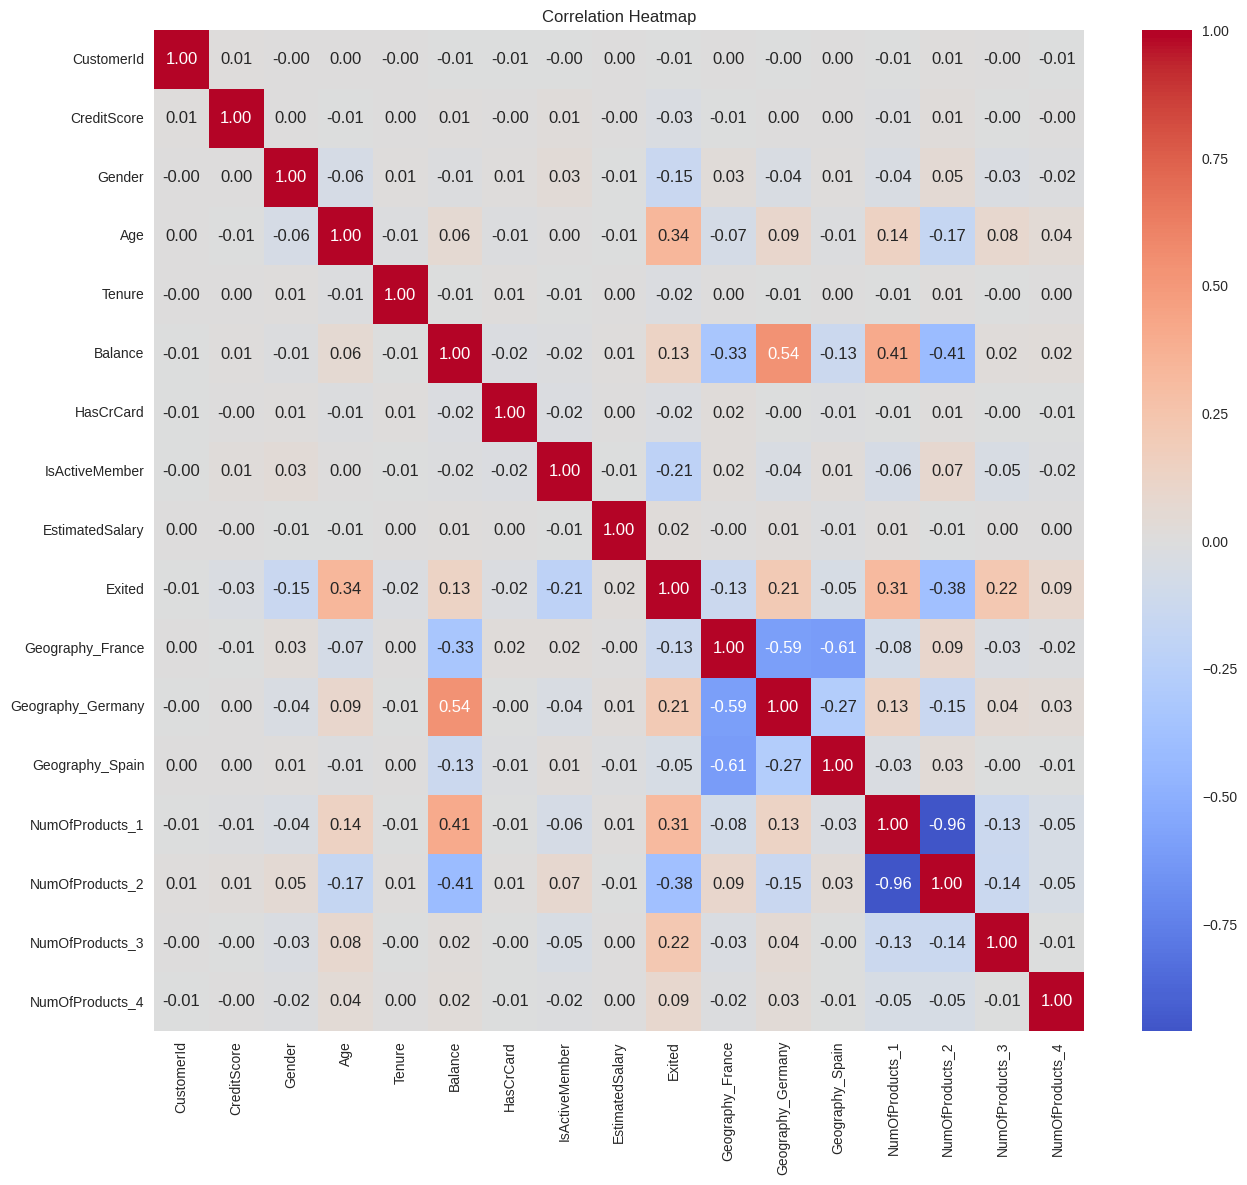

In [ ]:
corr = train.corr()

# 히트맵 시각화
plt.figure(figsize=(15, 13))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', center=0, cbar=True)

# 그래프 제목 추가
plt.title('Correlation Heatmap')

# 그래프 출력
plt.show()

#### 클러스터링

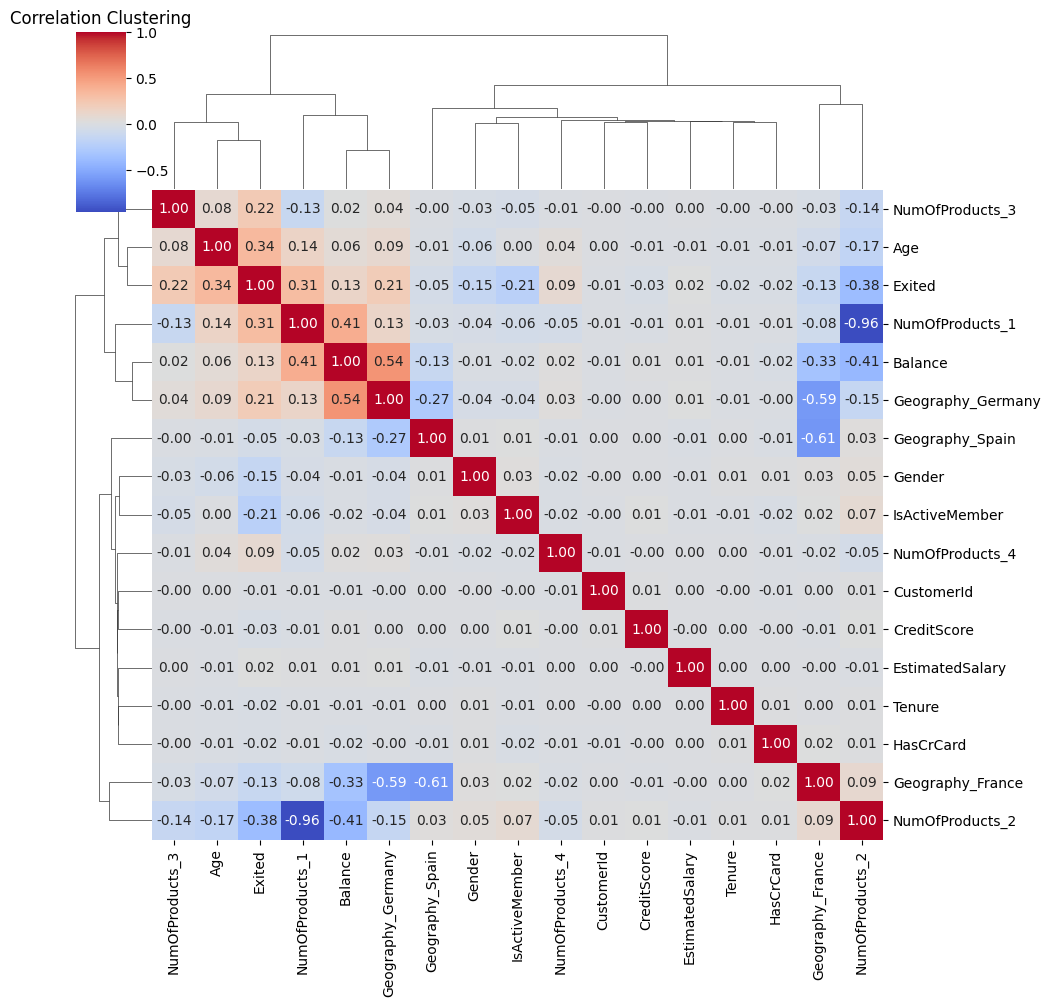

In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# 상관관계 계산
corr = train.corr()

# 상관관계 클러스터링
sns.clustermap(corr, method='ward', cmap='coolwarm', annot=True, fmt=".2f",
               figsize=(10, 10), dendrogram_ratio=(.1, .2))
plt.title('Correlation Clustering')
plt.show()

## 2.모델링

### 데이터 분리

In [ ]:
# feature, target 분리
train_feature = train.drop(columns='Exited')
train_target = train['Exited']

# 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_target,
                                                      test_size = 0.3,
                                                      random_state=0)

# 분리 데이터 크기 확인
for i in [X_train, X_valid, y_train, y_valid] :
  print(i.shape)

(115523, 16)
(49511, 16)
(115523,)
(49511,)


### AutoML
- gbc : Gradient Boosting Classifier
- lightgbm : Light Gradient Boosting Machine
- catboost : CatBoost Classifier
- xgboost : Extreme Gradient Boosting
- ada : Ada Boost Classifier

In [ ]:
# 인덱스 번호 새로 할당
X_train_automl = X_train.reset_index(drop=True)
y_train_automl = y_train.reset_index(drop=True)

# X_train, y_train 합치기
Xy_train_automl = pd.concat([X_train_automl, y_train_automl], axis=1)

# AutoML 모델 세팅
clf = setup(data=Xy_train_automl,
            target = 'Exited',
            train_size = 0.7,
            data_split_shuffle=True,
            session_id = 0,
            fold = 5
            )

# AutoML top5 model 설정
top5_model = compare_models(fold=5, round=3, n_select=5, sort = 'AUC', errors='ignore',verbose=True)
top5_model

,Description,Value
0,Session id,0
1,Target,Exited
2,Target type,Binary
3,Original data shape,"(115523, 17)"
4,Transformed data shape,"(115523, 17)"
5,Transformed train set shape,"(80866, 17)"
6,Transformed test set shape,"(34657, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.864,0.887,0.532,0.753,0.624,0.544,0.556,12.992
lightgbm,Light Gradient Boosting Machine,0.865,0.887,0.552,0.743,0.634,0.553,0.562,2.806
catboost,CatBoost Classifier,0.864,0.886,0.542,0.745,0.627,0.547,0.557,26.376
xgboost,Extreme Gradient Boosting,0.862,0.881,0.553,0.728,0.629,0.545,0.553,1.246
ada,Ada Boost Classifier,0.859,0.878,0.519,0.737,0.609,0.527,0.539,3.224
rf,Random Forest Classifier,0.858,0.875,0.529,0.728,0.613,0.529,0.539,14.104
et,Extra Trees Classifier,0.856,0.870,0.519,0.723,0.604,0.519,0.530,9.756
ridge,Ridge Classifier,0.850,0.868,0.419,0.769,0.543,0.462,0.493,0.126
lda,Linear Discriminant Analysis,0.855,0.868,0.519,0.720,0.603,0.517,0.528,0.174
nb,Naive Bayes,0.794,0.777,0.196,0.535,0.287,0.196,0.230,0.134


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

[GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=100, n_iter_no_change=None,
                            random_state=0, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=0, reg_alpha=0.0, reg_lambda=0

### Optuna
- gbc
```
Best AUC: 0.8879903418757644
Best hyperparameters:
  n_estimators: 441
  learning_rate: 0.045696033561884446
  max_depth: 7
  min_samples_split: 2
  min_samples_leaf: 2
  subsample: 0.9753636860597981
  max_features: log2
  loss: exponential
  ccp_alpha: 2.8658360294722587e-05
  validation_fraction: 0.27267380097000604
  n_iter_no_change: 17
  tol: 0.005721221703263734
  min_impurity_decrease: 0.04492762681125898
  max_leaf_nodes: 65
```
- lightgbm
```
Best AUC: 0.8893180320851476
Best hyperparameters:
  num_boost_round: 424
  learning_rate: 0.04631415040823912
  num_leaves: 38
  max_depth: 9
  min_data_in_leaf: 47
  feature_fraction: 0.9024601968835392
  bagging_fraction: 0.7342793249627353
  bagging_freq: 2
  min_gain_to_split: 0.3017007245252093
  lambda_l1: 0.07886266683723922
  lambda_l2: 0.0859776680854032
  tree_learner: serial
  max_bin: 310
  early_stopping_rounds: 38
  num_threads: 3
  scale_pos_weight: 3.8048327134060944
```
- CatBoost
```
Best AUC: 0.8894975131185816
Best hyperparameters:
  iterations: 622
  learning_rate: 0.15620856452750326
  depth: 3
  l2_leaf_reg: 0.023092783762797234
  random_strength: 0.013271842224732251
  bagging_temperature: 6.81082830068841
  grow_policy: SymmetricTree
  border_count: 117
  od_wait: 15
```
- xgboost
```
Best AUC: 0.8855466532778464
Best hyperparameters:
  num_round: 173
  alpha: 0.8296136024447837
  base_score: 0.549188827783536
  booster: gbtree
  colsample_bylevel: 0.6341674144934313
  colsample_bynode: 0.7675482440337507
  colsample_bytree: 0.8777999787302608
  eta: 0.28259482675888387
  eval_metric: auc
  gamma: 0.2819080182819892
  grow_policy: depthwise
  lambda: 3.426745960231184
  max_bin: 340
  max_delta_step: 10
  max_depth: 9
  max_leaves: 33
  min_child_weight: 4.375849619589128
  objective: binary:logistic
  scale_pos_weight: 7.596583814614301
  seed: 55
  subsample: 0.9365805881615846
  verbosity: 2
  early_stopping_rounds: 54
```
- ada
```
Best AUC: 0.887546021751948
Best hyperparameters:
  n_estimators: 194
  learning_rate: 0.07457707279949315
  algorithm: SAMME.R
  random_state: 641
  max_depth: 4
  min_samples_split: 9
  min_samples_leaf: 2
  max_features: None
  max_leaf_nodes: 52
  min_impurity_decrease: 0.0003868616444805657
```


#### GBC : Gradient Boosting Classifier

In [ ]:
sampler = TPESampler(seed=0)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),                          # 트리의 개수
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),                     # 학습률
        'max_depth': trial.suggest_int('max_depth', 3, 10),                                   # 트리의 최대 깊이
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),                   # 분할을 위한 최소 샘플 수
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),                     # 리프 노드에 최소한 있어야 할 샘플 수
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),                              # 샘플링 비율
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),    # 분할에 사용할 특성의 수
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),               # 손실 함수
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.1),                              # 가지치기 파라미터
        'random_state': 0,                                                                    # 고정된 랜덤 시드
        'validation_fraction': trial.suggest_float('validation_fraction', 0.1, 0.3),          # 검증 데이터 비율
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 20),                     # 성능 향상이 없을 경우 훈련 중단
        'tol': trial.suggest_float('tol', 1e-4, 1e-2),                                        # 수렴을 위한 tolerance 값
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1),      # 불순도 감소 기준
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100),                       # 최대 리프 노드 수
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    auc_list = []

    for _, (train_index, valid_index) in enumerate(cv.split(train_feature,train_target)):
        X_train, y_train = train_feature.iloc[train_index], train_target.iloc[train_index]
        X_valid, y_valid = train_feature.iloc[valid_index], train_target.iloc[valid_index]


        gbc_model = GradientBoostingClassifier(**params)
        gbc_model.fit(X_train, y_train)

        # 예측 확률 계산
        y_prob = gbc_model.predict_proba(X_valid)[:,1]
        auc_score = roc_auc_score(y_valid, y_prob)
        auc_list.append(auc_score)

    # 평균 auc 반환
    mean_auc = np.mean(auc_list)
    return mean_auc

# optuna 최적화 실행(AUC 최대화)
optuna_gbc = optuna.create_study(direction='maximize', sampler=sampler)
optuna_gbc.optimize(objective, n_trials=50)

# 최적 결과 출력
best_trial = optuna_gbc.best_trial
print(f"Best AUC: {best_trial.value}")
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

[I 2024-11-09 13:00:29,157] A new study created in memory with name: no-name-8751a8b3-156e-4212-8723-b6030dcba5b9
[I 2024-11-09 13:01:13,958] Trial 0 finished with value: 0.8195772491011148 and parameters: {'n_estimators': 320, 'learning_rate': 0.14588597961075972, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.8583576452266624, 'max_features': None, 'loss': 'exponential', 'ccp_alpha': 0.05288949197529045, 'validation_fraction': 0.21360891221878647, 'n_iter_no_change': 19, 'tol': 0.0008032569761590808, 'min_impurity_decrease': 0.008712929970154071, 'max_leaf_nodes': 11}. Best is trial 0 with value: 0.8195772491011148.
[I 2024-11-09 13:01:29,070] Trial 1 finished with value: 0.8108731722278517 and parameters: {'n_estimators': 433, 'learning_rate': 0.1578497826804716, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.7845917449011728, 'max_features': 'sqrt', 'loss': 'exponential', 'ccp_alpha': 0.05218483217500717, 'validation_fr

Best AUC: 0.8879903418757644
Best hyperparameters:
  n_estimators: 441
  learning_rate: 0.045696033561884446
  max_depth: 7
  min_samples_split: 2
  min_samples_leaf: 2
  subsample: 0.9753636860597981
  max_features: log2
  loss: exponential
  ccp_alpha: 2.8658360294722587e-05
  validation_fraction: 0.27267380097000604
  n_iter_no_change: 17
  tol: 0.005721221703263734
  min_impurity_decrease: 0.04492762681125898
  max_leaf_nodes: 65


#### LightGBM : Light Gradient Boosting Machine

In [ ]:
sampler = TPESampler(seed=0)

def objective(trial):
    params = {
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 1000),                                   # 최대 부스팅 반복 횟수 (트리의 수) / default: 100
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),                                     # 학습률 (각 예제마다 가중치를 업데이트하는 비율) / default: 0.1
        'num_leaves': trial.suggest_int('num_leaves', 31, 128),                                               # 트리의 최대 잎 수 / default: 64
        'max_depth': trial.suggest_int('max_depth', -1, 15),                                                  # 트리의 최대 깊이 / default: 6
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),                                   # 각 리프 노드에 최소 데이터 수 / default: 3
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),                                # 각 트리에서 선택할 특징의 비율 / default: 0.9
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),                                # 배깅의 비율 (데이터의 일부를 무작위로 선택) / default: 0.9
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),                                             # 배깅을 수행하는 빈도 / default: 1
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),                              # 각 트리에서 사용할 최소 게인 / default: 0.0
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 0.1),                                              # L1 정규화 / default: 0.0
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 0.1),                                              # L2 정규화 / default: 0.0
        'tree_learner': trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting']),   # 트리 훈련자 유형 / default: 'serial'
        'max_bin': trial.suggest_int('max_bin', 255, 512),                                                    # 최대 빈 수 (기능 값을 버킷화하는 데 사  용) / default: 255
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),                          # 조기 중단 라운드 / default: 10
        'metric': 'auc',                                                                                      # 평가 지표 (auc 고정)
        'num_threads': trial.suggest_int('num_threads', 1, 8),                                                # 트리 학습에 사용하는 스레드 수 / default: 0
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),                                # 스케일링된 레이블의 가중치 (바이너리 분류에만 사용) / default: 1.0
        'verbosity': 0                                                                                        # 인쇄메시지
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    auc_list = []

    for _, (train_index, valid_index) in enumerate(cv.split(train_feature,train_target)):
        X_train, y_train = train_feature.iloc[train_index], train_target.iloc[train_index]
        X_valid, y_valid = train_feature.iloc[valid_index], train_target.iloc[valid_index]

        # LightGBM 모델
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid)

        # lightGBM 모델 학습
        lgb_model = lgb.train(
            params,
            train_data,
            valid_sets = [train_data, valid_data]
        )

        # 예측 확률 계산
        y_prob = lgb_model.predict(X_valid)
        auc_score = roc_auc_score(y_valid, y_prob)
        auc_list.append(auc_score)

    # 평균 auc 반환
    mean_auc = np.mean(auc_list)
    return mean_auc

# optuna 최적화 실행(AUC 최대화)
optuna_lgb = optuna.create_study(direction='maximize', sampler=sampler)
optuna_lgb.optimize(objective, n_trials=50)

# 최적 결과 출력
best_trial = optuna_lgb.best_trial
print(f"Best AUC: {best_trial.value}")
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Output hidden; open in https://colab.research.google.com to view.

#### CatBoost : CatBoost Classifier

In [ ]:
sampler = TPESampler(seed=0)

def objective(trial):
    # 하이퍼파라미터 정의
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),                                               # 트리 개수 (Boosting 반복 횟수) / default: 1000
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1.0),                                  # 학습률 (트리의 가중치를 조정하는 비율) / default: 0.03
        "depth": trial.suggest_int("depth", 1, 16),                                                             # 트리의 최대 깊이 (과적합 방지) / default: 6
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10.0),                                     # L2 정규화 계수 (과적합 방지) / default: 3.0
        "random_strength": trial.suggest_loguniform("random_strength", 1e-2, 10.0),                             # 트리 분할 시 무작위성 정도 (과적합 방지) / default: 1.0
        "bagging_temperature": trial.suggest_loguniform("bagging_temperature", 1e-5, 10.0),                     # 베이지안 부트스트랩 샘플링 강도 (1 이상이면 샘플링 강화) / default: 1.0
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),   # 트리 성장 정책 (균형 성장 vs 깊이 우선 vs 손실 기반) / default: SymmetricTree
        "border_count": trial.suggest_int("border_count", 1, 255),                                              # 연속형 피처를 구간화할 때 사용할 분할 개수 / default: 254
        "thread_count": -1,                                                                                     # 사용할 CPU 스레드 개수 (-1이면 모든 코어 사용) / default: -1
        "random_seed": 42,                                                                                      # 재현 가능성을 위한 난수 시드 고정 / default: 없음
        "eval_metric": "AUC",                                                                                   # 평가 지표 (Area Under Curve) / default: Logloss
        "verbose": 0,                                                                                           # 학습 과정 출력 여부 (0이면 출력 안 함)
        "od_type": "Iter",                                                                                      # 조기 종료 조건 (Iteration 기반) / default: IncToDec
        "od_wait": trial.suggest_int("od_wait", 10, 50),                                                        # 조기 종료를 위한 대기 스텝 수 / default: 50
        "task_type": "CPU",                                                                                     # 실행 환경 설정 (CPU 사용)
        "loss_function": "Logloss"                                                                              # 손실 함수 (이진 분류 문제에서는 Logloss 사용)
    }


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    auc_list = []

    for _, (train_index, valid_index) in enumerate(cv.split(train_feature,train_target)):
        X_train, y_train = train_feature.iloc[train_index], train_target.iloc[train_index]
        X_valid, y_valid = train_feature.iloc[valid_index], train_target.iloc[valid_index]


        cat_model = CatBoostClassifier(**params)
        cat_model.fit(X_train, y_train,
                      eval_set = (X_valid, y_valid),early_stopping_rounds = 50, verbose = 0)

        # 예측 확률 계산
        y_score = cat_model.predict_proba(X_valid)[:,1]
        auc_score = roc_auc_score(y_valid, y_score)
        auc_list.append(auc_score)

    # 평균 auc 반환
    mean_auc = np.mean(auc_list)
    return mean_auc

# optuna 최적화 실행(AUC 최대화)
optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
optuna_cat.optimize(objective, n_trials=50)

# 최적 결과 출력
best_trial = optuna_cat.best_trial
print(f"Best AUC: {best_trial.value}")
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

[I 2024-12-05 06:10:04,014] A new study created in memory with name: no-name-c2bb0bf9-8b77-466d-9929-7c198bb1452c
[I 2024-12-05 06:11:55,061] Trial 0 finished with value: 0.8888873678800019 and parameters: {'iterations': 594, 'learning_rate': 0.07257005721594278, 'depth': 10, 'l2_leaf_reg': 0.4311710058685491, 'random_strength': 0.18662266976517972, 'bagging_temperature': 0.07505241622349541, 'grow_policy': 'Lossguide', 'border_count': 98, 'od_wait': 42}. Best is trial 0 with value: 0.8888873678800019.
[I 2024-12-05 06:15:49,817] Trial 1 finished with value: 0.8890151766867316 and parameters: {'iterations': 576, 'learning_rate': 0.018714500686240674, 'depth': 15, 'l2_leaf_reg': 0.0163345876110695, 'random_strength': 0.018255254802399014, 'bagging_temperature': 1.3222402845895935e-05, 'grow_policy': 'Lossguide', 'border_count': 250, 'od_wait': 42}. Best is trial 1 with value: 0.8890151766867316.
[I 2024-12-05 06:17:07,527] Trial 2 finished with value: 0.8878333993911369 and parameters: 

Best AUC: 0.8894975131185816
Best hyperparameters:
  iterations: 622
  learning_rate: 0.15620856452750326
  depth: 3
  l2_leaf_reg: 0.023092783762797234
  random_strength: 0.013271842224732251
  bagging_temperature: 6.81082830068841
  grow_policy: SymmetricTree
  border_count: 117
  od_wait: 15


#### XGBoost : Extreme Gradient Boosting

In [ ]:
sampler = TPESampler(seed=0)

def objective(trial):
    params = {
        'num_round': trial.suggest_int('num_round', 100, 1000),                               # 부스팅 반복 횟수 (트리 개수) / default: 100
        'alpha': trial.suggest_float('alpha', 0.0, 1.0),                                      # L1 정규화 항 (Lasso 규제, 가중치 감소 효과) / default: 0.0
        'base_score': trial.suggest_float('base_score', 0.0, 1.0),                            # 초기 예측값 (모든 샘플의 기본 예측값) / default: 0.5
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear']),              # 부스팅 방식 ('gbtree': 트리 기반, 'gblinear': 선형 모델) / default: 'gbtree'
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),              # 트리의 각 레벨에서 선택할 피처 비율 / default: 1.0
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),                # 트리 각 노드에서 선택할 피처 비율 / default: 1.0
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),                # 각 트리에서 선택할 피처 비율 (컬럼 샘플링) / default: 1.0
        'eta': trial.suggest_float('eta', 0.01, 0.3),                                         # 학습률 (트리 가중치 업데이트 비율) / default: 0.3
        'eval_metric': 'auc',                                                                 # 평가 지표 (AUC로 고정)
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),                                      # 트리 분할을 위한 최소 손실 감소값 (클수록 보수적 분할) / default: 0.0
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),  # 트리 성장 방식 ('depthwise': 깊이 우선, 'lossguide': 손실 기반) / default: 'depthwise'
        'lambda': trial.suggest_float('lambda', 0.0, 10.0),                                   # L2 정규화 항 (Ridge 규제, 과적합 방지) / default: 1.0
        'max_bin': trial.suggest_int('max_bin', 10, 512),                                     # 연속형 변수를 이산화할 때 사용할 빈 개수 / default: 256
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),                         # 클래스 불균형 보정 (가중치 변화 제한) / default: 0
        'max_depth': trial.suggest_int('max_depth', 3, 12),                                   # 개별 트리의 최대 깊이 (깊을수록 모델 복잡도 증가) / default: 6
        'max_leaves': trial.suggest_int('max_leaves', 0, 50),                                 # 트리의 최대 리프 노드 개수 (0이면 제한 없음) / default: 0
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),               # 리프 노드가 분할되기 위한 최소 가중치 합 (클수록 덜 분할) / default: 1.0
        'objective': 'binary:logistic',                                                       # 학습 목표 (이진 분류: 로지스틱 회귀) / default: 'binary:logistic'
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),               # 불균형 데이터 조정 가중치 / default: 1.0
        'seed': trial.suggest_int('seed', 0, 1000),                                           # 난수 시드 (재현 가능성 확보) / default: 0
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),                              # 트리 학습 시 사용하는 샘플링 비율 (과적합 방지) / default: 1.0
        'verbosity': trial.suggest_int('verbosity', 0, 3),                                    # 출력 메시지 수준 (0: 없음, 3: 상세 로그) / default: 1
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    auc_list = []

    for _, (train_index, valid_index) in enumerate(cv.split(train_feature,train_target)):
        X_train, y_train = train_feature.iloc[train_index], train_target.iloc[train_index]
        X_valid, y_valid = train_feature.iloc[valid_index], train_target.iloc[valid_index]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        xgb_model = xgb.train(
            params,
            dtrain,
            evals=[(dtrain, 'train'), (dvalid, 'valid')],
            early_stopping_rounds=trial.suggest_int('early_stopping_rounds', 10, 100)
        )

        # 예측 확률 계산
        y_prob = xgb_model.predict(dvalid)
        auc_score = roc_auc_score(y_valid, y_prob)
        auc_list.append(auc_score)

    # 평균 auc 반환
    mean_auc = np.mean(auc_list)
    return mean_auc

# optuna 최적화 실행(AUC 최대화)
optuna_xgb = optuna.create_study(direction='maximize', sampler=sampler)
optuna_xgb.optimize(objective, n_trials=50)

# 최적 결과 출력
best_trial = optuna_xgb.best_trial
print(f"Best AUC: {best_trial.value}")
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

[I 2024-11-19 15:16:19,000] A new study created in memory with name: no-name-d5a2e233-0aad-4578-8737-5c41d57e82dc


[15:16:19] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:16:19] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:16:19] ======== Monitor (0): HostSketchContainer ========
[15:16:19] AllReduce: 0.005875s, 1 calls @ 5875us

[15:16:19] MakeCuts: 0.005962s, 1 calls @ 5962us

[15:16:19] PushRowPage: 0.080026s, 1 calls @ 80026us

[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.50000	valid-auc:0.50000
[2]	train-auc:0.50000	valid-auc:0.50000
[3]	train-auc:0.50000	valid-auc:0.50000
[4]	train-auc:0.50000	valid-auc:0.50000
[5]	train-auc:0.50000	valid-auc:0.50000
[6]	train-auc:0.50000	valid-auc:0.50000
[7]	train-auc:0.50000	valid-auc:0.50000
[8]	train-auc:0.50000	valid-auc:0.50000
[9]	train-auc:0.50000	valid-auc:0.50000
[15:16:19] ======== Monitor (0): Learner ========
[15:16:19] Configure: 0s, 1 calls @ 0us

[15:16:19] EvalOneIter: 0.070532s, 10 calls @ 70532us

[15:16:19] GetGradient: 0.046635s, 10 calls @ 46635us

[15:16:19] Predic

[I 2024-11-19 15:16:21,531] Trial 0 finished with value: 0.5 and parameters: {'num_round': 594, 'alpha': 0.7151893663724195, 'base_score': 0.6027633760716439, 'booster': 'gbtree', 'colsample_bylevel': 0.6813047017599905, 'colsample_bynode': 0.49382849013642327, 'colsample_bytree': 0.9025957007038717, 'eta': 0.2894622005452985, 'eval_metric': 'auc', 'gamma': 0.3834415188257777, 'grow_policy': 'depthwise', 'lambda': 5.680445610939323, 'max_bin': 475, 'max_delta_step': 0, 'max_depth': 3, 'max_leaves': 1, 'min_child_weight': 8.342936470924586, 'objective': 'binary:logistic', 'scale_pos_weight': 7.80375183440352, 'seed': 870, 'subsample': 0.989309171116382, 'verbosity': 3, 'early_stopping_rounds': 51}. Best is trial 0 with value: 0.5.


[15:16:21] ======== Monitor (0): Learner ========
[15:16:21] Configure: 0.002224s, 1 calls @ 2224us

[15:16:21] EvalOneIter: 0.073573s, 10 calls @ 73573us

[15:16:21] GetGradient: 0.031752s, 10 calls @ 31752us

[15:16:21] PredictRaw: 0.000144s, 10 calls @ 144us

[15:16:21] UpdateOneIter: 0.211644s, 10 calls @ 211644us

[15:16:21] ======== Monitor (0): GBTree ========
[15:16:21] BoostNewTrees: 0.179629s, 10 calls @ 179629us

[15:16:21] CommitModel: 1.7e-05s, 10 calls @ 17us

[15:16:21] ======== Monitor (0): HistUpdater ========
[15:16:21] EvaluateSplits: 0.000333s, 10 calls @ 333us

[15:16:21] InitData: 0.154386s, 10 calls @ 154386us

[15:16:21] InitRoot: 0.020827s, 10 calls @ 20827us

[15:16:21] LeafPartition: 2e-06s, 10 calls @ 2us

[15:16:21] UpdatePredictionCache: 0.001033s, 10 calls @ 1033us

[15:16:21] UpdateTree: 0.175296s, 10 calls @ 175296us

[15:16:21] ======== Monitor (0): Learner ========
[15:16:21] Configure: 0.002112s, 1 calls @ 2112us

[15:16:21] DEBUG: /workspace/src/gbm

[I 2024-11-19 15:16:26,743] Trial 1 finished with value: 0.669495818851711 and parameters: {'num_round': 803, 'alpha': 0.11827442586893322, 'base_score': 0.6399210213275238, 'booster': 'gblinear', 'colsample_bylevel': 0.5696634895750645, 'colsample_bynode': 0.4731957459914713, 'colsample_bytree': 0.3381000508941643, 'eta': 0.23452776993592284, 'eval_metric': 'auc', 'gamma': 0.45615033221654855, 'grow_policy': 'depthwise', 'lambda': 6.176354970758771, 'max_bin': 317, 'max_delta_step': 6, 'max_depth': 12, 'max_leaves': 34, 'min_child_weight': 3.659128215680482, 'objective': 'binary:logistic', 'scale_pos_weight': 4.42661634261348, 'seed': 698, 'subsample': 0.5301127358146349, 'verbosity': 2, 'early_stopping_rounds': 71}. Best is trial 1 with value: 0.669495818851711.


[0]	train-auc:0.65621	valid-auc:0.64988
[1]	train-auc:0.65965	valid-auc:0.65338
[2]	train-auc:0.66311	valid-auc:0.65692
[3]	train-auc:0.66633	valid-auc:0.66027
[4]	train-auc:0.66923	valid-auc:0.66334
[5]	train-auc:0.67229	valid-auc:0.66663
[6]	train-auc:0.67469	valid-auc:0.66928
[7]	train-auc:0.67654	valid-auc:0.67133
[8]	train-auc:0.67777	valid-auc:0.67275
[9]	train-auc:0.67875	valid-auc:0.67389
[0]	train-auc:0.65443	valid-auc:0.65734
[1]	train-auc:0.65790	valid-auc:0.66093
[2]	train-auc:0.66133	valid-auc:0.66447
[3]	train-auc:0.66459	valid-auc:0.66779
[4]	train-auc:0.66757	valid-auc:0.67078
[5]	train-auc:0.67016	valid-auc:0.67335
[6]	train-auc:0.67236	valid-auc:0.67549
[7]	train-auc:0.67416	valid-auc:0.67722
[8]	train-auc:0.67562	valid-auc:0.67860
[9]	train-auc:0.67676	valid-auc:0.67966
[0]	train-auc:0.65395	valid-auc:0.66240
[1]	train-auc:0.65755	valid-auc:0.66573
[2]	train-auc:0.66111	valid-auc:0.66902
[3]	train-auc:0.66447	valid-auc:0.67211
[4]	train-auc:0.66755	valid-auc:0.67491


[I 2024-11-19 15:16:30,983] Trial 2 finished with value: 0.6775669212075265 and parameters: {'num_round': 289, 'alpha': 0.1289262976548533, 'base_score': 0.31542835092418386, 'booster': 'gblinear', 'colsample_bylevel': 0.4947413621160883, 'colsample_bynode': 0.9895364542533036, 'colsample_bytree': 0.19184032967322528, 'eta': 0.07057425926750205, 'eval_metric': 'auc', 'gamma': 0.16130951788499626, 'grow_policy': 'depthwise', 'lambda': 4.663107728563062, 'max_bin': 132, 'max_delta_step': 1, 'max_depth': 4, 'max_leaves': 33, 'min_child_weight': 1.4680112183512768, 'objective': 'binary:logistic', 'scale_pos_weight': 2.0461653806325297, 'seed': 369, 'subsample': 0.9104966149239675, 'verbosity': 0, 'early_stopping_rounds': 86}. Best is trial 2 with value: 0.6775669212075265.


[0]	train-auc:0.73214	valid-auc:0.72856
[1]	train-auc:0.76632	valid-auc:0.76516
[2]	train-auc:0.77077	valid-auc:0.76929
[3]	train-auc:0.77667	valid-auc:0.77638
[4]	train-auc:0.84130	valid-auc:0.83931
[5]	train-auc:0.84231	valid-auc:0.84069
[6]	train-auc:0.84681	valid-auc:0.84459
[7]	train-auc:0.84833	valid-auc:0.84643
[8]	train-auc:0.84431	valid-auc:0.84185
[9]	train-auc:0.85452	valid-auc:0.85218
[0]	train-auc:0.73194	valid-auc:0.72934
[1]	train-auc:0.76726	valid-auc:0.76135
[2]	train-auc:0.76527	valid-auc:0.76048
[3]	train-auc:0.77217	valid-auc:0.76704
[4]	train-auc:0.79200	valid-auc:0.78921
[5]	train-auc:0.81504	valid-auc:0.81150
[6]	train-auc:0.83019	valid-auc:0.82727
[7]	train-auc:0.82816	valid-auc:0.82527
[8]	train-auc:0.82617	valid-auc:0.82334
[9]	train-auc:0.82621	valid-auc:0.82323
[0]	train-auc:0.73196	valid-auc:0.72929
[1]	train-auc:0.76658	valid-auc:0.76442
[2]	train-auc:0.77194	valid-auc:0.76876
[3]	train-auc:0.78988	valid-auc:0.78644
[4]	train-auc:0.84162	valid-auc:0.83925


[I 2024-11-19 15:16:33,844] Trial 3 finished with value: 0.8455587005701874 and parameters: {'num_round': 186, 'alpha': 0.9764594650133958, 'base_score': 0.4686512016477016, 'booster': 'gbtree', 'colsample_bylevel': 0.7653372214584715, 'colsample_bynode': 0.1352690130288886, 'colsample_bytree': 0.3545262663187686, 'eta': 0.04485700275181898, 'eval_metric': 'auc', 'gamma': 0.29614019752214493, 'grow_policy': 'lossguide', 'lambda': 4.1426299451467, 'max_bin': 42, 'max_delta_step': 7, 'max_depth': 8, 'max_leaves': 13, 'min_child_weight': 5.2801557293203265, 'objective': 'binary:logistic', 'scale_pos_weight': 1.0300110565085727, 'seed': 576, 'subsample': 0.964648098788107, 'verbosity': 1, 'early_stopping_rounds': 70}. Best is trial 3 with value: 0.8455587005701874.


[0]	train-auc:0.62734	valid-auc:0.62049
[1]	train-auc:0.63461	valid-auc:0.62809
[2]	train-auc:0.64042	valid-auc:0.63405
[3]	train-auc:0.64531	valid-auc:0.63897
[4]	train-auc:0.64987	valid-auc:0.64348
[5]	train-auc:0.65431	valid-auc:0.64789
[6]	train-auc:0.65860	valid-auc:0.65221
[7]	train-auc:0.66265	valid-auc:0.65632
[8]	train-auc:0.66640	valid-auc:0.66015
[9]	train-auc:0.66982	valid-auc:0.66368
[0]	train-auc:0.62317	valid-auc:0.62791
[1]	train-auc:0.63142	valid-auc:0.63578
[2]	train-auc:0.63764	valid-auc:0.64144
[3]	train-auc:0.64275	valid-auc:0.64609
[4]	train-auc:0.64749	valid-auc:0.65059
[5]	train-auc:0.65209	valid-auc:0.65517
[6]	train-auc:0.65653	valid-auc:0.65969
[7]	train-auc:0.66070	valid-auc:0.66400
[8]	train-auc:0.66455	valid-auc:0.66798
[9]	train-auc:0.66807	valid-auc:0.67163
[0]	train-auc:0.62233	valid-auc:0.63179
[1]	train-auc:0.63071	valid-auc:0.63999
[2]	train-auc:0.63701	valid-auc:0.64625
[3]	train-auc:0.64214	valid-auc:0.65137
[4]	train-auc:0.64696	valid-auc:0.65607


[I 2024-11-19 15:16:36,921] Trial 4 finished with value: 0.6688782668516071 and parameters: {'num_round': 218, 'alpha': 0.7163272041185655, 'base_score': 0.2894060929472011, 'booster': 'gblinear', 'colsample_bylevel': 0.1180967915687442, 'colsample_bynode': 0.8460460262956268, 'colsample_bytree': 0.10422592857329237, 'eta': 0.20656679567090672, 'eval_metric': 'auc', 'gamma': 0.27000797319216485, 'grow_policy': 'lossguide', 'lambda': 2.48753143519958, 'max_bin': 299, 'max_delta_step': 6, 'max_depth': 8, 'max_leaves': 11, 'min_child_weight': 9.532215214018152, 'objective': 'binary:logistic', 'scale_pos_weight': 4.52654124831451, 'seed': 847, 'subsample': 0.8497396376587522, 'verbosity': 1, 'early_stopping_rounds': 84}. Best is trial 3 with value: 0.8455587005701874.


[0]	train-auc:0.83279	valid-auc:0.82904
[1]	train-auc:0.86198	valid-auc:0.85888
[2]	train-auc:0.85815	valid-auc:0.85436
[3]	train-auc:0.87204	valid-auc:0.86938
[4]	train-auc:0.87766	valid-auc:0.87491
[5]	train-auc:0.87934	valid-auc:0.87660
[6]	train-auc:0.88185	valid-auc:0.87875
[7]	train-auc:0.88147	valid-auc:0.87842
[8]	train-auc:0.88211	valid-auc:0.87911
[9]	train-auc:0.88268	valid-auc:0.87963
[0]	train-auc:0.82846	valid-auc:0.82481
[1]	train-auc:0.85387	valid-auc:0.85058
[2]	train-auc:0.85664	valid-auc:0.85385
[3]	train-auc:0.86822	valid-auc:0.86679
[4]	train-auc:0.87481	valid-auc:0.87382
[5]	train-auc:0.87765	valid-auc:0.87708
[6]	train-auc:0.88029	valid-auc:0.87886
[7]	train-auc:0.88032	valid-auc:0.87891
[8]	train-auc:0.88286	valid-auc:0.88151
[9]	train-auc:0.88358	valid-auc:0.88226
[0]	train-auc:0.82807	valid-auc:0.82710
[1]	train-auc:0.85804	valid-auc:0.85601
[2]	train-auc:0.85813	valid-auc:0.85552
[3]	train-auc:0.85675	valid-auc:0.85460
[4]	train-auc:0.87169	valid-auc:0.87023


[I 2024-11-19 15:16:42,382] Trial 5 finished with value: 0.8821070999190767 and parameters: {'num_round': 457, 'alpha': 0.8811031971111616, 'base_score': 0.5812728726358587, 'booster': 'gbtree', 'colsample_bylevel': 0.7527288518376765, 'colsample_bynode': 0.551191943734032, 'colsample_bytree': 0.9604752712509015, 'eta': 0.19675715777659483, 'eval_metric': 'auc', 'gamma': 0.4238550485581797, 'grow_policy': 'depthwise', 'lambda': 3.0157481667454933, 'max_bin': 342, 'max_delta_step': 3, 'max_depth': 9, 'max_leaves': 21, 'min_child_weight': 1.4411932358022574, 'objective': 'binary:logistic', 'scale_pos_weight': 3.052995026964705, 'seed': 570, 'subsample': 0.7954363806240866, 'verbosity': 2, 'early_stopping_rounds': 69}. Best is trial 5 with value: 0.8821070999190767.


[0]	train-auc:0.39992	valid-auc:0.40152
[1]	train-auc:0.40188	valid-auc:0.40329
[2]	train-auc:0.40355	valid-auc:0.40481
[3]	train-auc:0.40649	valid-auc:0.40771
[4]	train-auc:0.40916	valid-auc:0.41036
[5]	train-auc:0.41243	valid-auc:0.41363
[6]	train-auc:0.41587	valid-auc:0.41708
[7]	train-auc:0.41950	valid-auc:0.42071
[8]	train-auc:0.42333	valid-auc:0.42452
[9]	train-auc:0.42735	valid-auc:0.42854
[0]	train-auc:0.40019	valid-auc:0.39871
[1]	train-auc:0.40300	valid-auc:0.40157
[2]	train-auc:0.40572	valid-auc:0.40431
[3]	train-auc:0.40851	valid-auc:0.40711
[4]	train-auc:0.41145	valid-auc:0.41004
[5]	train-auc:0.41456	valid-auc:0.41316
[6]	train-auc:0.41788	valid-auc:0.41646
[7]	train-auc:0.42140	valid-auc:0.41998
[8]	train-auc:0.42514	valid-auc:0.42371
[9]	train-auc:0.42907	valid-auc:0.42764
[0]	train-auc:0.40177	valid-auc:0.39247
[1]	train-auc:0.40456	valid-auc:0.39531
[2]	train-auc:0.40726	valid-auc:0.39805
[3]	train-auc:0.41002	valid-auc:0.40086
[4]	train-auc:0.41292	valid-auc:0.40380


[I 2024-11-19 15:16:46,394] Trial 6 finished with value: 0.4285152498979124 and parameters: {'num_round': 687, 'alpha': 0.43141843543397396, 'base_score': 0.896546595851063, 'booster': 'gblinear', 'colsample_bylevel': 0.9027310195141048, 'colsample_bynode': 0.8255745901414772, 'colsample_bytree': 0.7334997251863297, 'eta': 0.03906579732056732, 'eval_metric': 'auc', 'gamma': 0.9194826137446735, 'grow_policy': 'lossguide', 'lambda': 1.4944830465799375, 'max_bin': 446, 'max_delta_step': 1, 'max_depth': 9, 'max_leaves': 6, 'min_child_weight': 8.49528147029012, 'objective': 'binary:logistic', 'scale_pos_weight': 8.092457691377605, 'seed': 569, 'subsample': 0.7035916486129998, 'verbosity': 0, 'early_stopping_rounds': 73}. Best is trial 5 with value: 0.8821070999190767.


[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.50000	valid-auc:0.50000
[2]	train-auc:0.50000	valid-auc:0.50000
[3]	train-auc:0.50000	valid-auc:0.50000
[4]	train-auc:0.50000	valid-auc:0.50000
[5]	train-auc:0.50000	valid-auc:0.50000
[6]	train-auc:0.50000	valid-auc:0.50000
[7]	train-auc:0.50000	valid-auc:0.50000
[8]	train-auc:0.50000	valid-auc:0.50000
[9]	train-auc:0.50000	valid-auc:0.50000
[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.50000	valid-auc:0.50000
[2]	train-auc:0.50000	valid-auc:0.50000
[3]	train-auc:0.50000	valid-auc:0.50000
[4]	train-auc:0.50000	valid-auc:0.50000
[5]	train-auc:0.50000	valid-auc:0.50000
[6]	train-auc:0.50000	valid-auc:0.50000
[7]	train-auc:0.50000	valid-auc:0.50000
[8]	train-auc:0.50000	valid-auc:0.50000
[9]	train-auc:0.50000	valid-auc:0.50000
[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.50000	valid-auc:0.50000
[2]	train-auc:0.50000	valid-auc:0.50000
[3]	train-auc:0.50000	valid-auc:0.50000
[4]	train-auc:0.50000	valid-auc:0.50000


[I 2024-11-19 15:16:48,704] Trial 7 finished with value: 0.5 and parameters: {'num_round': 508, 'alpha': 0.7220555994703479, 'base_score': 0.8663823259286292, 'booster': 'gbtree', 'colsample_bylevel': 0.11054267576650179, 'colsample_bynode': 0.4239802580305275, 'colsample_bytree': 0.7569915061816522, 'eta': 0.059772606405817746, 'eval_metric': 'auc', 'gamma': 0.5210366062041293, 'grow_policy': 'lossguide', 'lambda': 0.18521794460613972, 'max_bin': 409, 'max_delta_step': 2, 'max_depth': 6, 'max_leaves': 47, 'min_child_weight': 7.073702579042974, 'objective': 'binary:logistic', 'scale_pos_weight': 0.41520540235994774, 'seed': 164, 'subsample': 0.8107392007498817, 'verbosity': 2, 'early_stopping_rounds': 31}. Best is trial 5 with value: 0.8821070999190767.


[0]	train-auc:0.61237	valid-auc:0.61228
[1]	train-auc:0.61713	valid-auc:0.61681
[2]	train-auc:0.62132	valid-auc:0.62078
[3]	train-auc:0.62499	valid-auc:0.62427
[4]	train-auc:0.62821	valid-auc:0.62733
[5]	train-auc:0.63104	valid-auc:0.63003
[6]	train-auc:0.63355	valid-auc:0.63243
[7]	train-auc:0.63579	valid-auc:0.63456
[8]	train-auc:0.63780	valid-auc:0.63647
[9]	train-auc:0.63961	valid-auc:0.63820
[0]	train-auc:0.61087	valid-auc:0.60936
[1]	train-auc:0.61549	valid-auc:0.61423
[2]	train-auc:0.61958	valid-auc:0.61852
[3]	train-auc:0.62317	valid-auc:0.62231
[4]	train-auc:0.62633	valid-auc:0.62563
[5]	train-auc:0.62912	valid-auc:0.62856
[6]	train-auc:0.63160	valid-auc:0.63115
[7]	train-auc:0.63370	valid-auc:0.63335
[8]	train-auc:0.63571	valid-auc:0.63546
[9]	train-auc:0.63751	valid-auc:0.63736
[0]	train-auc:0.61025	valid-auc:0.61266
[1]	train-auc:0.61492	valid-auc:0.61753
[2]	train-auc:0.61903	valid-auc:0.62183
[3]	train-auc:0.62265	valid-auc:0.62561
[4]	train-auc:0.62583	valid-auc:0.62893


[I 2024-11-19 15:16:51,821] Trial 8 finished with value: 0.6385732013530953 and parameters: {'num_round': 941, 'alpha': 0.613965955965896, 'base_score': 0.5356328030249583, 'booster': 'gblinear', 'colsample_bylevel': 0.3807504959316417, 'colsample_bynode': 0.45839895599448266, 'colsample_bytree': 0.28885937407761, 'eta': 0.06399597170529749, 'eval_metric': 'auc', 'gamma': 0.9443723899839336, 'grow_policy': 'depthwise', 'lambda': 2.274146279733232, 'max_bin': 137, 'max_delta_step': 0, 'max_depth': 7, 'max_leaves': 15, 'min_child_weight': 6.993800539273049, 'objective': 'binary:logistic', 'scale_pos_weight': 3.839743208995561, 'seed': 179, 'subsample': 0.5123393641956656, 'verbosity': 0, 'early_stopping_rounds': 71}. Best is trial 5 with value: 0.8821070999190767.


[15:16:51] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:16:51] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:16:52] ======== Monitor (0): HostSketchContainer ========
[15:16:52] AllReduce: 0.003619s, 1 calls @ 3619us

[15:16:52] MakeCuts: 0.003689s, 1 calls @ 3689us

[15:16:52] PushRowPage: 0.095509s, 1 calls @ 95509us

[0]	train-auc:0.52706	valid-auc:0.51813
[1]	train-auc:0.56018	valid-auc:0.55122
[2]	train-auc:0.56560	valid-auc:0.55687
[3]	train-auc:0.63488	valid-auc:0.62895
[4]	train-auc:0.64663	valid-auc:0.64212
[5]	train-auc:0.64594	valid-auc:0.64198
[6]	train-auc:0.78230	valid-auc:0.77632
[7]	train-auc:0.78252	valid-auc:0.77656
[8]	train-auc:0.80816	valid-auc:0.80178
[9]	train-auc:0.81338	valid-auc:0.80722
[15:16:52] ======== Monitor (0): Learner ========
[15:16:52] Configure: 0s, 1 calls @ 0us

[15:16:52] EvalOneIter: 0.147674s, 10 calls @ 147674us

[15:16:52] GetGradient: 0.033323s, 10 calls @ 33323us

[15:16:52] Predi

[I 2024-11-19 15:16:57,240] Trial 9 finished with value: 0.8111809891284862 and parameters: {'num_round': 508, 'alpha': 0.5365792111087222, 'base_score': 0.8966712930403421, 'booster': 'gbtree', 'colsample_bylevel': 0.6967703827900907, 'colsample_bynode': 0.33699013906343556, 'colsample_bytree': 0.11858589951915582, 'eta': 0.22992980961248102, 'eval_metric': 'auc', 'gamma': 0.32001715082246784, 'grow_policy': 'lossguide', 'lambda': 8.310484552361904, 'max_bin': 326, 'max_delta_step': 9, 'max_depth': 5, 'max_leaves': 40, 'min_child_weight': 1.937795848628927, 'objective': 'binary:logistic', 'scale_pos_weight': 9.532637404022251, 'seed': 688, 'subsample': 0.6077538385567792, 'verbosity': 3, 'early_stopping_rounds': 76}. Best is trial 5 with value: 0.8821070999190767.


[15:16:57] ======== Monitor (0): Learner ========
[15:16:57] Configure: 0.006776s, 1 calls @ 6776us

[0]	train-auc:0.50007	valid-auc:0.49999
[1]	train-auc:0.50007	valid-auc:0.49999
[2]	train-auc:0.50007	valid-auc:0.49999
[3]	train-auc:0.63529	valid-auc:0.63347
[4]	train-auc:0.79627	valid-auc:0.79192
[5]	train-auc:0.82365	valid-auc:0.81890
[6]	train-auc:0.84330	valid-auc:0.83987
[7]	train-auc:0.85212	valid-auc:0.84746
[8]	train-auc:0.87110	valid-auc:0.86681
[9]	train-auc:0.86794	valid-auc:0.86393
[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.50000	valid-auc:0.50000
[2]	train-auc:0.69175	valid-auc:0.69162
[3]	train-auc:0.73001	valid-auc:0.72854
[4]	train-auc:0.77717	valid-auc:0.77879
[5]	train-auc:0.83269	valid-auc:0.83087
[6]	train-auc:0.84713	valid-auc:0.84830
[7]	train-auc:0.84735	valid-auc:0.84904
[8]	train-auc:0.86486	valid-auc:0.86509
[9]	train-auc:0.87462	valid-auc:0.87439
[0]	train-auc:0.50006	valid-auc:0.50002
[1]	train-auc:0.50006	valid-auc:0.50002
[2]	train-auc:0.500

[I 2024-11-19 15:17:00,940] Trial 10 finished with value: 0.8717242976784491 and parameters: {'num_round': 398, 'alpha': 0.9858136614329099, 'base_score': 0.020768834766933364, 'booster': 'gbtree', 'colsample_bylevel': 0.9588970719188423, 'colsample_bynode': 0.6629855365163622, 'colsample_bytree': 0.5500539488397826, 'eta': 0.14334452799065742, 'eval_metric': 'auc', 'gamma': 0.6139695753623529, 'grow_policy': 'depthwise', 'lambda': 9.169349313265965, 'max_bin': 239, 'max_delta_step': 3, 'max_depth': 11, 'max_leaves': 23, 'min_child_weight': 0.10852492029245298, 'objective': 'binary:logistic', 'scale_pos_weight': 2.6549965659283026, 'seed': 382, 'subsample': 0.7243250334747522, 'verbosity': 2, 'early_stopping_rounds': 13}. Best is trial 5 with value: 0.8821070999190767.


[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.50000	valid-auc:0.50000
[2]	train-auc:0.50000	valid-auc:0.50000
[3]	train-auc:0.50000	valid-auc:0.50000
[4]	train-auc:0.50000	valid-auc:0.50000
[5]	train-auc:0.50000	valid-auc:0.50000
[6]	train-auc:0.50000	valid-auc:0.50000
[7]	train-auc:0.50000	valid-auc:0.50000
[8]	train-auc:0.50000	valid-auc:0.50000
[9]	train-auc:0.73699	valid-auc:0.73285
[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.50000	valid-auc:0.50000
[2]	train-auc:0.50000	valid-auc:0.50000
[3]	train-auc:0.50000	valid-auc:0.50000
[4]	train-auc:0.50000	valid-auc:0.50000
[5]	train-auc:0.50000	valid-auc:0.50000
[6]	train-auc:0.50000	valid-auc:0.50000
[7]	train-auc:0.50000	valid-auc:0.50000
[8]	train-auc:0.50000	valid-auc:0.50000
[9]	train-auc:0.70329	valid-auc:0.70008
[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.50000	valid-auc:0.50000
[2]	train-auc:0.50000	valid-auc:0.50000
[3]	train-auc:0.50000	valid-auc:0.50000
[4]	train-auc:0.50000	valid-auc:0.50000


[I 2024-11-19 15:17:03,414] Trial 11 finished with value: 0.7218315374152153 and parameters: {'num_round': 372, 'alpha': 0.9892962184650886, 'base_score': 0.0012331663945472186, 'booster': 'gbtree', 'colsample_bylevel': 0.9661441995779801, 'colsample_bynode': 0.7020047975779542, 'colsample_bytree': 0.5779248930842628, 'eta': 0.13953802673454482, 'eval_metric': 'auc', 'gamma': 0.6513138753492538, 'grow_policy': 'depthwise', 'lambda': 9.895285817043796, 'max_bin': 199, 'max_delta_step': 3, 'max_depth': 11, 'max_leaves': 21, 'min_child_weight': 0.3623647801765201, 'objective': 'binary:logistic', 'scale_pos_weight': 2.4174775803100936, 'seed': 367, 'subsample': 0.7156715360860496, 'verbosity': 2, 'early_stopping_rounds': 12}. Best is trial 5 with value: 0.8821070999190767.


[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.68980	valid-auc:0.68755
[2]	train-auc:0.74243	valid-auc:0.73829
[3]	train-auc:0.82946	valid-auc:0.82434
[4]	train-auc:0.87128	valid-auc:0.86626
[5]	train-auc:0.87672	valid-auc:0.87171
[6]	train-auc:0.87806	valid-auc:0.87312
[7]	train-auc:0.87940	valid-auc:0.87490
[8]	train-auc:0.88261	valid-auc:0.87829
[9]	train-auc:0.88353	valid-auc:0.87940
[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.70397	valid-auc:0.70018
[2]	train-auc:0.74383	valid-auc:0.74099
[3]	train-auc:0.83433	valid-auc:0.83118
[4]	train-auc:0.85883	valid-auc:0.85567
[5]	train-auc:0.87729	valid-auc:0.87480
[6]	train-auc:0.88177	valid-auc:0.87988
[7]	train-auc:0.88281	valid-auc:0.88122
[8]	train-auc:0.88353	valid-auc:0.88179
[9]	train-auc:0.88407	valid-auc:0.88216
[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.68859	valid-auc:0.69123
[2]	train-auc:0.74296	valid-auc:0.74426
[3]	train-auc:0.81406	valid-auc:0.81432
[4]	train-auc:0.86908	valid-auc:0.86761


[I 2024-11-19 15:17:06,529] Trial 12 finished with value: 0.881771889256371 and parameters: {'num_round': 377, 'alpha': 0.8581381188985832, 'base_score': 0.03601717015021311, 'booster': 'gbtree', 'colsample_bylevel': 0.8527131195553607, 'colsample_bynode': 0.6554059218313246, 'colsample_bytree': 0.9873082628055415, 'eta': 0.1401727257511047, 'eval_metric': 'auc', 'gamma': 0.728791668701383, 'grow_policy': 'depthwise', 'lambda': 7.852245702523473, 'max_bin': 225, 'max_delta_step': 4, 'max_depth': 10, 'max_leaves': 25, 'min_child_weight': 3.0823963710451037, 'objective': 'binary:logistic', 'scale_pos_weight': 6.0529713281985185, 'seed': 339, 'subsample': 0.7810457657099409, 'verbosity': 2, 'early_stopping_rounds': 49}. Best is trial 5 with value: 0.8821070999190767.


[15:17:06] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:17:06] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:17:06] ======== Monitor (0): HostSketchContainer ========
[15:17:06] AllReduce: 0.006698s, 1 calls @ 6698us

[15:17:06] MakeCuts: 0.006772s, 1 calls @ 6772us

[15:17:06] PushRowPage: 0.087099s, 1 calls @ 87099us

[0]	train-auc:0.85650	valid-auc:0.85305
[1]	train-auc:0.86759	valid-auc:0.86415
[2]	train-auc:0.87576	valid-auc:0.87213
[3]	train-auc:0.88033	valid-auc:0.87649
[4]	train-auc:0.88193	valid-auc:0.87857
[5]	train-auc:0.88364	valid-auc:0.88061
[6]	train-auc:0.88519	valid-auc:0.88186
[7]	train-auc:0.88572	valid-auc:0.88232
[8]	train-auc:0.88608	valid-auc:0.88260
[9]	train-auc:0.88662	valid-auc:0.88301
[15:17:07] ======== Monitor (0): Learner ========
[15:17:07] Configure: 0s, 1 calls @ 0us

[15:17:07] EvalOneIter: 0.160367s, 10 calls @ 160367us

[15:17:07] GetGradient: 0.047966s, 10 calls @ 47966us

[15:17:07] Predi

[I 2024-11-19 15:17:12,180] Trial 13 finished with value: 0.8836824808550606 and parameters: {'num_round': 391, 'alpha': 0.8288352493259301, 'base_score': 0.25771820756154273, 'booster': 'gbtree', 'colsample_bylevel': 0.8183694684523983, 'colsample_bynode': 0.615774199707959, 'colsample_bytree': 0.9925239957305594, 'eta': 0.19033089567944866, 'eval_metric': 'auc', 'gamma': 0.006746493401420972, 'grow_policy': 'depthwise', 'lambda': 7.200716736095186, 'max_bin': 362, 'max_delta_step': 4, 'max_depth': 10, 'max_leaves': 28, 'min_child_weight': 3.624684148613148, 'objective': 'binary:logistic', 'scale_pos_weight': 6.1390973006465765, 'seed': 255, 'subsample': 0.8134578945276777, 'verbosity': 3, 'early_stopping_rounds': 50}. Best is trial 13 with value: 0.8836824808550606.


[15:17:12] ======== Monitor (0): Learner ========
[15:17:12] Configure: 0.000769s, 1 calls @ 769us

[15:17:12] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:17:12] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:17:12] ======== Monitor (0): HostSketchContainer ========
[15:17:12] AllReduce: 0.018744s, 1 calls @ 18744us

[15:17:12] MakeCuts: 0.029424s, 1 calls @ 29424us

[15:17:12] PushRowPage: 0.155377s, 1 calls @ 155377us

[0]	train-auc:0.84466	valid-auc:0.84144
[1]	train-auc:0.86436	valid-auc:0.86123
[2]	train-auc:0.87224	valid-auc:0.86869
[3]	train-auc:0.87533	valid-auc:0.87195
[4]	train-auc:0.87509	valid-auc:0.87160
[5]	train-auc:0.87898	valid-auc:0.87526
[6]	train-auc:0.87956	valid-auc:0.87588
[7]	train-auc:0.87994	valid-auc:0.87612
[8]	train-auc:0.88044	valid-auc:0.87635
[9]	train-auc:0.88187	valid-auc:0.87767
[15:17:13] ======== Monitor (0): Learner ========
[15:17:13] Configure: 0.002597s, 1 calls @ 2597us

[15:17:13] Eva

[I 2024-11-19 15:17:16,653] Trial 14 finished with value: 0.8779442724670833 and parameters: {'num_round': 649, 'alpha': 0.34788623355273357, 'base_score': 0.2524686280138889, 'booster': 'gbtree', 'colsample_bylevel': 0.7891307134345438, 'colsample_bynode': 0.2825252145854293, 'colsample_bytree': 0.8538528791552109, 'eta': 0.18607462089528376, 'eval_metric': 'auc', 'gamma': 0.04372835415713894, 'grow_policy': 'depthwise', 'lambda': 7.149487861535514, 'max_bin': 378, 'max_delta_step': 5, 'max_depth': 9, 'max_leaves': 32, 'min_child_weight': 4.695632586540247, 'objective': 'binary:logistic', 'scale_pos_weight': 5.918044310261619, 'seed': 231, 'subsample': 0.8697930605936615, 'verbosity': 3, 'early_stopping_rounds': 40}. Best is trial 13 with value: 0.8836824808550606.


[15:17:16] ======== Monitor (0): Learner ========
[15:17:16] Configure: 0.000745s, 1 calls @ 745us

[15:17:16] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:17:16] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:17:16] ======== Monitor (0): HostSketchContainer ========
[15:17:16] AllReduce: 0.008931s, 1 calls @ 8931us

[15:17:16] MakeCuts: 0.009013s, 1 calls @ 9013us

[15:17:16] PushRowPage: 0.072387s, 1 calls @ 72387us

[0]	train-auc:0.83005	valid-auc:0.82433
[1]	train-auc:0.84921	valid-auc:0.84390
[2]	train-auc:0.86690	valid-auc:0.86280
[3]	train-auc:0.86619	valid-auc:0.86225
[4]	train-auc:0.87470	valid-auc:0.87034
[5]	train-auc:0.87918	valid-auc:0.87541
[6]	train-auc:0.87998	valid-auc:0.87619
[7]	train-auc:0.88275	valid-auc:0.87891
[8]	train-auc:0.88337	valid-auc:0.87936
[9]	train-auc:0.88453	valid-auc:0.88061
[15:17:17] ======== Monitor (0): Learner ========
[15:17:17] Configure: 0.001905s, 1 calls @ 1905us

[15:17:17] EvalOn

[I 2024-11-19 15:17:20,076] Trial 15 finished with value: 0.8829994269514735 and parameters: {'num_round': 448, 'alpha': 0.8233444771239963, 'base_score': 0.7165235772562243, 'booster': 'gbtree', 'colsample_bylevel': 0.5883722165759012, 'colsample_bynode': 0.6238144216976818, 'colsample_bytree': 0.9771066740082135, 'eta': 0.27685328132430526, 'eval_metric': 'auc', 'gamma': 0.0393981914999132, 'grow_policy': 'depthwise', 'lambda': 3.7229948471133163, 'max_bin': 372, 'max_delta_step': 8, 'max_depth': 10, 'max_leaves': 19, 'min_child_weight': 2.599035894801161, 'objective': 'binary:logistic', 'scale_pos_weight': 6.483460789877567, 'seed': 30, 'subsample': 0.6462394754853018, 'verbosity': 3, 'early_stopping_rounds': 59}. Best is trial 13 with value: 0.8836824808550606.


[15:17:20] ======== Monitor (0): Learner ========
[15:17:20] Configure: 0.002387s, 1 calls @ 2387us

[15:17:20] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:17:20] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:17:20] ======== Monitor (0): HostSketchContainer ========
[15:17:20] AllReduce: 0.006896s, 1 calls @ 6896us

[15:17:20] MakeCuts: 0.007s, 1 calls @ 7000us

[15:17:20] PushRowPage: 0.089249s, 1 calls @ 89249us

[0]	train-auc:0.82922	valid-auc:0.82423
[1]	train-auc:0.86665	valid-auc:0.86362
[2]	train-auc:0.87048	valid-auc:0.86675
[3]	train-auc:0.87773	valid-auc:0.87385
[4]	train-auc:0.87779	valid-auc:0.87348
[5]	train-auc:0.87927	valid-auc:0.87463
[6]	train-auc:0.88054	valid-auc:0.87609
[7]	train-auc:0.88258	valid-auc:0.87823
[8]	train-auc:0.88329	valid-auc:0.87864
[9]	train-auc:0.88406	valid-auc:0.87936
[15:17:20] ======== Monitor (0): Learner ========
[15:17:20] Configure: 0.002016s, 1 calls @ 2016us

[15:17:20] EvalOneI

[I 2024-11-19 15:17:23,751] Trial 16 finished with value: 0.8824131791596692 and parameters: {'num_round': 101, 'alpha': 0.8219462481380085, 'base_score': 0.777645715013872, 'booster': 'gbtree', 'colsample_bylevel': 0.3710691955440173, 'colsample_bynode': 0.7816690989489726, 'colsample_bytree': 0.7888019303307061, 'eta': 0.2990304544967522, 'eval_metric': 'auc', 'gamma': 0.02200644258431454, 'grow_policy': 'depthwise', 'lambda': 6.6598950887225845, 'max_bin': 508, 'max_delta_step': 10, 'max_depth': 12, 'max_leaves': 29, 'min_child_weight': 3.250261130572942, 'objective': 'binary:logistic', 'scale_pos_weight': 6.91216401097951, 'seed': 4, 'subsample': 0.6385777222231462, 'verbosity': 3, 'early_stopping_rounds': 58}. Best is trial 13 with value: 0.8836824808550606.


[15:17:23] ======== Monitor (0): Learner ========
[15:17:23] Configure: 0.000945s, 1 calls @ 945us

[15:17:24] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:17:24] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:17:24] ======== Monitor (0): HostSketchContainer ========
[15:17:24] AllReduce: 0.021897s, 1 calls @ 21897us

[15:17:24] MakeCuts: 0.03002s, 1 calls @ 30020us

[15:17:24] PushRowPage: 0.10771s, 1 calls @ 107710us

[0]	train-auc:0.84853	valid-auc:0.84444
[1]	train-auc:0.86961	valid-auc:0.86604
[2]	train-auc:0.87764	valid-auc:0.87380
[3]	train-auc:0.87519	valid-auc:0.87184
[4]	train-auc:0.87606	valid-auc:0.87197
[5]	train-auc:0.87719	valid-auc:0.87301
[6]	train-auc:0.87798	valid-auc:0.87382
[7]	train-auc:0.87733	valid-auc:0.87308
[8]	train-auc:0.87638	valid-auc:0.87213
[9]	train-auc:0.87590	valid-auc:0.87159
[15:17:25] ======== Monitor (0): Learner ========
[15:17:25] Configure: 0.001854s, 1 calls @ 1854us

[15:17:25] EvalO

[I 2024-11-19 15:17:30,181] Trial 17 finished with value: 0.8761130055817139 and parameters: {'num_round': 754, 'alpha': 0.33890907281159977, 'base_score': 0.7355077095086388, 'booster': 'gbtree', 'colsample_bylevel': 0.5649567969298895, 'colsample_bynode': 0.6000260670635091, 'colsample_bytree': 0.6457685180774011, 'eta': 0.10728558951116149, 'eval_metric': 'auc', 'gamma': 0.1499006681042507, 'grow_policy': 'depthwise', 'lambda': 3.869382826961328, 'max_bin': 414, 'max_delta_step': 8, 'max_depth': 10, 'max_leaves': 38, 'min_child_weight': 5.071507055790754, 'objective': 'binary:logistic', 'scale_pos_weight': 9.870096153958698, 'seed': 0, 'subsample': 0.6485734425005595, 'verbosity': 3, 'early_stopping_rounds': 31}. Best is trial 13 with value: 0.8836824808550606.



[15:17:30] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:17:30] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:17:30] ======== Monitor (0): HostSketchContainer ========
[15:17:30] AllReduce: 0.009003s, 1 calls @ 9003us

[15:17:30] MakeCuts: 0.009084s, 1 calls @ 9084us

[15:17:30] PushRowPage: 0.072249s, 1 calls @ 72249us

[0]	train-auc:0.82044	valid-auc:0.81973
[1]	train-auc:0.83472	valid-auc:0.83396
[2]	train-auc:0.86459	valid-auc:0.86212
[3]	train-auc:0.87094	valid-auc:0.86836
[4]	train-auc:0.87106	valid-auc:0.86826
[5]	train-auc:0.87458	valid-auc:0.87148
[6]	train-auc:0.87627	valid-auc:0.87313
[7]	train-auc:0.87653	valid-auc:0.87364
[8]	train-auc:0.87889	valid-auc:0.87612
[9]	train-auc:0.88067	valid-auc:0.87795
[15:17:30] ======== Monitor (0): Learner ========
[15:17:30] Configure: 0.00183s, 1 calls @ 1830us

[15:17:30] EvalOneIter: 0.158476s, 10 calls @ 158476us

[15:17:30] GetGradient: 0.0492s, 10 calls @ 49200us

[15:17:3

[I 2024-11-19 15:17:33,678] Trial 18 finished with value: 0.8791537542689184 and parameters: {'num_round': 294, 'alpha': 0.5814593051076605, 'base_score': 0.4137685779745903, 'booster': 'gbtree', 'colsample_bylevel': 0.42895741814133387, 'colsample_bynode': 0.7529458167495395, 'colsample_bytree': 0.8528269757777314, 'eta': 0.25824548464246594, 'eval_metric': 'auc', 'gamma': 0.17406867580391444, 'grow_policy': 'depthwise', 'lambda': 5.081704199066847, 'max_bin': 372, 'max_delta_step': 8, 'max_depth': 10, 'max_leaves': 17, 'min_child_weight': 2.375055079290153, 'objective': 'binary:logistic', 'scale_pos_weight': 5.650338667399707, 'seed': 102, 'subsample': 0.5823805156689703, 'verbosity': 3, 'early_stopping_rounds': 59}. Best is trial 13 with value: 0.8836824808550606.


[15:17:33] ======== Monitor (0): Learner ========
[15:17:33] Configure: 0.000747s, 1 calls @ 747us

[0]	train-auc:0.81836	valid-auc:0.81415
[1]	train-auc:0.84289	valid-auc:0.83904
[2]	train-auc:0.83965	valid-auc:0.83514
[3]	train-auc:0.85496	valid-auc:0.85068
[4]	train-auc:0.85877	valid-auc:0.85545
[5]	train-auc:0.85915	valid-auc:0.85598
[6]	train-auc:0.85658	valid-auc:0.85293
[7]	train-auc:0.85678	valid-auc:0.85296
[8]	train-auc:0.85922	valid-auc:0.85518
[9]	train-auc:0.86554	valid-auc:0.86221
[0]	train-auc:0.81752	valid-auc:0.81755
[1]	train-auc:0.84097	valid-auc:0.84115
[2]	train-auc:0.83855	valid-auc:0.83848
[3]	train-auc:0.85387	valid-auc:0.85410
[4]	train-auc:0.85753	valid-auc:0.85650
[5]	train-auc:0.85793	valid-auc:0.85688
[6]	train-auc:0.85590	valid-auc:0.85454
[7]	train-auc:0.85668	valid-auc:0.85446
[8]	train-auc:0.85870	valid-auc:0.85645
[9]	train-auc:0.86001	valid-auc:0.85784
[0]	train-auc:0.81927	valid-auc:0.81627
[1]	train-auc:0.84487	valid-auc:0.84195
[2]	train-auc:0.8422

[I 2024-11-19 15:17:37,015] Trial 19 finished with value: 0.8587886209975112 and parameters: {'num_round': 569, 'alpha': 0.011798495207329007, 'base_score': 0.19062811498652524, 'booster': 'gbtree', 'colsample_bylevel': 0.2469545937493018, 'colsample_bynode': 0.941865580818068, 'colsample_bytree': 0.4431439510899033, 'eta': 0.25398828692606884, 'eval_metric': 'auc', 'gamma': 0.0066169852200325344, 'grow_policy': 'depthwise', 'lambda': 7.7273463938331926, 'max_bin': 266, 'max_delta_step': 5, 'max_depth': 7, 'max_leaves': 49, 'min_child_weight': 4.142505626859773, 'objective': 'binary:logistic', 'scale_pos_weight': 7.164368035978341, 'seed': 253, 'subsample': 0.6721915827799583, 'verbosity': 1, 'early_stopping_rounds': 98}. Best is trial 13 with value: 0.8836824808550606.


[15:17:37] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:17:37] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:17:37] ======== Monitor (0): HostSketchContainer ========
[15:17:37] AllReduce: 0.007964s, 1 calls @ 7964us

[15:17:37] MakeCuts: 0.008053s, 1 calls @ 8053us

[15:17:37] PushRowPage: 0.07472s, 1 calls @ 74720us

[0]	train-auc:0.81258	valid-auc:0.80922
[1]	train-auc:0.81922	valid-auc:0.81663
[2]	train-auc:0.82749	valid-auc:0.82461
[3]	train-auc:0.83224	valid-auc:0.82833
[4]	train-auc:0.83305	valid-auc:0.82969
[5]	train-auc:0.83187	valid-auc:0.82826
[6]	train-auc:0.83381	valid-auc:0.82973
[7]	train-auc:0.83111	valid-auc:0.82720
[8]	train-auc:0.83718	valid-auc:0.83253
[9]	train-auc:0.83806	valid-auc:0.83343
[15:17:37] ======== Monitor (0): Learner ========
[15:17:37] Configure: 0s, 1 calls @ 0us

[15:17:37] EvalOneIter: 0.162222s, 10 calls @ 162222us

[15:17:37] GetGradient: 0.040087s, 10 calls @ 40087us

[15:17:37] Predic

[I 2024-11-19 15:17:43,776] Trial 20 finished with value: 0.8536816974890229 and parameters: {'num_round': 292, 'alpha': 0.8017076674502867, 'base_score': 0.3740172128815445, 'booster': 'gbtree', 'colsample_bylevel': 0.6290272577790412, 'colsample_bynode': 0.32732268394949793, 'colsample_bytree': 0.6644228923838238, 'eta': 0.1758684794139034, 'eval_metric': 'auc', 'gamma': 0.11118640981034603, 'grow_policy': 'depthwise', 'lambda': 5.3649772306201005, 'max_bin': 440, 'max_delta_step': 10, 'max_depth': 11, 'max_leaves': 28, 'min_child_weight': 6.1062394211429325, 'objective': 'binary:logistic', 'scale_pos_weight': 8.672394430880804, 'seed': 91, 'subsample': 0.7632353613121097, 'verbosity': 3, 'early_stopping_rounds': 42}. Best is trial 13 with value: 0.8836824808550606.


[15:17:43] LeafPartition: 3e-06s, 10 calls @ 3us

[15:17:43] UpdatePosition: 0.285493s, 68 calls @ 285493us

[15:17:43] UpdatePredictionCache: 0.016697s, 10 calls @ 16697us

[15:17:43] UpdateTree: 1.17036s, 10 calls @ 1170362us

[15:17:43] ======== Monitor (0): Learner ========
[15:17:43] Configure: 0.003707s, 1 calls @ 3707us

[15:17:43] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:17:43] ======== Monitor (0): Learner ========
[15:17:43] Configure: 0.0008s, 1 calls @ 800us

[15:17:44] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:17:44] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:17:44] ======== Monitor (0): HostSketchContainer ========
[15:17:44] AllReduce: 0.007255s, 1 calls @ 7255us

[15:17:44] MakeCuts: 0.007351s, 1 calls @ 7351us

[15:17:44] PushRowPage: 0.077994s, 1 calls @ 77994us

[0]	train-auc:0.85113	valid-auc:0.84865
[1]	train-auc:0.86838	valid-auc:0.86660
[2]	train-auc:0.86818	valid-auc:0.865

[I 2024-11-19 15:17:47,357] Trial 21 finished with value: 0.8834543672606759 and parameters: {'num_round': 123, 'alpha': 0.8319991982869811, 'base_score': 0.765938886288162, 'booster': 'gbtree', 'colsample_bylevel': 0.33467737468404246, 'colsample_bynode': 0.7887097717197036, 'colsample_bytree': 0.8214661691768165, 'eta': 0.2978950607671339, 'eval_metric': 'auc', 'gamma': 0.01224139189988661, 'grow_policy': 'depthwise', 'lambda': 6.787819808590279, 'max_bin': 502, 'max_delta_step': 10, 'max_depth': 12, 'max_leaves': 28, 'min_child_weight': 3.3378154826967474, 'objective': 'binary:logistic', 'scale_pos_weight': 6.793269798612316, 'seed': 38, 'subsample': 0.6328221944613378, 'verbosity': 3, 'early_stopping_rounds': 57}. Best is trial 13 with value: 0.8836824808550606.


[15:17:47] ======== Monitor (0): Learner ========
[15:17:47] Configure: 0.000997s, 1 calls @ 997us

[15:17:47] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:17:47] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:17:47] ======== Monitor (0): HostSketchContainer ========
[15:17:47] AllReduce: 0.006045s, 1 calls @ 6045us

[15:17:47] MakeCuts: 0.006599s, 1 calls @ 6599us

[15:17:47] PushRowPage: 0.084867s, 1 calls @ 84867us

[0]	train-auc:0.80813	valid-auc:0.80314
[1]	train-auc:0.83057	valid-auc:0.82462
[2]	train-auc:0.86275	valid-auc:0.85733
[3]	train-auc:0.87688	valid-auc:0.87270
[4]	train-auc:0.87849	valid-auc:0.87428
[5]	train-auc:0.87980	valid-auc:0.87524
[6]	train-auc:0.88117	valid-auc:0.87633
[7]	train-auc:0.88120	valid-auc:0.87620
[8]	train-auc:0.88180	valid-auc:0.87670
[9]	train-auc:0.88454	valid-auc:0.87962
[15:17:48] ======== Monitor (0): Learner ========
[15:17:48] Configure: 0.002261s, 1 calls @ 2261us

[15:17:48] EvalOn

[I 2024-11-19 15:17:51,139] Trial 22 finished with value: 0.8806983888309571 and parameters: {'num_round': 121, 'alpha': 0.6635106921627616, 'base_score': 0.735862741814982, 'booster': 'gbtree', 'colsample_bylevel': 0.2706867147166484, 'colsample_bynode': 0.8909867844870023, 'colsample_bytree': 0.925002290874519, 'eta': 0.26928414836735864, 'eval_metric': 'auc', 'gamma': 0.10006133214262188, 'grow_policy': 'depthwise', 'lambda': 6.4149053440006245, 'max_bin': 473, 'max_delta_step': 9, 'max_depth': 12, 'max_leaves': 39, 'min_child_weight': 2.64255284055863, 'objective': 'binary:logistic', 'scale_pos_weight': 6.883604804705054, 'seed': 108, 'subsample': 0.5760285993240737, 'verbosity': 3, 'early_stopping_rounds': 59}. Best is trial 13 with value: 0.8836824808550606.


[15:17:51] ======== Monitor (0): Learner ========
[15:17:51] Configure: 0.000737s, 1 calls @ 737us

[15:17:51] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:17:51] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:17:51] ======== Monitor (0): HostSketchContainer ========
[15:17:51] AllReduce: 0.007041s, 1 calls @ 7041us

[15:17:51] MakeCuts: 0.007117s, 1 calls @ 7117us

[15:17:51] PushRowPage: 0.073704s, 1 calls @ 73704us

[0]	train-auc:0.50000	valid-auc:0.50000
[1]	train-auc:0.84315	valid-auc:0.84367
[2]	train-auc:0.86181	valid-auc:0.86050
[3]	train-auc:0.86199	valid-auc:0.86081
[4]	train-auc:0.87615	valid-auc:0.87478
[5]	train-auc:0.87705	valid-auc:0.87574
[6]	train-auc:0.87994	valid-auc:0.87844
[7]	train-auc:0.88101	valid-auc:0.87911
[8]	train-auc:0.88297	valid-auc:0.88094
[9]	train-auc:0.88401	valid-auc:0.88176
[15:17:51] ======== Monitor (0): Learner ========
[15:17:51] Configure: 0.001949s, 1 calls @ 1949us

[15:17:51] EvalOn

[I 2024-11-19 15:17:55,461] Trial 23 finished with value: 0.8814208201707959 and parameters: {'num_round': 451, 'alpha': 0.8736563113268924, 'base_score': 0.9866746201680796, 'booster': 'gbtree', 'colsample_bylevel': 0.4656508123666338, 'colsample_bynode': 0.6096275717835842, 'colsample_bytree': 0.9949365798633866, 'eta': 0.2259828018884422, 'eval_metric': 'auc', 'gamma': 0.23686536618465812, 'grow_policy': 'depthwise', 'lambda': 8.734563766602502, 'max_bin': 359, 'max_delta_step': 8, 'max_depth': 11, 'max_leaves': 18, 'min_child_weight': 4.135861926340258, 'objective': 'binary:logistic', 'scale_pos_weight': 5.2555402764067285, 'seed': 272, 'subsample': 0.6785159703217855, 'verbosity': 3, 'early_stopping_rounds': 43}. Best is trial 13 with value: 0.8836824808550606.


[15:17:55] ======== Monitor (0): Learner ========
[15:17:55] Configure: 0.008795s, 1 calls @ 8795us

[15:17:55] EvalOneIter: 0.346995s, 10 calls @ 346995us

[15:17:55] GetGradient: 0.055474s, 10 calls @ 55474us

[15:17:55] PredictRaw: 0.00016s, 10 calls @ 160us

[15:17:55] UpdateOneIter: 0.731933s, 10 calls @ 731933us

[15:17:55] ======== Monitor (0): GBTree ========
[15:17:55] BoostNewTrees: 0.676154s, 10 calls @ 676154us

[15:17:55] CommitModel: 2e-05s, 10 calls @ 20us

[15:17:55] ======== Monitor (0): HistUpdater ========
[15:17:55] BuildHistogram: 0.10875s, 37 calls @ 108750us

[15:17:55] EvaluateSplits: 0.027762s, 47 calls @ 27762us

[15:17:55] InitData: 0.305322s, 10 calls @ 305322us

[15:17:55] InitRoot: 0.088807s, 10 calls @ 88807us

[15:17:55] LeafPartition: 3e-06s, 10 calls @ 3us

[15:17:55] UpdatePosition: 0.129755s, 46 calls @ 129755us

[15:17:55] UpdatePredictionCache: 0.001724s, 10 calls @ 1724us

[15:17:55] UpdateTree: 0.65166s, 10 calls @ 651660us

[15:17:55] ======== M

[I 2024-11-19 15:18:01,447] Trial 24 finished with value: 0.8812688183405726 and parameters: {'num_round': 224, 'alpha': 0.7752190643310948, 'base_score': 0.1473086698833736, 'booster': 'gbtree', 'colsample_bylevel': 0.2839352700459327, 'colsample_bynode': 0.7222143149281907, 'colsample_bytree': 0.8400064824310782, 'eta': 0.27783920770238013, 'eval_metric': 'auc', 'gamma': 0.0019485673593350149, 'grow_policy': 'depthwise', 'lambda': 7.288341608016385, 'max_bin': 507, 'max_delta_step': 9, 'max_depth': 10, 'max_leaves': 28, 'min_child_weight': 1.0276957581494957, 'objective': 'binary:logistic', 'scale_pos_weight': 6.359220109403813, 'seed': 57, 'subsample': 0.6172924868866457, 'verbosity': 3, 'early_stopping_rounds': 31}. Best is trial 13 with value: 0.8836824808550606.


[15:18:01] ======== Monitor (0): Learner ========
[15:18:01] Configure: 0.000725s, 1 calls @ 725us

[0]	train-auc:0.84869	valid-auc:0.84646
[1]	train-auc:0.85452	valid-auc:0.85121
[2]	train-auc:0.86079	valid-auc:0.85666
[3]	train-auc:0.86275	valid-auc:0.85913
[4]	train-auc:0.86078	valid-auc:0.85695
[5]	train-auc:0.86031	valid-auc:0.85684
[6]	train-auc:0.86597	valid-auc:0.86283
[7]	train-auc:0.86926	valid-auc:0.86663
[8]	train-auc:0.86961	valid-auc:0.86680
[9]	train-auc:0.87036	valid-auc:0.86733
[0]	train-auc:0.84795	valid-auc:0.84860
[1]	train-auc:0.85259	valid-auc:0.85361
[2]	train-auc:0.85961	valid-auc:0.86053
[3]	train-auc:0.86146	valid-auc:0.86125
[4]	train-auc:0.85976	valid-auc:0.85926
[5]	train-auc:0.85961	valid-auc:0.85886
[6]	train-auc:0.86540	valid-auc:0.86449
[7]	train-auc:0.86819	valid-auc:0.86746
[8]	train-auc:0.86847	valid-auc:0.86795
[9]	train-auc:0.86940	valid-auc:0.86887
[0]	train-auc:0.84757	valid-auc:0.84671
[1]	train-auc:0.85132	valid-auc:0.84976
[2]	train-auc:0.8613

[I 2024-11-19 15:18:04,731] Trial 25 finished with value: 0.8696554006226375 and parameters: {'num_round': 331, 'alpha': 0.8960717762742213, 'base_score': 0.6844909705790451, 'booster': 'gbtree', 'colsample_bylevel': 0.6130202283056501, 'colsample_bynode': 0.5793259813131698, 'colsample_bytree': 0.9032924185340179, 'eta': 0.10940392497425842, 'eval_metric': 'auc', 'gamma': 0.08749356501015128, 'grow_policy': 'depthwise', 'lambda': 3.634428593289521, 'max_bin': 400, 'max_delta_step': 7, 'max_depth': 12, 'max_leaves': 9, 'min_child_weight': 2.4329335424180436, 'objective': 'binary:logistic', 'scale_pos_weight': 7.860002508516581, 'seed': 993, 'subsample': 0.557887542937596, 'verbosity': 2, 'early_stopping_rounds': 61}. Best is trial 13 with value: 0.8836824808550606.


[0]	train-auc:0.53233	valid-auc:0.53606
[1]	train-auc:0.57698	valid-auc:0.57918
[2]	train-auc:0.59895	valid-auc:0.60045
[3]	train-auc:0.61073	valid-auc:0.61169
[4]	train-auc:0.61903	valid-auc:0.61955
[5]	train-auc:0.62599	valid-auc:0.62613
[6]	train-auc:0.63214	valid-auc:0.63197
[7]	train-auc:0.63769	valid-auc:0.63726
[8]	train-auc:0.64273	valid-auc:0.64208
[9]	train-auc:0.64734	valid-auc:0.64650
[15:18:05] ======== Monitor (0): Learner ========
[15:18:05] Configure: 0s, 1 calls @ 0us

[15:18:05] EvalOneIter: 0.24807s, 10 calls @ 248070us

[15:18:05] GetGradient: 0.015854s, 10 calls @ 15854us

[15:18:05] PredictRaw: 0.070655s, 10 calls @ 70655us

[15:18:05] UpdateOneIter: 0.22145s, 10 calls @ 221450us

[15:18:05] ======== Monitor (0): GBLinear ========
[15:18:05] DoBoost: 0.134835s, 10 calls @ 134835us

[15:18:05] PredictBatch: 0.123456s, 30 calls @ 123456us

[15:18:05] PredictBatchInternal: 0.123385s, 30 calls @ 123385us

[0]	train-auc:0.53525	valid-auc:0.53215
[1]	train-auc:0.57922	v

[I 2024-11-19 15:18:08,184] Trial 26 finished with value: 0.6471737965263271 and parameters: {'num_round': 182, 'alpha': 0.46560373263095667, 'base_score': 0.8095870163822321, 'booster': 'gblinear', 'colsample_bylevel': 0.8476603387000452, 'colsample_bynode': 0.8030327624701279, 'colsample_bytree': 0.8039916716206967, 'eta': 0.24610718560039646, 'eval_metric': 'auc', 'gamma': 0.1557501355918268, 'grow_policy': 'lossguide', 'lambda': 6.067781635143351, 'max_bin': 276, 'max_delta_step': 10, 'max_depth': 9, 'max_leaves': 19, 'min_child_weight': 5.88663291630612, 'objective': 'binary:logistic', 'scale_pos_weight': 8.872678085660235, 'seed': 169, 'subsample': 0.7348451319261438, 'verbosity': 3, 'early_stopping_rounds': 51}. Best is trial 13 with value: 0.8836824808550606.


[15:18:08] ======== Monitor (0): Learner ========
[15:18:08] Configure: 0.000654s, 1 calls @ 654us

[15:18:08] ======== Monitor (0): GBLinear ========
[15:18:08] PredictBatch: 0.001074s, 1 calls @ 1074us

[15:18:08] PredictBatchInternal: 0.001073s, 1 calls @ 1073us

[0]	train-auc:0.64655	valid-auc:0.64455
[1]	train-auc:0.74479	valid-auc:0.74211
[2]	train-auc:0.75406	valid-auc:0.75248
[3]	train-auc:0.81782	valid-auc:0.81342
[4]	train-auc:0.81705	valid-auc:0.81282
[5]	train-auc:0.82907	valid-auc:0.82487
[6]	train-auc:0.84000	valid-auc:0.83564
[7]	train-auc:0.83849	valid-auc:0.83385
[8]	train-auc:0.84360	valid-auc:0.83871
[9]	train-auc:0.84939	valid-auc:0.84412
[0]	train-auc:0.64650	valid-auc:0.64811
[1]	train-auc:0.77154	valid-auc:0.77418
[2]	train-auc:0.79397	valid-auc:0.79708
[3]	train-auc:0.83104	valid-auc:0.83207
[4]	train-auc:0.84299	valid-auc:0.84214
[5]	train-auc:0.84817	valid-auc:0.84685
[6]	train-auc:0.84777	valid-auc:0.84636
[7]	train-auc:0.85169	valid-auc:0.84985
[8]	train-auc

[I 2024-11-19 15:18:14,673] Trial 27 finished with value: 0.854816473288472 and parameters: {'num_round': 434, 'alpha': 0.9259715263378114, 'base_score': 0.47724266573855534, 'booster': 'gbtree', 'colsample_bylevel': 0.34104330739285305, 'colsample_bynode': 0.6557367655057005, 'colsample_bytree': 0.6892738178390808, 'eta': 0.17207424499135365, 'eval_metric': 'auc', 'gamma': 0.22056296868784825, 'grow_policy': 'depthwise', 'lambda': 4.603914029692603, 'max_bin': 446, 'max_delta_step': 4, 'max_depth': 11, 'max_leaves': 25, 'min_child_weight': 3.7103263544501486, 'objective': 'binary:logistic', 'scale_pos_weight': 4.895308478266496, 'seed': 452, 'subsample': 0.855987213496338, 'verbosity': 2, 'early_stopping_rounds': 64}. Best is trial 13 with value: 0.8836824808550606.


[15:18:14] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:18:14] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:18:15] ======== Monitor (0): HostSketchContainer ========
[15:18:15] AllReduce: 0.004131s, 1 calls @ 4131us

[15:18:15] MakeCuts: 0.00418s, 1 calls @ 4180us

[15:18:15] PushRowPage: 0.105553s, 1 calls @ 105553us

[0]	train-auc:0.50569	valid-auc:0.50588
[1]	train-auc:0.50569	valid-auc:0.50588
[2]	train-auc:0.76045	valid-auc:0.75742
[3]	train-auc:0.77478	valid-auc:0.77211
[4]	train-auc:0.84001	valid-auc:0.83709
[5]	train-auc:0.84723	valid-auc:0.84404
[6]	train-auc:0.85559	valid-auc:0.85209
[7]	train-auc:0.85856	valid-auc:0.85463
[8]	train-auc:0.86821	valid-auc:0.86387
[9]	train-auc:0.86989	valid-auc:0.86557
[15:18:15] ======== Monitor (0): Learner ========
[15:18:15] Configure: 0s, 1 calls @ 0us

[15:18:15] EvalOneIter: 0.150654s, 10 calls @ 150654us

[15:18:15] GetGradient: 0.067275s, 10 calls @ 67275us

[15:18:15] Predi

[I 2024-11-19 15:18:17,976] Trial 28 finished with value: 0.8533146923424196 and parameters: {'num_round': 498, 'alpha': 0.7845332350005613, 'base_score': 0.9803205778291055, 'booster': 'gbtree', 'colsample_bylevel': 0.18694030808933487, 'colsample_bynode': 0.8859718997251916, 'colsample_bytree': 0.936859390496728, 'eta': 0.2138566243518668, 'eval_metric': 'auc', 'gamma': 0.34862170300494544, 'grow_policy': 'depthwise', 'lambda': 6.870336236823269, 'max_bin': 191, 'max_delta_step': 6, 'max_depth': 8, 'max_leaves': 44, 'min_child_weight': 4.537823162308857, 'objective': 'binary:logistic', 'scale_pos_weight': 3.7722129771123636, 'seed': 300, 'subsample': 0.6914893160273886, 'verbosity': 3, 'early_stopping_rounds': 37}. Best is trial 13 with value: 0.8836824808550606.


[15:18:17] ======== Monitor (0): Learner ========
[15:18:17] Configure: 0.000779s, 1 calls @ 779us

[15:18:18] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:18:18] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:18:18] ======== Monitor (0): HostSketchContainer ========
[15:18:18] AllReduce: 0.004856s, 1 calls @ 4856us

[15:18:18] MakeCuts: 0.004942s, 1 calls @ 4942us

[15:18:18] PushRowPage: 0.077943s, 1 calls @ 77943us

[0]	train-auc:0.75769	valid-auc:0.75319
[1]	train-auc:0.83455	valid-auc:0.83043
[2]	train-auc:0.83819	valid-auc:0.83450
[3]	train-auc:0.84138	valid-auc:0.83695
[4]	train-auc:0.85536	valid-auc:0.85165
[5]	train-auc:0.85598	valid-auc:0.85224
[6]	train-auc:0.86137	valid-auc:0.85736
[7]	train-auc:0.86181	valid-auc:0.85757
[8]	train-auc:0.86121	valid-auc:0.85701
[9]	train-auc:0.86322	valid-auc:0.85916
[15:18:18] ======== Monitor (0): Learner ========
[15:18:18] Configure: 0.001808s, 1 calls @ 1808us

[15:18:18] EvalOn

[I 2024-11-19 15:18:21,165] Trial 29 finished with value: 0.8621771597896501 and parameters: {'num_round': 618, 'alpha': 0.6557537873794685, 'base_score': 0.648101231722333, 'booster': 'gbtree', 'colsample_bylevel': 0.6834440698887815, 'colsample_bynode': 0.5314802641009729, 'colsample_bytree': 0.884459950660942, 'eta': 0.2835030919617753, 'eval_metric': 'auc', 'gamma': 0.0840967194130212, 'grow_policy': 'depthwise', 'lambda': 5.77825013819211, 'max_bin': 485, 'max_delta_step': 7, 'max_depth': 10, 'max_leaves': 3, 'min_child_weight': 3.0189190923156755, 'objective': 'binary:logistic', 'scale_pos_weight': 7.2036804018349585, 'seed': 200, 'subsample': 0.9939505770019893, 'verbosity': 3, 'early_stopping_rounds': 50}. Best is trial 13 with value: 0.8836824808550606.


[15:18:21] ======== Monitor (0): Learner ========
[15:18:21] Configure: 0.000772s, 1 calls @ 772us

[15:18:21] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:18:21] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:18:21] ======== Monitor (0): HostSketchContainer ========
[15:18:21] AllReduce: 0.007532s, 1 calls @ 7532us

[15:18:21] MakeCuts: 0.007597s, 1 calls @ 7597us

[15:18:21] PushRowPage: 0.075755s, 1 calls @ 75755us

[0]	train-auc:0.78295	valid-auc:0.77577
[1]	train-auc:0.81324	valid-auc:0.80572
[2]	train-auc:0.83688	valid-auc:0.83080
[3]	train-auc:0.85099	valid-auc:0.84592
[4]	train-auc:0.85256	valid-auc:0.84724
[5]	train-auc:0.85614	valid-auc:0.85143
[6]	train-auc:0.86263	valid-auc:0.85792
[7]	train-auc:0.86711	valid-auc:0.86226
[8]	train-auc:0.87225	valid-auc:0.86816
[9]	train-auc:0.87231	valid-auc:0.86850
[15:18:21] ======== Monitor (0): Learner ========
[15:18:21] Configure: 0.001761s, 1 calls @ 1761us

[15:18:21] EvalOn

[I 2024-11-19 15:18:25,321] Trial 30 finished with value: 0.8715143838587819 and parameters: {'num_round': 833, 'alpha': 0.7159523779337756, 'base_score': 0.5859505712570706, 'booster': 'gbtree', 'colsample_bylevel': 0.5046229214573728, 'colsample_bynode': 0.38530446704276455, 'colsample_bytree': 0.9134410248211027, 'eta': 0.29747375650082136, 'eval_metric': 'auc', 'gamma': 0.8471207205510894, 'grow_policy': 'depthwise', 'lambda': 5.472616682200694, 'max_bin': 295, 'max_delta_step': 4, 'max_depth': 3, 'max_leaves': 36, 'min_child_weight': 2.055005884057508, 'objective': 'binary:logistic', 'scale_pos_weight': 6.405169671533768, 'seed': 59, 'subsample': 0.8276700424067223, 'verbosity': 3, 'early_stopping_rounds': 21}. Best is trial 13 with value: 0.8836824808550606.


[15:18:25] ======== Monitor (0): Learner ========
[15:18:25] Configure: 0.006918s, 1 calls @ 6918us

[15:18:25] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:18:25] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:18:25] ======== Monitor (0): HostSketchContainer ========
[15:18:25] AllReduce: 0.013976s, 1 calls @ 13976us

[15:18:25] MakeCuts: 0.028015s, 1 calls @ 28015us

[15:18:25] PushRowPage: 0.122687s, 1 calls @ 122687us

[0]	train-auc:0.82952	valid-auc:0.82468
[1]	train-auc:0.86695	valid-auc:0.86386
[2]	train-auc:0.87051	valid-auc:0.86668
[3]	train-auc:0.87835	valid-auc:0.87453
[4]	train-auc:0.87875	valid-auc:0.87467
[5]	train-auc:0.87965	valid-auc:0.87527
[6]	train-auc:0.88060	valid-auc:0.87613
[7]	train-auc:0.88238	valid-auc:0.87805
[8]	train-auc:0.88362	valid-auc:0.87923
[9]	train-auc:0.88465	valid-auc:0.88010
[15:18:27] ======== Monitor (0): Learner ========
[15:18:27] Configure: 0.002422s, 1 calls @ 2422us

[15:18:27] Ev

[I 2024-11-19 15:18:31,353] Trial 31 finished with value: 0.8809671575243936 and parameters: {'num_round': 117, 'alpha': 0.7841043915259976, 'base_score': 0.7756541056777388, 'booster': 'gbtree', 'colsample_bylevel': 0.35894783700449107, 'colsample_bynode': 0.7516241428061091, 'colsample_bytree': 0.7888728027758837, 'eta': 0.2925587606250589, 'eval_metric': 'auc', 'gamma': 0.04363833534885678, 'grow_policy': 'depthwise', 'lambda': 6.424193406726265, 'max_bin': 496, 'max_delta_step': 10, 'max_depth': 12, 'max_leaves': 29, 'min_child_weight': 3.3297131129428057, 'objective': 'binary:logistic', 'scale_pos_weight': 6.931068002887995, 'seed': 4, 'subsample': 0.6584107946475695, 'verbosity': 3, 'early_stopping_rounds': 54}. Best is trial 13 with value: 0.8836824808550606.


[15:18:31] ======== Monitor (0): Learner ========
[15:18:31] Configure: 0.000747s, 1 calls @ 747us

[15:18:31] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:18:31] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:18:31] ======== Monitor (0): HostSketchContainer ========
[15:18:31] AllReduce: 0.006673s, 1 calls @ 6673us

[15:18:31] MakeCuts: 0.006762s, 1 calls @ 6762us

[15:18:31] PushRowPage: 0.074598s, 1 calls @ 74598us

[0]	train-auc:0.85561	valid-auc:0.85262
[1]	train-auc:0.85089	valid-auc:0.84672
[2]	train-auc:0.85617	valid-auc:0.85109
[3]	train-auc:0.85429	valid-auc:0.84916
[4]	train-auc:0.85864	valid-auc:0.85403
[5]	train-auc:0.86564	valid-auc:0.86113
[6]	train-auc:0.86907	valid-auc:0.86415
[7]	train-auc:0.87109	valid-auc:0.86640
[8]	train-auc:0.87143	valid-auc:0.86706
[9]	train-auc:0.87314	valid-auc:0.86886
[15:18:32] ======== Monitor (0): Learner ========
[15:18:32] Configure: 0.00205s, 1 calls @ 2050us

[15:18:32] EvalOne

[I 2024-11-19 15:18:35,181] Trial 32 finished with value: 0.8752826230070694 and parameters: {'num_round': 166, 'alpha': 0.8335965197882768, 'base_score': 0.854236706429162, 'booster': 'gbtree', 'colsample_bylevel': 0.43497364759352464, 'colsample_bynode': 0.7885732354133945, 'colsample_bytree': 0.9955568225782709, 'eta': 0.011333672832056607, 'eval_metric': 'auc', 'gamma': 0.0009387743616508931, 'grow_policy': 'depthwise', 'lambda': 6.913796291321201, 'max_bin': 451, 'max_delta_step': 9, 'max_depth': 12, 'max_leaves': 31, 'min_child_weight': 3.56336504525371, 'objective': 'binary:logistic', 'scale_pos_weight': 7.565651275024656, 'seed': 10, 'subsample': 0.6147804558689544, 'verbosity': 3, 'early_stopping_rounds': 46}. Best is trial 13 with value: 0.8836824808550606.



[15:18:35] EvalOneIter: 0.187413s, 10 calls @ 187413us

[15:18:35] GetGradient: 0.049906s, 10 calls @ 49906us

[15:18:35] PredictRaw: 0.000183s, 10 calls @ 183us

[15:18:35] UpdateOneIter: 0.347278s, 10 calls @ 347278us

[15:18:35] ======== Monitor (0): GBTree ========
[15:18:35] BoostNewTrees: 0.297049s, 10 calls @ 297049us

[15:18:35] CommitModel: 2e-05s, 10 calls @ 20us

[15:18:35] ======== Monitor (0): HistUpdater ========
[15:18:35] BuildHistogram: 0.049459s, 48 calls @ 49459us

[15:18:35] EvaluateSplits: 0.005466s, 58 calls @ 5466us

[15:18:35] InitData: 0.150686s, 10 calls @ 150686us

[15:18:35] InitRoot: 0.027161s, 10 calls @ 27161us

[15:18:35] LeafPartition: 2e-06s, 10 calls @ 2us

[15:18:35] UpdatePosition: 0.038399s, 58 calls @ 38399us

[15:18:35] UpdatePredictionCache: 0.00247s, 10 calls @ 2470us

[15:18:35] UpdateTree: 0.271944s, 10 calls @ 271944us

[15:18:35] ======== Monitor (0): Learner ========
[15:18:35] Configure: 0.00072s, 1 calls @ 720us

[15:18:35] DEBUG: /work

[I 2024-11-19 15:18:38,940] Trial 33 finished with value: 0.8771557988462056 and parameters: {'num_round': 248, 'alpha': 0.9304465712925689, 'base_score': 0.6889916364727511, 'booster': 'gbtree', 'colsample_bylevel': 0.5303086344890778, 'colsample_bynode': 0.5074672527323751, 'colsample_bytree': 0.7279735288408122, 'eta': 0.29862770434800384, 'eval_metric': 'auc', 'gamma': 0.21035567097153007, 'grow_policy': 'depthwise', 'lambda': 8.56598053400954, 'max_bin': 471, 'max_delta_step': 10, 'max_depth': 12, 'max_leaves': 26, 'min_child_weight': 3.7655610181307644, 'objective': 'binary:logistic', 'scale_pos_weight': 8.517188458055335, 'seed': 133, 'subsample': 0.632052951833745, 'verbosity': 3, 'early_stopping_rounds': 64}. Best is trial 13 with value: 0.8836824808550606.


[15:18:38] ======== Monitor (0): Learner ========
[15:18:38] Configure: 0.000763s, 1 calls @ 763us

[0]	train-auc:0.49651	valid-auc:0.50197
[1]	train-auc:0.53916	valid-auc:0.54342
[2]	train-auc:0.56785	valid-auc:0.57084
[3]	train-auc:0.58665	valid-auc:0.58895
[4]	train-auc:0.59897	valid-auc:0.60081
[5]	train-auc:0.60708	valid-auc:0.60859
[6]	train-auc:0.61415	valid-auc:0.61531
[7]	train-auc:0.62009	valid-auc:0.62094
[8]	train-auc:0.62549	valid-auc:0.62606
[9]	train-auc:0.63016	valid-auc:0.63051
[0]	train-auc:0.49031	valid-auc:0.48680
[1]	train-auc:0.53195	valid-auc:0.52869
[2]	train-auc:0.56131	valid-auc:0.55857
[3]	train-auc:0.58213	valid-auc:0.57961
[4]	train-auc:0.59515	valid-auc:0.59283
[5]	train-auc:0.60434	valid-auc:0.60222
[6]	train-auc:0.61140	valid-auc:0.60958
[7]	train-auc:0.61734	valid-auc:0.61584
[8]	train-auc:0.62268	valid-auc:0.62151
[9]	train-auc:0.62769	valid-auc:0.62682
[0]	train-auc:0.49079	valid-auc:0.48274
[1]	train-auc:0.53532	valid-auc:0.52975
[2]	train-auc:0.5649

[I 2024-11-19 15:18:45,229] Trial 34 finished with value: 0.6299084779261372 and parameters: {'num_round': 120, 'alpha': 0.6739257836670032, 'base_score': 0.8106202874891708, 'booster': 'gblinear', 'colsample_bylevel': 0.2186433359772741, 'colsample_bynode': 0.9882039389447098, 'colsample_bytree': 0.6086720868787248, 'eta': 0.26807183994851497, 'eval_metric': 'auc', 'gamma': 0.07884622171856923, 'grow_policy': 'depthwise', 'lambda': 4.765205422041688, 'max_bin': 512, 'max_delta_step': 8, 'max_depth': 11, 'max_leaves': 35, 'min_child_weight': 2.915839298854601, 'objective': 'binary:logistic', 'scale_pos_weight': 5.4459858281681415, 'seed': 51, 'subsample': 0.5444464100520295, 'verbosity': 2, 'early_stopping_rounds': 57}. Best is trial 13 with value: 0.8836824808550606.


[15:18:45] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[15:18:45] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[15:18:45] ======== Monitor (0): HostSketchContainer ========
[15:18:45] AllReduce: 0.00641s, 1 calls @ 6410us

[15:18:45] MakeCuts: 0.006498s, 1 calls @ 6498us

[15:18:45] PushRowPage: 0.082408s, 1 calls @ 82408us

[0]	train-auc:0.81421	valid-auc:0.80905
[1]	train-auc:0.82275	valid-auc:0.81948
[2]	train-auc:0.83601	valid-auc:0.83198
[3]	train-auc:0.84348	valid-auc:0.83927
[4]	train-auc:0.84007	valid-auc:0.83594
[5]	train-auc:0.83446	valid-auc:0.82993
[6]	train-auc:0.83329	valid-auc:0.82884
[7]	train-auc:0.83105	valid-auc:0.82650
[8]	train-auc:0.83310	valid-auc:0.82824
[9]	train-auc:0.83137	valid-auc:0.82651
[15:18:45] ======== Monitor (0): Learner ========
[15:18:45] Configure: 0s, 1 calls @ 0us

[15:18:45] EvalOneIter: 0.154945s, 10 calls @ 154945us

[15:18:45] GetGradient: 0.066713s, 10 calls @ 66713us

[15:18:45] Predic

[I 2024-11-19 15:18:48,810] Trial 35 finished with value: 0.8473062651007737 and parameters: {'num_round': 252, 'alpha': 0.7543330830687416, 'base_score': 0.6275049173617188, 'booster': 'gbtree', 'colsample_bylevel': 0.3307121732709317, 'colsample_bynode': 0.6926641977604234, 'colsample_bytree': 0.47015665178135624, 'eta': 0.24386244116007852, 'eval_metric': 'auc', 'gamma': 0.1763686749444844, 'grow_policy': 'depthwise', 'lambda': 7.462729206438357, 'max_bin': 410, 'max_delta_step': 9, 'max_depth': 12, 'max_leaves': 30, 'min_child_weight': 1.4577541168138244, 'objective': 'binary:logistic', 'scale_pos_weight': 6.725766758282229, 'seed': 453, 'subsample': 0.7475184445813158, 'verbosity': 3, 'early_stopping_rounds': 80}. Best is trial 13 with value: 0.8836824808550606.


[15:18:48] ======== Monitor (0): Learner ========
[15:18:48] Configure: 0.000739s, 1 calls @ 739us

[0]	train-auc:0.51304	valid-auc:0.51810
[1]	train-auc:0.55463	valid-auc:0.55805
[2]	train-auc:0.58106	valid-auc:0.58341
[3]	train-auc:0.59577	valid-auc:0.59753
[4]	train-auc:0.60478	valid-auc:0.60607
[5]	train-auc:0.61147	valid-auc:0.61237
[6]	train-auc:0.61726	valid-auc:0.61782
[7]	train-auc:0.62263	valid-auc:0.62289
[8]	train-auc:0.62775	valid-auc:0.62774
[9]	train-auc:0.63262	valid-auc:0.63236
[0]	train-auc:0.51463	valid-auc:0.51138
[1]	train-auc:0.55542	valid-auc:0.55260
[2]	train-auc:0.58137	valid-auc:0.57879
[3]	train-auc:0.59587	valid-auc:0.59349
[4]	train-auc:0.60466	valid-auc:0.60256
[5]	train-auc:0.61109	valid-auc:0.60936
[6]	train-auc:0.61662	valid-auc:0.61524
[7]	train-auc:0.62175	valid-auc:0.62071
[8]	train-auc:0.62660	valid-auc:0.62587
[9]	train-auc:0.63125	valid-auc:0.63080
[0]	train-auc:0.51420	valid-auc:0.50717
[1]	train-auc:0.55448	valid-auc:0.55048
[2]	train-auc:0.5804

[I 2024-11-19 15:18:52,264] Trial 36 finished with value: 0.6321926108705679 and parameters: {'num_round': 319, 'alpha': 0.9233113533349818, 'base_score': 0.735584459269116, 'booster': 'gblinear', 'colsample_bylevel': 0.4020169147103033, 'colsample_bynode': 0.8751313898695025, 'colsample_bytree': 0.8073525159881383, 'eta': 0.2689166778461478, 'eval_metric': 'auc', 'gamma': 0.047324596307849257, 'grow_policy': 'lossguide', 'lambda': 6.594000903026516, 'max_bin': 32, 'max_delta_step': 7, 'max_depth': 11, 'max_leaves': 22, 'min_child_weight': 5.550656969855217, 'objective': 'binary:logistic', 'scale_pos_weight': 4.5156452328526075, 'seed': 121, 'subsample': 0.9029802377095969, 'verbosity': 1, 'early_stopping_rounds': 66}. Best is trial 13 with value: 0.8836824808550606.


[0]	train-auc:0.86769	valid-auc:0.86429
[1]	train-auc:0.86919	valid-auc:0.86523
[2]	train-auc:0.87829	valid-auc:0.87463
[3]	train-auc:0.88120	valid-auc:0.87753
[4]	train-auc:0.88239	valid-auc:0.87848
[5]	train-auc:0.88353	valid-auc:0.87941
[6]	train-auc:0.88542	valid-auc:0.88137
[7]	train-auc:0.88589	valid-auc:0.88185
[8]	train-auc:0.88694	valid-auc:0.88307
[9]	train-auc:0.88758	valid-auc:0.88350
[0]	train-auc:0.86708	valid-auc:0.86663
[1]	train-auc:0.86861	valid-auc:0.86716
[2]	train-auc:0.87526	valid-auc:0.87419
[3]	train-auc:0.87897	valid-auc:0.87705
[4]	train-auc:0.88165	valid-auc:0.87977
[5]	train-auc:0.88418	valid-auc:0.88227
[6]	train-auc:0.88535	valid-auc:0.88297
[7]	train-auc:0.88579	valid-auc:0.88334
[8]	train-auc:0.88657	valid-auc:0.88425
[9]	train-auc:0.88736	valid-auc:0.88518
[0]	train-auc:0.86732	valid-auc:0.86567
[1]	train-auc:0.86883	valid-auc:0.86688
[2]	train-auc:0.87773	valid-auc:0.87578
[3]	train-auc:0.88235	valid-auc:0.88048
[4]	train-auc:0.88282	valid-auc:0.88146


[I 2024-11-19 15:18:59,052] Trial 37 finished with value: 0.8855466532778464 and parameters: {'num_round': 173, 'alpha': 0.8296136024447837, 'base_score': 0.549188827783536, 'booster': 'gbtree', 'colsample_bylevel': 0.6341674144934313, 'colsample_bynode': 0.7675482440337507, 'colsample_bytree': 0.8777999787302608, 'eta': 0.28259482675888387, 'eval_metric': 'auc', 'gamma': 0.2819080182819892, 'grow_policy': 'depthwise', 'lambda': 3.426745960231184, 'max_bin': 340, 'max_delta_step': 10, 'max_depth': 9, 'max_leaves': 33, 'min_child_weight': 4.375849619589128, 'objective': 'binary:logistic', 'scale_pos_weight': 7.596583814614301, 'seed': 55, 'subsample': 0.9365805881615846, 'verbosity': 2, 'early_stopping_rounds': 54}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.87212	valid-auc:0.86782
[1]	train-auc:0.88058	valid-auc:0.87590
[2]	train-auc:0.88292	valid-auc:0.87811
[3]	train-auc:0.88334	valid-auc:0.87829
[4]	train-auc:0.88423	valid-auc:0.87931
[5]	train-auc:0.88486	valid-auc:0.87972
[6]	train-auc:0.88541	valid-auc:0.88007
[7]	train-auc:0.88582	valid-auc:0.88040
[8]	train-auc:0.88615	valid-auc:0.88062
[9]	train-auc:0.88779	valid-auc:0.88246
[0]	train-auc:0.87020	valid-auc:0.86729
[1]	train-auc:0.87652	valid-auc:0.87412
[2]	train-auc:0.88096	valid-auc:0.87873
[3]	train-auc:0.88276	valid-auc:0.88132
[4]	train-auc:0.88404	valid-auc:0.88210
[5]	train-auc:0.88556	valid-auc:0.88366
[6]	train-auc:0.88655	valid-auc:0.88477
[7]	train-auc:0.88710	valid-auc:0.88493
[8]	train-auc:0.88769	valid-auc:0.88550
[9]	train-auc:0.88806	valid-auc:0.88565
[0]	train-auc:0.87313	valid-auc:0.87316
[1]	train-auc:0.88037	valid-auc:0.87952
[2]	train-auc:0.88264	valid-auc:0.88203
[3]	train-auc:0.88365	valid-auc:0.88241
[4]	train-auc:0.88451	valid-auc:0.88324


[I 2024-11-19 15:19:02,753] Trial 38 finished with value: 0.8854369865950098 and parameters: {'num_round': 176, 'alpha': 0.20953630103847443, 'base_score': 0.5285308628427386, 'booster': 'gbtree', 'colsample_bylevel': 0.6328736994264476, 'colsample_bynode': 0.6222233871561902, 'colsample_bytree': 0.9498428672552196, 'eta': 0.20961089704984978, 'eval_metric': 'auc', 'gamma': 0.2696581341213573, 'grow_policy': 'lossguide', 'lambda': 3.338734148276651, 'max_bin': 330, 'max_delta_step': 6, 'max_depth': 8, 'max_leaves': 42, 'min_child_weight': 4.5182425299691635, 'objective': 'binary:logistic', 'scale_pos_weight': 8.122426140724826, 'seed': 234, 'subsample': 0.9522630926243956, 'verbosity': 1, 'early_stopping_rounds': 52}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.61843	valid-auc:0.61309
[1]	train-auc:0.62787	valid-auc:0.62206
[2]	train-auc:0.63601	valid-auc:0.63009
[3]	train-auc:0.64266	valid-auc:0.63669
[4]	train-auc:0.64808	valid-auc:0.64206
[5]	train-auc:0.65277	valid-auc:0.64666
[6]	train-auc:0.65709	valid-auc:0.65086
[7]	train-auc:0.66119	valid-auc:0.65488
[8]	train-auc:0.66509	valid-auc:0.65876
[9]	train-auc:0.66879	valid-auc:0.66248
[0]	train-auc:0.61660	valid-auc:0.62000
[1]	train-auc:0.62593	valid-auc:0.62992
[2]	train-auc:0.63404	valid-auc:0.63820
[3]	train-auc:0.64070	valid-auc:0.64473
[4]	train-auc:0.64615	valid-auc:0.64993
[5]	train-auc:0.65086	valid-auc:0.65447
[6]	train-auc:0.65519	valid-auc:0.65872
[7]	train-auc:0.65929	valid-auc:0.66285
[8]	train-auc:0.66320	valid-auc:0.66684
[9]	train-auc:0.66691	valid-auc:0.67065
[0]	train-auc:0.61530	valid-auc:0.62506
[1]	train-auc:0.62491	valid-auc:0.63454
[2]	train-auc:0.63321	valid-auc:0.64270
[3]	train-auc:0.64003	valid-auc:0.64936
[4]	train-auc:0.64560	valid-auc:0.65483


[I 2024-11-19 15:19:06,273] Trial 39 finished with value: 0.6678157109294102 and parameters: {'num_round': 167, 'alpha': 0.31625543072151374, 'base_score': 0.3418975574986323, 'booster': 'gblinear', 'colsample_bylevel': 0.7333203946634664, 'colsample_bynode': 0.8362891057063224, 'colsample_bytree': 0.8768454217918811, 'eta': 0.2071975836317055, 'eval_metric': 'auc', 'gamma': 0.41570649788640684, 'grow_policy': 'lossguide', 'lambda': 2.977427425763825, 'max_bin': 326, 'max_delta_step': 2, 'max_depth': 7, 'max_leaves': 42, 'min_child_weight': 6.2502233416126165, 'objective': 'binary:logistic', 'scale_pos_weight': 9.24083842903164, 'seed': 317, 'subsample': 0.9655483050986374, 'verbosity': 1, 'early_stopping_rounds': 35}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.67779	valid-auc:0.67112
[1]	train-auc:0.77367	valid-auc:0.76582
[2]	train-auc:0.79518	valid-auc:0.78740
[3]	train-auc:0.80741	valid-auc:0.80244
[4]	train-auc:0.81338	valid-auc:0.80710
[5]	train-auc:0.81498	valid-auc:0.80770
[6]	train-auc:0.83910	valid-auc:0.83228
[7]	train-auc:0.84675	valid-auc:0.84045
[8]	train-auc:0.86033	valid-auc:0.85398
[9]	train-auc:0.86240	valid-auc:0.85617
[0]	train-auc:0.69090	valid-auc:0.69156
[1]	train-auc:0.79012	valid-auc:0.79038
[2]	train-auc:0.81038	valid-auc:0.80817
[3]	train-auc:0.81209	valid-auc:0.80922
[4]	train-auc:0.81069	valid-auc:0.80716
[5]	train-auc:0.83272	valid-auc:0.83042
[6]	train-auc:0.83639	valid-auc:0.83275
[7]	train-auc:0.84560	valid-auc:0.84211
[8]	train-auc:0.85058	valid-auc:0.84651
[9]	train-auc:0.85077	valid-auc:0.84686
[0]	train-auc:0.68764	valid-auc:0.68429
[1]	train-auc:0.74270	valid-auc:0.73878
[2]	train-auc:0.81158	valid-auc:0.80573
[3]	train-auc:0.81365	valid-auc:0.80704
[4]	train-auc:0.82628	valid-auc:0.82228


[I 2024-11-19 15:19:10,574] Trial 40 finished with value: 0.8519468698664161 and parameters: {'num_round': 211, 'alpha': 0.1345660618754868, 'base_score': 0.5268823577568027, 'booster': 'gbtree', 'colsample_bylevel': 0.6430809798770001, 'colsample_bynode': 0.1982644994995445, 'colsample_bytree': 0.9467743790630356, 'eta': 0.1639417781623758, 'eval_metric': 'auc', 'gamma': 0.47685723006425207, 'grow_policy': 'lossguide', 'lambda': 1.7639154952758238, 'max_bin': 75, 'max_delta_step': 6, 'max_depth': 9, 'max_leaves': 44, 'min_child_weight': 6.834712259148631, 'objective': 'binary:logistic', 'scale_pos_weight': 8.022967081277129, 'seed': 239, 'subsample': 0.9227822828739959, 'verbosity': 1, 'early_stopping_rounds': 53}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.84790	valid-auc:0.84255
[1]	train-auc:0.85804	valid-auc:0.85295
[2]	train-auc:0.86845	valid-auc:0.86344
[3]	train-auc:0.87036	valid-auc:0.86590
[4]	train-auc:0.87900	valid-auc:0.87506
[5]	train-auc:0.88226	valid-auc:0.87830
[6]	train-auc:0.88389	valid-auc:0.87975
[7]	train-auc:0.88417	valid-auc:0.87995
[8]	train-auc:0.88533	valid-auc:0.88099
[9]	train-auc:0.88601	valid-auc:0.88157
[0]	train-auc:0.84952	valid-auc:0.84486
[1]	train-auc:0.86142	valid-auc:0.85718
[2]	train-auc:0.87057	valid-auc:0.86696
[3]	train-auc:0.87831	valid-auc:0.87557
[4]	train-auc:0.87896	valid-auc:0.87563
[5]	train-auc:0.88145	valid-auc:0.87829
[6]	train-auc:0.88364	valid-auc:0.88096
[7]	train-auc:0.88452	valid-auc:0.88167
[8]	train-auc:0.88532	valid-auc:0.88261
[9]	train-auc:0.88587	valid-auc:0.88311
[0]	train-auc:0.84778	valid-auc:0.84652
[1]	train-auc:0.86017	valid-auc:0.85791
[2]	train-auc:0.87224	valid-auc:0.86989
[3]	train-auc:0.87691	valid-auc:0.87476
[4]	train-auc:0.87928	valid-auc:0.87716


[I 2024-11-19 15:19:16,555] Trial 41 finished with value: 0.884201715185948 and parameters: {'num_round': 259, 'alpha': 0.19045245377381914, 'base_score': 0.4123571571657558, 'booster': 'gbtree', 'colsample_bylevel': 0.5834858136400418, 'colsample_bynode': 0.6267346277493331, 'colsample_bytree': 0.9662825799656971, 'eta': 0.19288172319075772, 'eval_metric': 'auc', 'gamma': 0.2666664194857735, 'grow_policy': 'lossguide', 'lambda': 3.2035717877567005, 'max_bin': 344, 'max_delta_step': 5, 'max_depth': 8, 'max_leaves': 34, 'min_child_weight': 4.450614057445587, 'objective': 'binary:logistic', 'scale_pos_weight': 7.406862549101555, 'seed': 159, 'subsample': 0.9352510650994057, 'verbosity': 0, 'early_stopping_rounds': 45}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.86442	valid-auc:0.85999
[1]	train-auc:0.87760	valid-auc:0.87395
[2]	train-auc:0.88014	valid-auc:0.87630
[3]	train-auc:0.88135	valid-auc:0.87764
[4]	train-auc:0.88438	valid-auc:0.88039
[5]	train-auc:0.88563	valid-auc:0.88171
[6]	train-auc:0.88600	valid-auc:0.88194
[7]	train-auc:0.88635	valid-auc:0.88225
[8]	train-auc:0.88706	valid-auc:0.88297
[9]	train-auc:0.88805	valid-auc:0.88373
[0]	train-auc:0.86498	valid-auc:0.86393
[1]	train-auc:0.87270	valid-auc:0.87098
[2]	train-auc:0.87873	valid-auc:0.87638
[3]	train-auc:0.88076	valid-auc:0.87753
[4]	train-auc:0.88226	valid-auc:0.87926
[5]	train-auc:0.88366	valid-auc:0.88096
[6]	train-auc:0.88497	valid-auc:0.88224
[7]	train-auc:0.88637	valid-auc:0.88345
[8]	train-auc:0.88649	valid-auc:0.88350
[9]	train-auc:0.88727	valid-auc:0.88406
[0]	train-auc:0.86522	valid-auc:0.86413
[1]	train-auc:0.87207	valid-auc:0.87090
[2]	train-auc:0.87913	valid-auc:0.87857
[3]	train-auc:0.87824	valid-auc:0.87724
[4]	train-auc:0.88061	valid-auc:0.87994


[I 2024-11-19 15:19:20,248] Trial 42 finished with value: 0.8852187781743475 and parameters: {'num_round': 262, 'alpha': 0.23555867584017803, 'base_score': 0.4303213934822688, 'booster': 'gbtree', 'colsample_bylevel': 0.8137080986772361, 'colsample_bynode': 0.5493582300355582, 'colsample_bytree': 0.9459139676329923, 'eta': 0.1956753804837128, 'eval_metric': 'auc', 'gamma': 0.2835838337852094, 'grow_policy': 'lossguide', 'lambda': 3.1014671006514734, 'max_bin': 345, 'max_delta_step': 5, 'max_depth': 8, 'max_leaves': 34, 'min_child_weight': 4.599125337830692, 'objective': 'binary:logistic', 'scale_pos_weight': 7.542212662482475, 'seed': 167, 'subsample': 0.9360906945228904, 'verbosity': 0, 'early_stopping_rounds': 45}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.86545	valid-auc:0.86049
[1]	train-auc:0.87505	valid-auc:0.87037
[2]	train-auc:0.88014	valid-auc:0.87601
[3]	train-auc:0.88183	valid-auc:0.87792
[4]	train-auc:0.88306	valid-auc:0.87962
[5]	train-auc:0.88359	valid-auc:0.87988
[6]	train-auc:0.88464	valid-auc:0.88096
[7]	train-auc:0.88599	valid-auc:0.88227
[8]	train-auc:0.88661	valid-auc:0.88296
[9]	train-auc:0.88680	valid-auc:0.88310
[0]	train-auc:0.86597	valid-auc:0.86444
[1]	train-auc:0.87791	valid-auc:0.87552
[2]	train-auc:0.88178	valid-auc:0.87936
[3]	train-auc:0.88138	valid-auc:0.87912
[4]	train-auc:0.88140	valid-auc:0.87919
[5]	train-auc:0.88304	valid-auc:0.88055
[6]	train-auc:0.88436	valid-auc:0.88195
[7]	train-auc:0.88549	valid-auc:0.88284
[8]	train-auc:0.88594	valid-auc:0.88345
[9]	train-auc:0.88631	valid-auc:0.88371
[0]	train-auc:0.86400	valid-auc:0.86256
[1]	train-auc:0.87436	valid-auc:0.87305
[2]	train-auc:0.87659	valid-auc:0.87571
[3]	train-auc:0.87763	valid-auc:0.87634
[4]	train-auc:0.87940	valid-auc:0.87841


[I 2024-11-19 15:19:23,948] Trial 43 finished with value: 0.8850077989196127 and parameters: {'num_round': 260, 'alpha': 0.19662818246756794, 'base_score': 0.4314773420389927, 'booster': 'gbtree', 'colsample_bylevel': 0.8124022822314686, 'colsample_bynode': 0.5511267365284522, 'colsample_bytree': 0.9448735103747712, 'eta': 0.1917017002642806, 'eval_metric': 'auc', 'gamma': 0.28389667899586546, 'grow_policy': 'lossguide', 'lambda': 3.083935332462963, 'max_bin': 302, 'max_delta_step': 5, 'max_depth': 8, 'max_leaves': 34, 'min_child_weight': 4.60974709422352, 'objective': 'binary:logistic', 'scale_pos_weight': 8.25970326785827, 'seed': 198, 'subsample': 0.9294951131807799, 'verbosity': 0, 'early_stopping_rounds': 44}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.83049	valid-auc:0.82647
[1]	train-auc:0.87191	valid-auc:0.86797
[2]	train-auc:0.87674	valid-auc:0.87245
[3]	train-auc:0.87951	valid-auc:0.87549
[4]	train-auc:0.88162	valid-auc:0.87788
[5]	train-auc:0.88281	valid-auc:0.87875
[6]	train-auc:0.88291	valid-auc:0.87890
[7]	train-auc:0.88359	valid-auc:0.87941
[8]	train-auc:0.88537	valid-auc:0.88097
[9]	train-auc:0.88616	valid-auc:0.88179
[0]	train-auc:0.82726	valid-auc:0.82736
[1]	train-auc:0.87235	valid-auc:0.87258
[2]	train-auc:0.87474	valid-auc:0.87435
[3]	train-auc:0.87899	valid-auc:0.87822
[4]	train-auc:0.88207	valid-auc:0.88077
[5]	train-auc:0.88334	valid-auc:0.88168
[6]	train-auc:0.88362	valid-auc:0.88173
[7]	train-auc:0.88499	valid-auc:0.88293
[8]	train-auc:0.88522	valid-auc:0.88295
[9]	train-auc:0.88621	valid-auc:0.88368
[0]	train-auc:0.82930	valid-auc:0.82810
[1]	train-auc:0.87265	valid-auc:0.87084
[2]	train-auc:0.87605	valid-auc:0.87371
[3]	train-auc:0.87883	valid-auc:0.87800
[4]	train-auc:0.88023	valid-auc:0.87927


[I 2024-11-19 15:19:30,690] Trial 44 finished with value: 0.8838467944524719 and parameters: {'num_round': 255, 'alpha': 0.20302984830188445, 'base_score': 0.4444022880915478, 'booster': 'gbtree', 'colsample_bylevel': 0.7255959339018, 'colsample_bynode': 0.46246061496832774, 'colsample_bytree': 0.9393540198706563, 'eta': 0.21726497573692516, 'eval_metric': 'auc', 'gamma': 0.2907974709423504, 'grow_policy': 'lossguide', 'lambda': 3.0345308029787637, 'max_bin': 302, 'max_delta_step': 5, 'max_depth': 8, 'max_leaves': 34, 'min_child_weight': 4.595287830541963, 'objective': 'binary:logistic', 'scale_pos_weight': 8.342881337880646, 'seed': 184, 'subsample': 0.9405898756339068, 'verbosity': 0, 'early_stopping_rounds': 46}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.86938	valid-auc:0.86576
[1]	train-auc:0.87813	valid-auc:0.87378
[2]	train-auc:0.88004	valid-auc:0.87590
[3]	train-auc:0.88228	valid-auc:0.87802
[4]	train-auc:0.88334	valid-auc:0.87965
[5]	train-auc:0.88393	valid-auc:0.88056
[6]	train-auc:0.88530	valid-auc:0.88171
[7]	train-auc:0.88569	valid-auc:0.88188
[8]	train-auc:0.88684	valid-auc:0.88315
[9]	train-auc:0.88723	valid-auc:0.88331
[0]	train-auc:0.86736	valid-auc:0.86553
[1]	train-auc:0.87644	valid-auc:0.87418
[2]	train-auc:0.87988	valid-auc:0.87837
[3]	train-auc:0.88339	valid-auc:0.88138
[4]	train-auc:0.88432	valid-auc:0.88149
[5]	train-auc:0.88523	valid-auc:0.88261
[6]	train-auc:0.88602	valid-auc:0.88389
[7]	train-auc:0.88644	valid-auc:0.88388
[8]	train-auc:0.88694	valid-auc:0.88455
[9]	train-auc:0.88744	valid-auc:0.88504
[0]	train-auc:0.86585	valid-auc:0.86401
[1]	train-auc:0.87714	valid-auc:0.87639
[2]	train-auc:0.87784	valid-auc:0.87677
[3]	train-auc:0.88043	valid-auc:0.87863
[4]	train-auc:0.88284	valid-auc:0.88151


[I 2024-11-19 15:19:34,350] Trial 45 finished with value: 0.8853078157579558 and parameters: {'num_round': 330, 'alpha': 0.22982611809472242, 'base_score': 0.5451998402968732, 'booster': 'gbtree', 'colsample_bylevel': 0.9068516924201037, 'colsample_bynode': 0.5631675354345306, 'colsample_bytree': 0.8898191260630184, 'eta': 0.19994232738734397, 'eval_metric': 'auc', 'gamma': 0.36398518639639704, 'grow_policy': 'lossguide', 'lambda': 0.638204258560549, 'max_bin': 328, 'max_delta_step': 5, 'max_depth': 6, 'max_leaves': 36, 'min_child_weight': 5.422976514005899, 'objective': 'binary:logistic', 'scale_pos_weight': 7.545368395436049, 'seed': 213, 'subsample': 0.8898336926110973, 'verbosity': 0, 'early_stopping_rounds': 37}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.86080	valid-auc:0.85715
[1]	train-auc:0.86801	valid-auc:0.86441
[2]	train-auc:0.87619	valid-auc:0.87232
[3]	train-auc:0.87490	valid-auc:0.87125
[4]	train-auc:0.87932	valid-auc:0.87551
[5]	train-auc:0.88137	valid-auc:0.87723
[6]	train-auc:0.88306	valid-auc:0.87912
[7]	train-auc:0.88450	valid-auc:0.88051
[8]	train-auc:0.88420	valid-auc:0.88001
[9]	train-auc:0.88370	valid-auc:0.87944
[0]	train-auc:0.86512	valid-auc:0.86510
[1]	train-auc:0.87113	valid-auc:0.87059
[2]	train-auc:0.87533	valid-auc:0.87332
[3]	train-auc:0.87447	valid-auc:0.87299
[4]	train-auc:0.87839	valid-auc:0.87665
[5]	train-auc:0.87633	valid-auc:0.87461
[6]	train-auc:0.87882	valid-auc:0.87709
[7]	train-auc:0.88169	valid-auc:0.87934
[8]	train-auc:0.88347	valid-auc:0.88128
[9]	train-auc:0.88440	valid-auc:0.88255
[0]	train-auc:0.86468	valid-auc:0.86400
[1]	train-auc:0.86751	valid-auc:0.86809
[2]	train-auc:0.87796	valid-auc:0.87694
[3]	train-auc:0.88009	valid-auc:0.87865
[4]	train-auc:0.87976	valid-auc:0.87746


[I 2024-11-19 15:19:38,015] Trial 46 finished with value: 0.881988979399625 and parameters: {'num_round': 337, 'alpha': 0.2678976717360714, 'base_score': 0.5465350299928186, 'booster': 'gbtree', 'colsample_bylevel': 0.8733308650250746, 'colsample_bynode': 0.5596502447129399, 'colsample_bytree': 0.7412577961783101, 'eta': 0.1550544373603208, 'eval_metric': 'auc', 'gamma': 0.37851492508856593, 'grow_policy': 'lossguide', 'lambda': 0.362921150952896, 'max_bin': 242, 'max_delta_step': 6, 'max_depth': 6, 'max_leaves': 37, 'min_child_weight': 5.426807313112359, 'objective': 'binary:logistic', 'scale_pos_weight': 9.262117910208008, 'seed': 742, 'subsample': 0.9707605317833259, 'verbosity': 0, 'early_stopping_rounds': 23}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.71056	valid-auc:0.70431
[1]	train-auc:0.73319	valid-auc:0.72653
[2]	train-auc:0.74437	valid-auc:0.73782
[3]	train-auc:0.74986	valid-auc:0.74340
[4]	train-auc:0.75265	valid-auc:0.74629
[5]	train-auc:0.75434	valid-auc:0.74805
[6]	train-auc:0.75544	valid-auc:0.74920
[7]	train-auc:0.75618	valid-auc:0.74997
[8]	train-auc:0.75673	valid-auc:0.75054
[9]	train-auc:0.75718	valid-auc:0.75102
[0]	train-auc:0.71093	valid-auc:0.71204
[1]	train-auc:0.73297	valid-auc:0.73357
[2]	train-auc:0.74309	valid-auc:0.74340
[3]	train-auc:0.74819	valid-auc:0.74858
[4]	train-auc:0.75101	valid-auc:0.75158
[5]	train-auc:0.75287	valid-auc:0.75361
[6]	train-auc:0.75389	valid-auc:0.75475
[7]	train-auc:0.75429	valid-auc:0.75525
[8]	train-auc:0.75477	valid-auc:0.75582
[9]	train-auc:0.75518	valid-auc:0.75634
[0]	train-auc:0.71921	valid-auc:0.72634
[1]	train-auc:0.73562	valid-auc:0.74204
[2]	train-auc:0.74468	valid-auc:0.75056
[3]	train-auc:0.74935	valid-auc:0.75475
[4]	train-auc:0.75192	valid-auc:0.75692


[I 2024-11-19 15:19:44,320] Trial 47 finished with value: 0.7559537340931218 and parameters: {'num_round': 200, 'alpha': 0.060326445951164626, 'base_score': 0.49139777043487254, 'booster': 'gblinear', 'colsample_bylevel': 0.9878117390694086, 'colsample_bynode': 0.42730236181670445, 'colsample_bytree': 0.900099642823073, 'eta': 0.23164087459011187, 'eval_metric': 'auc', 'gamma': 0.5579630285938015, 'grow_policy': 'lossguide', 'lambda': 0.944095297102876, 'max_bin': 314, 'max_delta_step': 5, 'max_depth': 6, 'max_leaves': 41, 'min_child_weight': 7.577134777936191, 'objective': 'binary:logistic', 'scale_pos_weight': 7.629441025174241, 'seed': 412, 'subsample': 0.8955874843319311, 'verbosity': 0, 'early_stopping_rounds': 38}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.73214	valid-auc:0.72856
[1]	train-auc:0.78979	valid-auc:0.78550
[2]	train-auc:0.81125	valid-auc:0.80687
[3]	train-auc:0.80801	valid-auc:0.80405
[4]	train-auc:0.81762	valid-auc:0.81374
[5]	train-auc:0.82070	valid-auc:0.81633
[6]	train-auc:0.83149	valid-auc:0.82696
[7]	train-auc:0.84149	valid-auc:0.83769
[8]	train-auc:0.84033	valid-auc:0.83654
[9]	train-auc:0.83663	valid-auc:0.83313
[0]	train-auc:0.73194	valid-auc:0.72934
[1]	train-auc:0.78967	valid-auc:0.78595
[2]	train-auc:0.81179	valid-auc:0.80718
[3]	train-auc:0.81545	valid-auc:0.81177
[4]	train-auc:0.82198	valid-auc:0.81892
[5]	train-auc:0.82367	valid-auc:0.82070
[6]	train-auc:0.82425	valid-auc:0.82137
[7]	train-auc:0.84591	valid-auc:0.84379
[8]	train-auc:0.84651	valid-auc:0.84452
[9]	train-auc:0.84020	valid-auc:0.83785
[0]	train-auc:0.73196	valid-auc:0.72929
[1]	train-auc:0.78922	valid-auc:0.78778
[2]	train-auc:0.81134	valid-auc:0.80863
[3]	train-auc:0.80825	valid-auc:0.80688
[4]	train-auc:0.81754	valid-auc:0.81551


[I 2024-11-19 15:19:47,692] Trial 48 finished with value: 0.8372447286130107 and parameters: {'num_round': 153, 'alpha': 0.3979009232791982, 'base_score': 0.5853239005970908, 'booster': 'gbtree', 'colsample_bylevel': 0.7976196023203557, 'colsample_bynode': 0.5074946666205206, 'colsample_bytree': 0.24136096349292618, 'eta': 0.20202222241517584, 'eval_metric': 'auc', 'gamma': 0.3369281875011804, 'grow_policy': 'lossguide', 'lambda': 2.3648251024816815, 'max_bin': 279, 'max_delta_step': 6, 'max_depth': 7, 'max_leaves': 45, 'min_child_weight': 5.076358181763744, 'objective': 'binary:logistic', 'scale_pos_weight': 8.969593956825527, 'seed': 218, 'subsample': 0.8817066983958938, 'verbosity': 0, 'early_stopping_rounds': 22}. Best is trial 37 with value: 0.8855466532778464.


[0]	train-auc:0.85360	valid-auc:0.84829
[1]	train-auc:0.86804	valid-auc:0.86397
[2]	train-auc:0.87175	valid-auc:0.86760
[3]	train-auc:0.87633	valid-auc:0.87220
[4]	train-auc:0.87933	valid-auc:0.87503
[5]	train-auc:0.87875	valid-auc:0.87473
[6]	train-auc:0.88051	valid-auc:0.87655
[7]	train-auc:0.88199	valid-auc:0.87812
[8]	train-auc:0.88199	valid-auc:0.87813
[9]	train-auc:0.88304	valid-auc:0.87926
[0]	train-auc:0.85216	valid-auc:0.85293
[1]	train-auc:0.86595	valid-auc:0.86591
[2]	train-auc:0.87298	valid-auc:0.87269
[3]	train-auc:0.87666	valid-auc:0.87550
[4]	train-auc:0.87952	valid-auc:0.87779
[5]	train-auc:0.87881	valid-auc:0.87697
[6]	train-auc:0.88102	valid-auc:0.87950
[7]	train-auc:0.88310	valid-auc:0.88148
[8]	train-auc:0.88386	valid-auc:0.88253
[9]	train-auc:0.88462	valid-auc:0.88312
[0]	train-auc:0.85306	valid-auc:0.85287
[1]	train-auc:0.86650	valid-auc:0.86444
[2]	train-auc:0.87116	valid-auc:0.86907
[3]	train-auc:0.87519	valid-auc:0.87304
[4]	train-auc:0.87847	valid-auc:0.87652


[I 2024-11-19 15:19:51,293] Trial 49 finished with value: 0.8822866280806277 and parameters: {'num_round': 292, 'alpha': 0.24941308797173847, 'base_score': 0.53658909091706, 'booster': 'gbtree', 'colsample_bylevel': 0.9022579626783616, 'colsample_bynode': 0.5474336295378553, 'colsample_bytree': 0.8711609712907136, 'eta': 0.12266594757827395, 'eval_metric': 'auc', 'gamma': 0.4358979136917931, 'grow_policy': 'lossguide', 'lambda': 1.8936670269617224, 'max_bin': 337, 'max_delta_step': 3, 'max_depth': 5, 'max_leaves': 32, 'min_child_weight': 6.534580654340287, 'objective': 'binary:logistic', 'scale_pos_weight': 8.285459489452236, 'seed': 515, 'subsample': 0.949669330537136, 'verbosity': 0, 'early_stopping_rounds': 34}. Best is trial 37 with value: 0.8855466532778464.


Best AUC: 0.8855466532778464
Best hyperparameters:
  num_round: 173
  alpha: 0.8296136024447837
  base_score: 0.549188827783536
  booster: gbtree
  colsample_bylevel: 0.6341674144934313
  colsample_bynode: 0.7675482440337507
  colsample_bytree: 0.8777999787302608
  eta: 0.28259482675888387
  eval_metric: auc
  gamma: 0.2819080182819892
  grow_policy: depthwise
  lambda: 3.426745960231184
  max_bin: 340
  max_delta_step: 10
  max_depth: 9
  max_leaves: 33
  min_child_weight: 4.375849619589128
  objective: binary:logistic
  scale_pos_weight: 7.596583814614301
  seed: 55
  subsample: 0.9365805881615846
  verbosity: 2
  early_stopping_rounds: 54


#### AdaBoost : Ada Boost Classifier

In [ ]:
sampler = TPESampler(seed=0)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),                         # 부스팅할 약한 학습기의 개수 / default: 50
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),         # 학습률 (작을수록 보수적 학습) / default: 1.0
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),          # 부스팅 알고리즘 ('SAMME': 분류기 확률 사용 안 함, 'SAMME.R': 확률 사용) / default: 'SAMME.R'
        'random_state': trial.suggest_int('random_state', 0, 1000)                          # 난수 시드 (재현 가능성 확보) / default: None
    }

    # 기본 학습기 (약한 학습기)로 결정 트리 사용 시 세부 하이퍼파라미터 설정
    base_estimator_params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),                                 # 트리의 최대 깊이 (깊을수록 복잡한 모델) / default: None (무제한)
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),                 # 노드를 분할하기 위한 최소 샘플 개수 / default: 2
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),                   # 리프 노드에 있어야 하는 최소 샘플 개수 / default: 1
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),  # 트리 분할 시 사용할 최대 특성 개수 / default: None (모든 특성 사용)
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100, log=True),           # 리프 노드 최대 개수 (과적합 방지) / default: None (제한 없음)
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1)     # 최소 불순도 감소 기준 (값이 클수록 덜 분할) / default: 0.0
    }


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    auc_list = []

    for _, (train_index, valid_index) in enumerate(cv.split(train_feature,train_target)):
        X_train, y_train = train_feature.iloc[train_index], train_target.iloc[train_index]
        X_valid, y_valid = train_feature.iloc[valid_index], train_target.iloc[valid_index]


        base_estimator = DecisionTreeClassifier(**base_estimator_params)


        ada_model = AdaBoostClassifier(estimator=  base_estimator, **params)
        ada_model.fit(X_train,y_train)

        # 예측 확률 계산
        y_prob = ada_model.predict_proba(X_valid)[:,1]
        auc_score = roc_auc_score(y_valid, y_prob)
        auc_list.append(auc_score)

    # 평균 auc 반환
    mean_auc = np.mean(auc_list)
    return mean_auc

# optuna 최적화 실행(AUC 최대화)
optuna_ada = optuna.create_study(direction='maximize', sampler=sampler)
optuna_ada.optimize(objective, n_trials=50)

# 최적 결과 출력
best_trial = optuna_ada.best_trial
print(f"Best AUC: {best_trial.value}")
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

[I 2024-11-15 13:01:34,020] A new study created in memory with name: no-name-71b68f6f-1b80-45cd-acc7-3ea39ad19475
[I 2024-11-15 13:03:49,274] Trial 0 finished with value: 0.8130058270902858 and parameters: {'n_estimators': 279, 'learning_rate': 0.269388301928541, 'algorithm': 'SAMME', 'random_state': 424, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': None, 'max_leaf_nodes': 33, 'min_impurity_decrease': 0.056804456109393234}. Best is trial 0 with value: 0.8130058270902858.
[I 2024-11-15 13:09:37,532] Trial 1 finished with value: 0.8213449414617051 and parameters: {'n_estimators': 464, 'learning_rate': 0.013869861245357327, 'algorithm': 'SAMME', 'random_state': 833, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 20, 'max_features': None, 'max_leaf_nodes': 13, 'min_impurity_decrease': 0.06399210213275239}. Best is trial 1 with value: 0.8213449414617051.
[I 2024-11-15 13:09:50,879] Trial 2 finished with value: 0.7314213115965161 and paramete

Best AUC: 0.887546021751948
Best hyperparameters:
  n_estimators: 194
  learning_rate: 0.07457707279949315
  algorithm: SAMME.R
  random_state: 641
  max_depth: 4
  min_samples_split: 9
  min_samples_leaf: 2
  max_features: None
  max_leaf_nodes: 52
  min_impurity_decrease: 0.0003868616444805657


### 보팅 : 서로 다른 알고리즘을 가진 분류기 결합

- 하드 보팅
    - 예측값들 중 다수 분류기가 결정한 예측값을 최종 보팅 결괏값(다수결)
- **소프트 보팅**
    - **레이블 값 결정 확률을 모두 더하고 이를 평균해서 이들 중 확률이 가장 높은 레이블 값**
        - gbc: 0.8879903418757644
        - lightgbm: 0.8893180320851476
        - catboost: 0.8894975131185816(가장 높은 성능)
        - xgboost: 0.8855466532778464
        - ada: 0.887546021751948
        

#### 조합 생성

In [ ]:
models = ['catboost','lightgbm','gbc','ada','xgboost']

model_combinations = []
for i in range(1,len(models) + 1) :
  model_combinations.extend(combinations(models,i))


for combo in model_combinations :
  print(combo)

('catboost',)
('lightgbm',)
('gbc',)
('ada',)
('xgboost',)
('catboost', 'lightgbm')
('catboost', 'gbc')
('catboost', 'ada')
('catboost', 'xgboost')
('lightgbm', 'gbc')
('lightgbm', 'ada')
('lightgbm', 'xgboost')
('gbc', 'ada')
('gbc', 'xgboost')
('ada', 'xgboost')
('catboost', 'lightgbm', 'gbc')
('catboost', 'lightgbm', 'ada')
('catboost', 'lightgbm', 'xgboost')
('catboost', 'gbc', 'ada')
('catboost', 'gbc', 'xgboost')
('catboost', 'ada', 'xgboost')
('lightgbm', 'gbc', 'ada')
('lightgbm', 'gbc', 'xgboost')
('lightgbm', 'ada', 'xgboost')
('gbc', 'ada', 'xgboost')
('catboost', 'lightgbm', 'gbc', 'ada')
('catboost', 'lightgbm', 'gbc', 'xgboost')
('catboost', 'lightgbm', 'ada', 'xgboost')
('catboost', 'gbc', 'ada', 'xgboost')
('lightgbm', 'gbc', 'ada', 'xgboost')
('catboost', 'lightgbm', 'gbc', 'ada', 'xgboost')


#### 가중치

In [ ]:
roc_score = {
    'catboost' :  0.8894975131185816,
    'lightgbm' : 0.8893180320851476,
    'gbc' : 0.8879903418757644,
    'ada' : 0.887546021751948,
    'xgboost' : 0.8855466532778464
}

total_roc = sum(roc_score.values())
weights = {model : roc_score[model] / total_roc for model in roc_score}

#### 소프트 보팅 구현

In [ ]:
# 각 모델의 최적 하이퍼파라미터로 초기화된 모델
models_dict = {
    'catboost': CatBoostClassifier(
        iterations=622,
        learning_rate=0.15620856452750326,
        depth=3,
        l2_leaf_reg=0.023092783762797234,
        random_strength=0.013271842224732251,
        bagging_temperature=6.81082830068841,
        grow_policy='SymmetricTree',
        border_count=117,
        od_wait=15,
        verbose=0,  # 학습 중 출력 비활성화
        random_state=42
    ),
    'lightgbm': LGBMClassifier(
        n_estimators=424,  # num_boost_round 대신 n_estimators로 변경
        learning_rate=0.04631415040823912,
        num_leaves=38,
        max_depth=9,
        min_child_samples=47,
        feature_fraction=0.9024601968835392,
        bagging_fraction=0.7342793249627353,
        bagging_freq=2,
        min_split_gain=0.3017007245252093,
        reg_alpha=0.07886266683723922,
        reg_lambda=0.0859776680854032,
        tree_learner='serial',
        max_bin=310,
        num_threads=3,
        scale_pos_weight=3.8048327134060944
    ),
    'gbc': GradientBoostingClassifier(
        n_estimators=441,
        learning_rate=0.045696033561884446,
        max_depth=7,
        min_samples_split=2,
        min_samples_leaf=2,
        subsample=0.9753636860597981,
        max_features='log2',
        loss='exponential',
        ccp_alpha=2.8658360294722587e-05,
        validation_fraction=0.27267380097000604,
        n_iter_no_change=17,
        tol=0.005721221703263734,
        min_impurity_decrease=0.04492762681125898,
        max_leaf_nodes=65
    ),
    'ada': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            max_depth=4,
            min_samples_split=9,
            min_samples_leaf=2,
            max_features=None,
            max_leaf_nodes=52,
            min_impurity_decrease=0.0003868616444805657,
            random_state=641
        ),
        n_estimators=194,
        learning_rate=0.07457707279949315,
        algorithm='SAMME.R',
        random_state=641
    ),
    'xgboost': XGBClassifier(
        n_estimators=173,  # num_round 대신 n_estimators로 변경
        alpha=0.8296136024447837,
        base_score=0.549188827783536,
        booster='gbtree',
        colsample_bylevel=0.6341674144934313,
        colsample_bynode=0.7675482440337507,
        colsample_bytree=0.8777999787302608,
        learning_rate=0.28259482675888387,
        eval_metric='auc',
        gamma=0.2819080182819892,
        grow_policy='depthwise',
        reg_lambda=3.426745960231184,
        max_bin=340,
        max_delta_step=10,
        max_depth=9,
        max_leaves=33,
        min_child_weight=4.375849619589128,
        objective='binary:logistic',
        scale_pos_weight=7.596583814614301,
        random_state=55,
        subsample=0.9365805881615846,
        verbosity=2
    )
}

# 소프트 보팅 성능 평가
best_combo = None
best_auc = 0
results = []

# 교차검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for combo in model_combinations:
    estimators = [(name, models_dict[name]) for name in combo]
    weights_for_combo = [weights[name] for name in combo]

    voting_clf = VotingClassifier(
        estimators=estimators,
        voting='soft',
        weights=weights_for_combo
    )

    roc_list = []  # 교차검증 roc 기록

    # 교차 검증 루프
    for train_idx, valid_idx in cv.split(train_feature, train_target):
        X_train, y_train = train_feature.iloc[train_idx], train_target.iloc[train_idx]
        X_valid, y_valid = train_feature.iloc[valid_idx], train_target.iloc[valid_idx]

        # 모델 학습
        voting_clf.fit(X_train, y_train)

        # 예측 및 ROC 계산
        y_prob = voting_clf.predict_proba(X_valid)[:, 1]
        roc = roc_auc_score(y_valid, y_prob)
        roc_list.append(roc)

    # 교차 검증 평균 AUC 계산
    mean_roc = sum(roc_list) / len(roc_list)

    # 결과 저장
    results.append({
        "combination": combo,
        "mean_roc": mean_roc,
        "roc_per_fold": roc_list,  # 폴드별 점수 추가
        "weights": weights_for_combo
    })

# 결과 정렬 (ROC 기준 내림차순)
results = sorted(results, key=lambda x: x["mean_roc"], reverse=True)

# 모든 결과 출력
print("=" * 50)
print("All Voting Model Results:")
print("=" * 50)
for result in results:
    print(f"Combination: {result['combination']}, Mean ROC: {result['mean_roc']:.4f}, "
          f"Fold AUCs: {result['roc_per_fold']}, Weights: {result['weights']}")

# 최적의 결과 출력
best_result = results[0]           #  가장 높은 점수
print("=" * 50)
print(f"Best Model Combination: {best_result['combination']}")
print(f"Best AUC: {best_result['mean_roc']:.4f}")
print(f"Fold AUCs: {best_result['roc_per_fold']}")
print(f"Best Weights: {best_result['weights']}")
print("=" * 50)

[LightGBM] [Warning] feature_fraction is set=0.9024601968835392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024601968835392
[LightGBM] [Warning] bagging_fraction is set=0.7342793249627353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342793249627353
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9024601968835392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024601968835392
[LightGBM] [Warning] bagging_fraction is set=0.7342793249627353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342793249627353
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006326 seconds.
You ca

## 3.최종 모델

```
Best Model Combination: ('catboost', 'lightgbm', 'gbc')
Best AUC: 0.8900
Fold AUCs: [0.8900562631197824, 0.8898752206337519, 0.8913648217131387, 0.8912097065381658, 0.8874405758789176]
Best Weights: [0.20034185481390882, 0.20030143023417502, 0.2000023940758461]
```

### 데이터 분리

In [ ]:
# feature, target 분리
train_feature = train.drop(columns='Exited')
train_target = train['Exited']

# 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_target,
                                                      test_size = 0.3,
                                                      random_state=0)

### 모델 생성

```
<최종점수>
Final Model AUC Score: 0.8903
```

In [ ]:
final_models = {
    'lightgbm': LGBMClassifier(
        n_estimators=424,
        learning_rate=0.04631415040823912,
        num_leaves=38,
        max_depth=9,
        min_child_samples=47,
        feature_fraction=0.9024601968835392,
        bagging_fraction=0.7342793249627353,
        bagging_freq=2,
        min_split_gain=0.3017007245252093,
        reg_alpha=0.07886266683723922,
        reg_lambda=0.0859776680854032,
        tree_learner='serial',
        max_bin=310,
        num_threads=3,
        scale_pos_weight=3.8048327134060944
    ),
    'catboost': CatBoostClassifier(
        iterations=622,
        learning_rate=0.15620856452750326,
        depth=3,
        l2_leaf_reg=0.023092783762797234,
        random_strength=0.013271842224732251,
        bagging_temperature=6.81082830068841,
        grow_policy='SymmetricTree',
        border_count=117,
        od_wait=15,
        verbose=0,
        random_state=42
    ),
    'gbc': GradientBoostingClassifier(
        n_estimators=441,
        learning_rate=0.045696033561884446,
        max_depth=7,
        min_samples_split=2,
        min_samples_leaf=2,
        subsample=0.9753636860597981,
        max_features='log2',
        loss='exponential',
        ccp_alpha=2.8658360294722587e-05,
        validation_fraction=0.27267380097000604,
        n_iter_no_change=17,
        tol=0.005721221703263734,
        min_impurity_decrease=0.04492762681125898,
        max_leaf_nodes=65
    )

}

# 소프트 보팅 모델 생성
final_voting_model = VotingClassifier(
    estimators=[('lightgbm', final_models['lightgbm']), ('catboost', final_models['catboost']),('gbc', final_models['gbc'])],
    voting='soft',
    weights=[0.20034185481390882, 0.20030143023417502, 0.2000023940758461]  # 최적 가중치 적용
)

# 학습
final_voting_model.fit(X_train, y_train)

# 예측
y_prob = final_voting_model.predict_proba(X_valid)[:, 1]
auc_score = roc_auc_score(y_valid, y_prob)

# 결과 출력
print(f"Final Model AUC Score: {auc_score:.4f}")

[LightGBM] [Warning] feature_fraction is set=0.9024601968835392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024601968835392
[LightGBM] [Warning] bagging_fraction is set=0.7342793249627353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342793249627353
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9024601968835392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024601968835392
[LightGBM] [Warning] bagging_fraction is set=0.7342793249627353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342793249627353
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 24456, number of negative: 91067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005274 seconds.
You can

### 제출 파일 생성

In [ ]:
# 테스트 데이터 예측
test_prob = final_voting_model.predict_proba(test)[:, 1]

submission['Exited'] = test_prob
submission.to_csv('origin_submission.csv',index=False)

[LightGBM] [Warning] feature_fraction is set=0.9024601968835392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024601968835392
[LightGBM] [Warning] bagging_fraction is set=0.7342793249627353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342793249627353
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


### 변수 중요도

In [ ]:
import numpy as np
feature_importance = np.array([0.1, 0.3, 0.05, 0.4, 0.15])

sorted_indices = np.argsort(feature_importance)  # 0.05(2번 인덱스), 0.1(0번 인덱스), 0.15(4번 인덱스), 0.3(1번 인덱스), 0.4(3번 인덱스)
print(sorted_indices)   # [2 0 4 1 3]
# 출력: [2 0 4 1 3] (작은 값부터 정렬된 인덱스)

# 내림차순으로 정렬된 인덱스 -> 큰것부터 작은 것으로
sorted_indices_desc = np.argsort(feature_importance)[::-1]
print(sorted_indices_desc)  # [3 1 4 0 2]

[3 1 4 0 2]


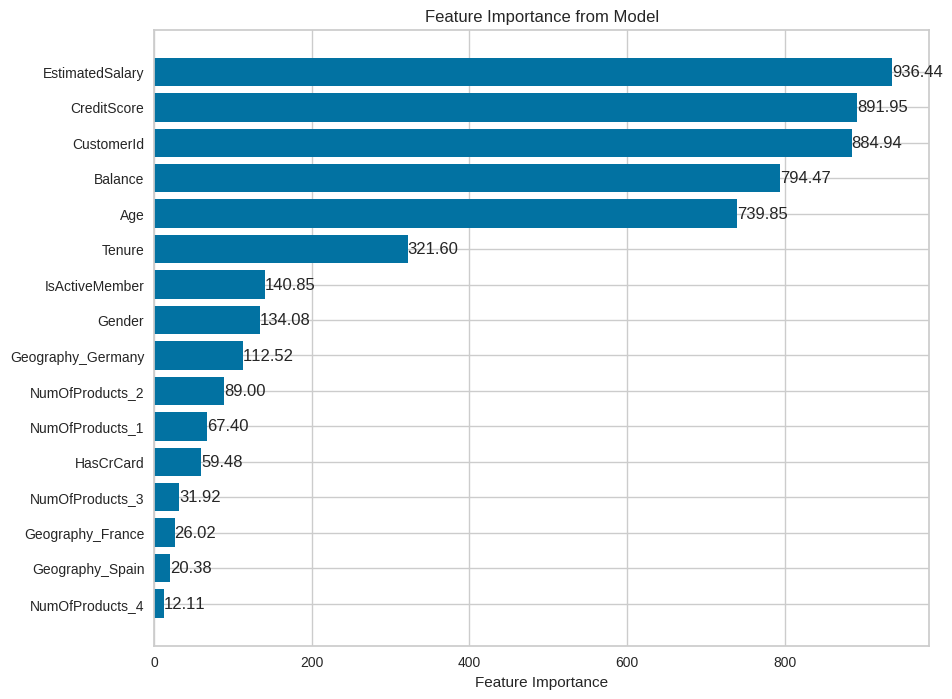

[LightGBM] [Warning] feature_fraction is set=0.9024601968835392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024601968835392
[LightGBM] [Warning] bagging_fraction is set=0.7342793249627353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342793249627353
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9024601968835392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024601968835392
[LightGBM] [Warning] bagging_fraction is set=0.7342793249627353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342793249627353
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9024601968835392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024601968835392
[LightGBM] [Warning] bagging

KeyboardInterrupt: 

In [ ]:
# 1. Feature Importance 계산 및 시각화(각 모델 feature importance 평균 사용)

def plot_feature_importance(model, model_columns):
    feature_importance = np.zeros(len(model_columns))
    for name, estimator in final_voting_model.named_estimators_.items():                            # named_estimators_ : 개별 추정기(estimator)들을 딕셔너리 형태로 저장
        if hasattr(estimator, "feature_importances_"):                                              # hasattr(객체, "속성_이름") : 객체가 속성을 갖고 있으면 True, 아니면 False 반환
            feature_importance += estimator.feature_importances_                                    # 각각의 모델 변수 중요도 더하기
    feature_importance /= len(final_voting_model.named_estimators_)                                 # 모델 개수로 나누기

    # Feature 중요도 시각화
    sorted_idx = np.argsort(feature_importance)[::-1]                                               # np.argsort() : 정렬된 값의 인덱스 반환 [start:stop:step] / [:: -1] -> 내림차순으로 변경
    sorted_features = np.array(model_columns)[sorted_idx]                                           # 변수 중요도에 따라 변수 명 정렬(인덱스따라)
    sorted_importances = feature_importance[sorted_idx]                                             # 변수 중요도에 따라 값 정렬

    plt.figure(figsize=(10, 8))
    bars = plt.barh(range(len(model_columns)), sorted_importances[::-1], align="center")            # barh : 가로 막대그래프 생성(기본적으로 y값 작은것부터 위로 쌓임) / sorted_importances[::-1] : 막대 길이 조정 / align : 막대 중심 위치
    plt.yticks(range(len(model_columns)), sorted_features[::-1])                                    # sorted_features[::-1] 사용 이유 : 위와 동일. 기본적으로 작은것부터 위로 쌓임
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance from Model")

    # 막대에 값 표시
    for bar, value in zip(bars, sorted_importances[::-1]):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center')    # plt.text(x, y, s, va='center') / bar.get_width() : 텍스트 x좌표, bar.get_y() + bar.get_height()/2 : 텍스트 y좌표, f'{value:.2f}', va='center' : 표시 할 텍스트

    plt.show()

# 2. Permutation Importance 계산 및 시각화
def plot_permutation_importance(model, X_valid, y_valid, feature_names):
    perm_importance = permutation_importance(
        model, X_valid, y_valid, scoring='roc_auc', n_repeats=5, random_state=42
    )

    # Feature 중요도 정렬
    sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]                                 # 중요도 높은 순서로 정렬
    sorted_features = np.array(feature_names)[sorted_idx]                                           # 정렬된 변수명
    sorted_importances = perm_importance.importances_mean[sorted_idx]                               # 정렬된 변수 중요도

    # Feature 중요도 시각화
    plt.figure(figsize=(10, 8))
    bars = plt.barh(range(len(feature_names)), sorted_importances[::-1], align="center")            # 내림차순 정렬한 막대그래프
    plt.yticks(range(len(feature_names)), sorted_features[::-1])                                    # y축 변수명도 동일한 순서로 정렬
    plt.xlabel("Permutation Importance")
    plt.title("Permutation Importance from Validation Set")

    # 막대에 값 표시
    for bar, value in zip(bars, sorted_importances[::-1]):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.4f}', va='center')

    plt.show()

# Feature Importance 그래프 생성
plot_feature_importance(final_voting_model, train_feature.columns)

# Permutation Importance 그래프 생성
plot_permutation_importance(final_voting_model, X_valid, y_valid, train_feature.columns)


#### feature importance


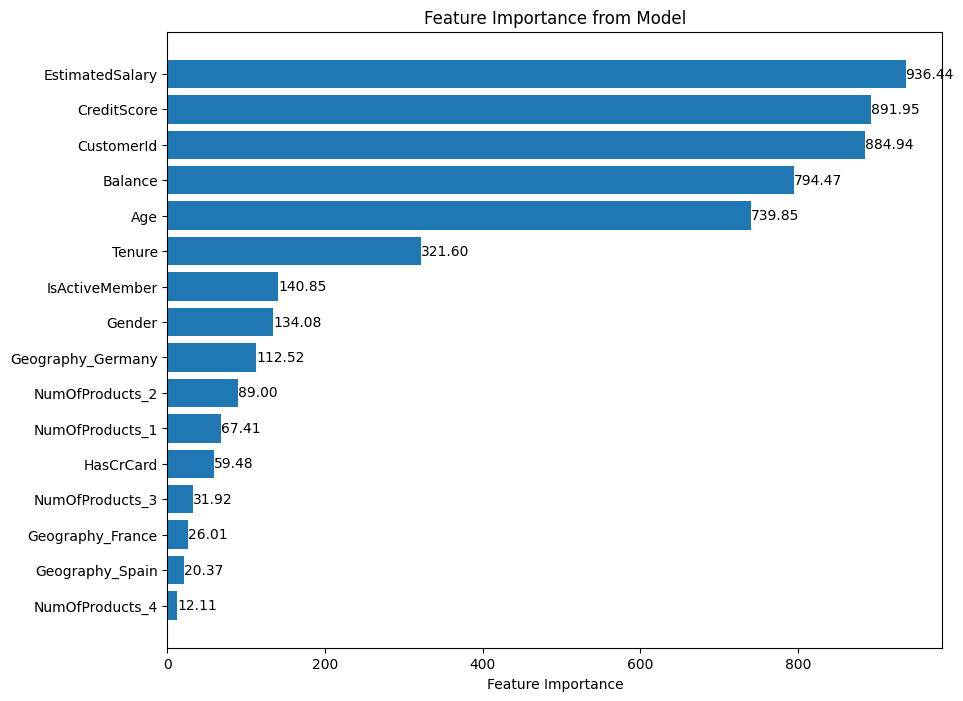

In [ ]:
from IPython.display import Image

Image('/content/drive/MyDrive/파이널 프로젝트_이정수/분류/원본_feature_importance.png')

#### permutation importance

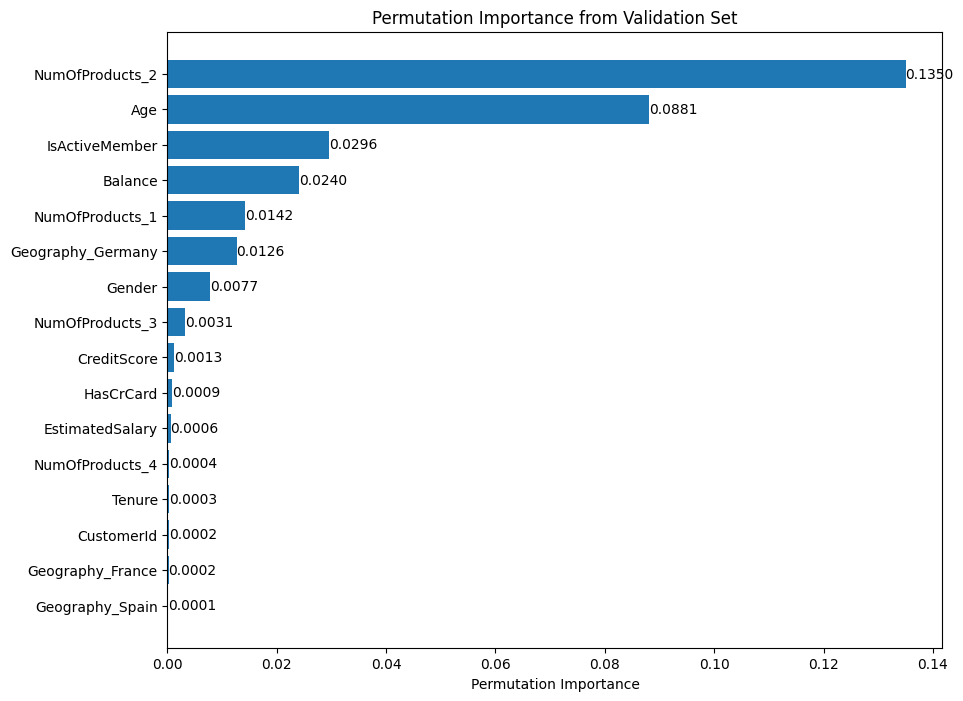

In [ ]:
Image('/content/drive/MyDrive/파이널 프로젝트_이정수/분류/원본_permutation_importance.png')

# 최종 모델 실행 코드

- 성능 : Final Model AUC Score: 0.8902

In [ ]:
# 기본 패키지
import pandas as pd  # 데이터프레임 생성 및 조작
import numpy as np  # 수치 계산 및 배열 처리

# 시각화
import matplotlib.pyplot as plt  # 기본적인 시각화 도구
import seaborn as sns  # 고급 시각화 도구 (matplotlib 기반)
import scipy.cluster.hierarchy as sch # 클러스터링


# 데이터 전처리
from sklearn.preprocessing import LabelEncoder  # 레이블 인코딩
# pd.get_dummies로 OneHotEncoder 대체 가능

# 데이터 분할
from sklearn.model_selection import train_test_split  # 데이터 분리
from sklearn.model_selection import StratifiedKFold  # 층화 교차 검증

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor  # 분산팽창계수(VIF) 계산

# 계층적 클러스터링
import scipy.cluster.hierarchy as sch  # 계층적 군집화 알고리즘

# Optuna: 하이퍼파라미터 최적화
import optuna  # 최적화 도구
from optuna.samplers import TPESampler  # 샘플링 알고리즘 (TPE)

# 머신러닝 모델들
from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting 모델
from sklearn.ensemble import RandomForestClassifier  # Random Forest 모델
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost 모델
from sklearn.tree import DecisionTreeClassifier  # 의사결정 트리 모델

# LightGBM
from lightgbm import LGBMClassifier  # LightGBM 분류기
import lightgbm as lgb  # LightGBM 라이브러리

# XGBoost
from xgboost import XGBClassifier  # XGBoost 분류기
import xgboost as xgb  # XGBoost 라이브러리

# CatBoost
from catboost import CatBoostClassifier, Pool  # CatBoost 분류기 및 데이터 준비 객체
from catboost.utils import eval_metric  # CatBoost 평가 지표 계산

# 성능 평가 지표
from sklearn.metrics import roc_auc_score  # ROC AUC 점수 계산

# 모델 앙상블
from sklearn.ensemble import VotingClassifier  # 앙상블 학습을 위한 VotingClassifier

# 기타 도구
from itertools import combinations  # 조합 생성
from sklearn.inspection import permutation_importance  # 변수 중요도 계산 (Permutation Importance)

# 출력 관련
from IPython.display import Image  # Jupyter Notebook에서 이미지 표시

# PyCaret: AutoML (자동화된 머신러닝 워크플로우)
from pycaret.classification import *

# 설정
pd.set_option('display.max_columns', None)  # 최대 컬럼 설정

In [ ]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/파이널 프로젝트_이정수/분류/train.csv')
test = pd.read_csv('/content/drive/MyDrive/파이널 프로젝트_이정수/분류/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/파이널 프로젝트_이정수/분류/sample_submission.csv')

# 변수 제거 및 인코딩
# train, test 동시 진행

# Id, Surname 제거
train.drop(columns=['id','Surname'],inplace=True)
test.drop(columns=['id','Surname'],inplace=True)

# Geography -> OneHot Encoding
train = pd.get_dummies(train, columns=['Geography'],dtype=int)
test = pd.get_dummies(test, columns=['Geography'], dtype=int)

# Gender -> Label Encoding
encoder = LabelEncoder()
train['Gender'] = encoder.fit_transform(train['Gender'])
test['Gender'] = encoder.transform(test['Gender'])

# Tenure -> Label Encoding
encoder = LabelEncoder()
train['Tenure'] = encoder.fit_transform(train['Tenure'])
test['Tenure'] = encoder.transform(test['Tenure'])


# NumOfProducts -> OneHot Encoding
train = pd.get_dummies(train, columns=['NumOfProducts'],dtype=int)
test = pd.get_dummies(test, columns=['NumOfProducts'], dtype=int)

# HasCrCard -> Label Encoding
encoder = LabelEncoder()
train['HasCrCard'] = encoder.fit_transform(train['HasCrCard'])
test['HasCrCard'] = encoder.transform(test['HasCrCard'])

# IsActiveMember -> Label Encoding
encoder = LabelEncoder()
train['IsActiveMember'] = encoder.fit_transform(train['IsActiveMember'])
test['IsActiveMember'] = encoder.transform(test['IsActiveMember'])

# feature, target 분리
train_feature = train.drop(columns='Exited')
train_target = train['Exited']

# 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_target,
                                                      test_size = 0.3,
                                                      random_state=0)

# 최종 모델 생성 : final_models
final_models = {
    'lightgbm': LGBMClassifier(
        n_estimators=424,  # num_boost_round 대신 n_estimators로 변경
        learning_rate=0.04631415040823912,
        num_leaves=38,
        max_depth=9,
        min_child_samples=47,
        feature_fraction=0.9024601968835392,
        bagging_fraction=0.7342793249627353,
        bagging_freq=2,
        min_split_gain=0.3017007245252093,
        reg_alpha=0.07886266683723922,
        reg_lambda=0.0859776680854032,
        tree_learner='serial',
        max_bin=310,
        num_threads=3,
        scale_pos_weight=3.8048327134060944
    ),
    'catboost': CatBoostClassifier(
        iterations=622,
        learning_rate=0.15620856452750326,
        depth=3,
        l2_leaf_reg=0.023092783762797234,
        random_strength=0.013271842224732251,
        bagging_temperature=6.81082830068841,
        grow_policy='SymmetricTree',
        border_count=117,
        od_wait=15,
        verbose=0,  # 학습 중 출력 비활성화
        random_state=42
    ),
    'gbc': GradientBoostingClassifier(
        n_estimators=441,
        learning_rate=0.045696033561884446,
        max_depth=7,
        min_samples_split=2,
        min_samples_leaf=2,
        subsample=0.9753636860597981,
        max_features='log2',
        loss='exponential',
        ccp_alpha=2.8658360294722587e-05,
        validation_fraction=0.27267380097000604,
        n_iter_no_change=17,
        tol=0.005721221703263734,
        min_impurity_decrease=0.04492762681125898,
        max_leaf_nodes=65
    )

}

# 소프트 보팅 모델 생성
final_voting_model = VotingClassifier(
    estimators=[('lightgbm', final_models['lightgbm']), ('catboost', final_models['catboost']),('gbc', final_models['gbc'])],
    voting='soft',
    weights=[0.20034185481390882, 0.20030143023417502, 0.2000023940758461]  # 최적 가중치 적용
)

# 학습
final_voting_model.fit(X_train, y_train)

# 예측
y_prob = final_voting_model.predict_proba(X_valid)[:, 1]
auc_score = roc_auc_score(y_valid, y_prob)

# 결과 출력
print(f"Final Model AUC Score: {auc_score:.4f}")

# 제출 파일 생성
# 테스트 데이터 예측
test_prob = final_voting_model.predict_proba(test)[:, 1]

submission['Exited'] = test_prob
submission.to_csv('origin_submission.csv',index=False)